### MPII 
---

#### MPII 데이터셋 다운로드 
- sudo apt install unzip # unzip 이 없는 경우 
- mkdir -p ~/aiffel/mpii
- cd ~/aiffel/mpii

- wget https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1.tar.gz
- wget https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1_u12_2.zip
- tar -xvf mpii_human_pose_v1.tar.gz -C .
- unzip mpii_human_pose_v1_u12_2.zip  
  
- cd ~/aiffel/mpii/mpii_human_pose_v1_u12_2
- wget https://aiffelstaticprd.blob.core.windows.net/media/documents/train.json
- wget https://aiffelstaticprd.blob.core.windows.net/media/documents/validation.json

### 데이터 전처리하기
- pip install loguru
- pip install ray

In [2]:
import csv
import io
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '-1' #CPU 사용
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

workdir = os.path.join(os.getenv('HOME'),'aiffel/mpii')
os.chdir(workdir)

from loguru import logger
from PIL import Image
import ray
import tensorflow as tf

num_train_shards = 64
num_val_shards = 8
ray.init()
tf.get_logger().setLevel('ERROR')

/home/ssac24/anaconda3/envs/aiffel/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)
2021-05-13 13:37:08,694	INFO services.py:1269 -- View the Ray dashboard at http://127.0.0.1:8265


### json 파싱하기

In [3]:
import json, os

json_file_path = os.getenv('HOME')+'/aiffel/mpii/mpii_human_pose_v1_u12_2/train.json'

with open(json_file_path) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2) # json beautify
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


#### joints 순서

0 - 오른쪽 발목 , 1 - 오른쪽 무릎, 2 - 오른쪽 엉덩이, 3 - 왼쪽 엉덩이, 4 - 왼쪽 무릎, 5 - 왼쪽 발목  
6 - 골반, 7 - 가슴(흉부), 8 - 목, 9 - 머리 위, 10 - 오른쪽 손목  
11 - 오른쪽 팔꿈치, 12 - 오른쪽 어깨, 13 - 왼쪽 어깨, 14 - 왼쪽 팔꿈치, 15 - 왼쪽 손목

#### 지정값
- 높이 = scale * 200px  
- center 는 사람의 중심점

In [4]:
# image 의 전체 path 를 묶어 dict 타입의 label 로 만들어낸다.
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

### tfrecord 파일 만들기

In [5]:
import ray

def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        # train_0001_of_0064.tfrecords
        build_single_tfrecord.remote(
            chunk, './tfrecords_mpii/{}_{}_of_{}.tfrecords'.format(
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

- annotation 을 total_shards 개수로 나눔(chunkify) (train : 64개, val : 8개)
- build_single_tfrecord 함수를 통해 tfrecord 로 저장
- 각 chunk 끼리 dependency 가 없기 때문에 병렬처리가 가능, ray를 사용

In [6]:
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n - 1):
        results.append(l[start:start + size])
        start += size
    results.append(l[start:])
    return results

- l 은 annotation, n은 shard 개수
- shard 개수 단위로 annotation list 를 나누어서 새로운 list를 만든다.
- numpy array 라고 가정하면 (size, shard, anno_content) 정도의 shape을 가지게 된다.

In [7]:
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno_list in chunk:
            tf_example = generate_tfexample(anno_list)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

- TFRecordWriter 를 이용해서 anno_list 를 shard 개수 단위로 작성한다.
- generate_tfexample 함수를 사용
- write 할 때 string 으로 serialize 해야한다.

In [8]:
def generate_tfexample(anno):
    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    # 0 - invisible, 1 - occluded, 2 - visible
    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

- 정의한 json 의 python type의 값들을 tfexample 에 사용할 수 있는 값으로 변환
- image 파일은 byte 로 변환한다. bitmap 으로 저장하게되면 파일용량이 상당히 커지기 때문에 만약 jpeg 타입이 아닌 경우 jpeg 으로 변환 후 content 로 불러서 저장 (H,W,C)
- 각 label 값을 tf.train.Feature 로 저장. 데이터 타입에 주의
- 이미지는 byte 인코딩 된 값을 그대로 넣는다.

In [9]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy(
        )  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [10]:
print('Start to parse annotations.')
if not os.path.exists('./tfrecords_mpii'):
        os.makedirs('./tfrecords_mpii')

Start to parse annotations.


In [11]:
with open('./mpii_human_pose_v1_u12_2/train.json') as train_json:
        train_annos = json.load(train_json)
        train_annotations = [
            parse_one_annotation(anno, './images/')
            for anno in train_annos
        ]
        print('First train annotation: ', train_annotations[0])
        del (train_annos)

First train annotation:  {'filename': '015601864.jpg', 'filepath': './images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


In [12]:
  with open('./mpii_human_pose_v1_u12_2/validation.json') as val_json:
        val_annos = json.load(val_json)
        val_annotations = [
            parse_one_annotation(anno, './images/') for anno in val_annos
        ]
        print('First val annotation: ', val_annotations[0])
        del (val_annos)

First val annotation:  {'filename': '005808361.jpg', 'filepath': './images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'center': [966.0, 340.0], 'scale': 4.718488}


In [12]:
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

Start to build TF Records.
(pid=6475) start to build tf records for ./tfrecords_mpii/train_0012_of_0064.tfrecords
(pid=6471) start to build tf records for ./tfrecords_mpii/train_0006_of_0064.tfrecords
(pid=6470) start to build tf records for ./tfrecords_mpii/train_0003_of_0064.tfrecords
(pid=6476) start to build tf records for ./tfrecords_mpii/train_0001_of_0064.tfrecords
(pid=6479) start to build tf records for ./tfrecords_mpii/train_0008_of_0064.tfrecords
(pid=6473) start to build tf records for ./tfrecords_mpii/train_0007_of_0064.tfrecords
(pid=6472) start to build tf records for ./tfrecords_mpii/train_0010_of_0064.tfrecords
(pid=6478) start to build tf records for ./tfrecords_mpii/train_0011_of_0064.tfrecords
(pid=6477) start to build tf records for ./tfrecords_mpii/train_0004_of_0064.tfrecords
(pid=6474) start to build tf records for ./tfrecords_mpii/train_0002_of_0064.tfrecords
(pid=6480) start to build tf records for ./tfrecords_mpii/train_0005_of_0064.tfrecords
(pid=6469) start

(pid=6475) finished building tf records for ./tfrecords_mpii/train_0035_of_0064.tfrecords
(pid=6475) start to build tf records for ./tfrecords_mpii/train_0048_of_0064.tfrecords
(pid=6471) finished building tf records for ./tfrecords_mpii/train_0038_of_0064.tfrecords
(pid=6480) finished building tf records for ./tfrecords_mpii/train_0036_of_0064.tfrecords
(pid=6480) start to build tf records for ./tfrecords_mpii/train_0049_of_0064.tfrecords
(pid=6471) start to build tf records for ./tfrecords_mpii/train_0050_of_0064.tfrecords
(pid=6474) finished building tf records for ./tfrecords_mpii/train_0040_of_0064.tfrecords
(pid=6474) start to build tf records for ./tfrecords_mpii/train_0051_of_0064.tfrecords
(pid=6469) finished building tf records for ./tfrecords_mpii/train_0039_of_0064.tfrecords
(pid=6469) start to build tf records for ./tfrecords_mpii/train_0052_of_0064.tfrecords
(pid=6473) finished building tf records for ./tfrecords_mpii/train_0041_of_0064.tfrecords
(pid=6473) start to build

In [13]:
print('Successfully wrote {} annotations to TF Records.'.format(
len(train_annotations) + len(val_annotations)))

Successfully wrote 25204 annotations to TF Records.


### Data Label로 만들기

In [14]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y)

        # print (image.shape, heatmaps.shape, type(heatmaps))

        return image, heatmaps

    def parse_tfexample(self, example_proto):
            image_feature_description = {
                'image/height': tf.io.FixedLenFeature([], tf.int64),
                'image/width': tf.io.FixedLenFeature([], tf.int64),
                'image/depth': tf.io.FixedLenFeature([], tf.int64),
                'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
                'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
                'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
                'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
                'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
                'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
                'image/encoded': tf.io.FixedLenFeature([], tf.string),
                'image/filename': tf.io.FixedLenFeature([], tf.string),
            }
            return tf.io.parse_single_example(example_proto,
                                              image_feature_description)

    def crop_roi(self, image, features, margin=0.2):
            img_shape = tf.shape(image)
            img_height = img_shape[0]
            img_width = img_shape[1]
            img_depth = img_shape[2]

            keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
            keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
            center_x = features['image/object/center/x']
            center_y = features['image/object/center/y']
            body_height = features['image/object/scale'] * 200.0

            # keypoint 중 유효한값(visible = 1) 만 사용합니다.
            masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
            masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

            # min, max 값을 찾습니다.
            keypoint_xmin = tf.reduce_min(masked_keypoint_x)
            keypoint_xmax = tf.reduce_max(masked_keypoint_x)
            keypoint_ymin = tf.reduce_min(masked_keypoint_y)
            keypoint_ymax = tf.reduce_max(masked_keypoint_y)

            # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
            xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
            xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
            ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
            ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

            # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
            effective_xmin = xmin if xmin > 0 else 0
            effective_ymin = ymin if ymin > 0 else 0
            effective_xmax = xmax if xmax < img_width else img_width
            effective_ymax = ymax if ymax < img_height else img_height
            effective_height = effective_ymax - effective_ymin
            effective_width = effective_xmax - effective_xmin

            image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
            new_shape = tf.shape(image)
            new_height = new_shape[0]
            new_width = new_shape[1]

            # shift all keypoints based on the crop area
            effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
            effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

            return image, effective_keypoint_x, effective_keypoint_y

    def make_heatmaps(self, features, keypoint_x, keypoint_y):
            v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
            x = tf.cast(tf.math.round(keypoint_x * self.heatmap_shape[0]), dtype=tf.int32)
            y = tf.cast(tf.math.round(keypoint_y * self.heatmap_shape[1]), dtype=tf.int32)

            num_heatmap = self.heatmap_shape[2]
            heatmap_array = tf.TensorArray(tf.float32, 16)

            for i in range(num_heatmap):
                gaussian = self.generate_2d_guassian(self.heatmap_shape[1], self.heatmap_shape[0], y[i], x[i], v[i])
                heatmap_array = heatmap_array.write(i, gaussian)

            heatmaps = heatmap_array.stack()
            heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)

            return heatmaps

    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
            """
            "The same technique as Tompson et al. is used for supervision. A MeanSquared Error (MSE) loss is
            applied comparing the predicted heatmap to a ground-truth heatmap consisting of a 2D gaussian
            (with standard deviation of 1 px) centered on the keypoint location."

            https://github.com/princeton-vl/pose-hg-train/blob/master/src/util/img.lua#L204
            """
            heatmap = tf.zeros((height, width))

            # this gaussian patch is 7x7, let's get four corners of it first
            xmin = x0 - 3 * sigma
            ymin = y0 - 3 * sigma
            xmax = x0 + 3 * sigma
            ymax = y0 + 3 * sigma
            # if the patch is out of image boundary we simply return nothing according to the source code
            # [1]"In these cases the joint is either truncated or severely occluded, so for
            # supervision a ground truth heatmap of all zeros is provided."
            if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
                return heatmap

            size = 6 * sigma + 1
            x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

            # the center of the gaussian patch should be 1
            center_x = size // 2
            center_y = size // 2

            # generate this 7x7 gaussian patch
            gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

            # part of the patch could be out of the boundary, so we need to determine the valid range
            # if xmin = -2, it means the 2 left-most columns are invalid, which is max(0, -(-2)) = 2
            patch_xmin = tf.math.maximum(0, -xmin)
            patch_ymin = tf.math.maximum(0, -ymin)
            # if xmin = 59, xmax = 66, but our output is 64x64, then we should discard 2 right-most columns
            # which is min(64, 66) - 59 = 5, and column 6 and 7 are discarded
            patch_xmax = tf.math.minimum(xmax, width) - xmin
            patch_ymax = tf.math.minimum(ymax, height) - ymin

            # also, we need to determine where to put this patch in the whole heatmap
            heatmap_xmin = tf.math.maximum(0, xmin)
            heatmap_ymin = tf.math.maximum(0, ymin)
            heatmap_xmax = tf.math.minimum(xmax, width)
            heatmap_ymax = tf.math.minimum(ymax, height)

            # finally, insert this patch into the heatmap
            indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
            updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

            count = 0

            for j in tf.range(patch_ymin, patch_ymax):
                for i in tf.range(patch_xmin, patch_xmax):
                    indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                    updates = updates.write(count, gaussian_patch[j][i])
                    count += 1

            heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

            return heatmap

- tfrecord 파일이기 때문에 병렬로 읽는 것은 tf 가 지원해주므로 self.parse_tfexample() 에 구현되어 있고 이 함수를 통해 tf.tensor 로 이루어진 dictionary 형태의 features를 얻을 수 있다.
- image 는 features['image/encoded'] 형태로 사용할 수 있고 tfrecord 를 저장할 때 jpeg encoding 된 값을 넣었으므로 tf.io.decode_jpeg()로 decoding 하여 tensor 형태의 이미지를 얻는다.
- crop_roi() 메소드를 이용해 해당 이미지를 학습하기 편하도록 몇가지 트릭을 적용
- make_heatmaps() 메소드를 이용해 label을 heatmap 으로 나타낸다.

- 16개의 점을 generate_2d_gaussian() 함수를 이용해서 64x64 의 map 에 표현

### Hourglass 모델

In [15]:
import tensorflow as tf

from tensorflow.keras.layers import (
    Add,
    Concatenate,
    Conv2D,
    Input,
    Lambda,
    ReLU,
    MaxPool2D,
    UpSampling2D,
    ZeroPadding2D,
    BatchNormalization,
)

def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,  # lift channels first
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x


def HourglassModule(inputs, order, filters, num_residual):
    """
    https://github.com/princeton-vl/pose-hg-train/blob/master/src/models/hg.lua#L3
    """
    # Upper branch
    up1 = BottleneckBlock(inputs, filters, downsample=False)

    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    # Lower branch
    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1


def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x


def StackedHourglassNetwork(
        input_shape=(256, 256, 3), num_stack=4, num_residual=1,
        num_heatmap=16):
    """
    https://github.com/princeton-vl/pose-hg-train/blob/master/src/models/hg.lua#L33
    """
    inputs = Input(shape=input_shape)

    # initial processing of the image
    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        # predict 256 channels like a fully connected layer.
        x = LinearLayer(x, 256)

        # predict final channels, which is also the number of predicted heatmap
        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        # if it's not the last stack, we need to add predictions back
        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

- residual block 의 2가지 타입
  - 3x3-3x3 basic block, 1x1-3x3-1x1 bottleneck block

### 학습 엔진 생성

#### Trainer Class

In [16]:
import math
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from datetime import datetime

import click
import tensorflow as tf

from hourglass104 import StackedHourglassNetwork
from preprocess import Preprocessor

IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def automatic_gpu_usage() :
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)


class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate,
                 version='0.0.1',
                 start_epoch=1,
                 tensorboard_dir='./logs'):
        self.start_epoch = start_epoch
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        # "we use rmsprop with a learning rate of 2.5e-4.""
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.tensorboard_dir = tensorboard_dir
        self.best_model = None
        self.version = version

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0.0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.experimental_run_v2(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.experimental_run_v2(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        summary_writer = tf.summary.create_file_writer(self.tensorboard_dir)
        summary_writer.set_as_default()

        for epoch in range(self.start_epoch, self.epochs + 1):
            tf.summary.experimental.set_step(epoch)

            self.lr_decay()
            tf.summary.scalar('epoch learning rate',
                              self.current_learning_rate)

            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))
            tf.summary.scalar('epoch train loss', train_loss)

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))
            tf.summary.scalar('epoch val loss', val_loss)

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = './models/model-v{}-epoch-{}-loss-{:.4f}.h5'.format(
            self.version, epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))


def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset


def train(epochs, start_epoch, learning_rate, tensorboard_dir, checkpoint,
          num_heatmap, batch_size, train_tfrecords, val_tfrecords, version):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(os.path.join('./models')):
        os.makedirs(os.path.join('./models/'))

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)
        if checkpoint and os.path.exists(checkpoint):
            model.load_weights(checkpoint)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate,
            start_epoch=start_epoch,
            version=version,
            tensorboard_dir=tensorboard_dir)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)



- loss : MSE (heatmap 을 pixel 단위 MSE 로 계산)
- strategy : 분산학습용 tf.strategy
- optimizer : Adam

- weight 가 82인 이유는 heatmap 전체 크기인 64x64 에서 gaussian point 등장 비율이 7x7 패치이기 때문에 64 / 7 = 9.1 ⇒ 9x9 로 계산

#### tf.dataset 생성

In [17]:
tfrecords_dir = './tfrecords_mpii/'
train_tfrecords = os.path.join(tfrecords_dir, 'train*')
val_tfrecords = os.path.join(tfrecords_dir, 'val*')
epochs = 1
batch_size = 8
num_heatmap = 16
tensorboard_dir = './logs/'
learning_rate = 0.0007
start_epoch = 1

automatic_gpu_usage()

pretrained_path = None # './aiffel/mpii/models/model-v0.0.3-epoch-1-loss-1.0744.h5'


1 Physical GPUs, 1 Logical GPUs


In [ ]:
train(epochs, start_epoch, learning_rate, tensorboard_dir, pretrained_path,
      num_heatmap, batch_size, train_tfrecords, val_tfrecords, '0.0.1')

In [ ]:
Epoch 1 train loss 3.016350507736206
Epoch 1 val loss 2.8107478618621826
Epoch 2 train loss 2.6417295932769775
Epoch 2 val loss 2.5474207401275635
Epoch 3 train loss 2.480766773223877
Epoch 3 val loss 2.4258360862731934
Epoch 4 train loss 2.3790476322174072
Epoch 4 val loss 2.3981611728668213
Epoch 5 train loss 2.301722764968872
Epoch 5 val loss 2.3633511066436768
Epoch 6 train loss 2.245046854019165
Epoch 6 val loss 2.2849104404449463
Epoch 7 train loss 2.200047731399536
Epoch 7 val loss 2.2695059776306152
Epoch 8 train loss 2.1575076580047607
Epoch 8 val loss 2.2411489486694336
Epoch 9 train loss 2.1196413040161133
Epoch 9 val loss 2.260293483734131
Epoch 10 train loss 2.0881552696228027
Epoch 10 val loss 2.2118003368377686

### 예측 엔진 생성

In [18]:
import json
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import math
import cv2
import numpy as np
from hourglass104 import StackedHourglassNetwork
from preprocess import Preprocessor

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

plt.rcParams["figure.figsize"] = (10,10)

In [19]:
def automatic_gpu_usage() :
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

automatic_gpu_usage()


1 Physical GPUs, 1 Logical GPUs


In [20]:
model = StackedHourglassNetwork(
         input_shape=(256, 256, 3), num_stack=4, num_residual=1,
         num_heatmap=16)

model.load_weights('./models/model-v0.0.3-epoch-1-loss-1.0744.h5')

In [21]:
# 사용할 Hyper Parameter
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],

    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

In [22]:
# heatmap to coordinate
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (4096, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

- 모델 출력이 64x64 heatmap 으로 나오기 때문에 최대값을 찾는 함수가 필요하기때문에 64x64 를 fatten 후 argmax index 를 찾는다. 64x64 이미지 이기 때문에 row 와 col 값을 몫과 나머지로 표현하면 쉽게 값을 얻을 수 있다.
- 256x256 이미지에 64x64 heatmap max 값을 표현하려면 quantization 오차가 발생하기 때문에 실제 계산에서는 3x3 필터를 이용해서 근사치를 구해준다.

In [23]:
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        # since we've padded the heatmap, the max keypoint should increment by 1
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        # the patch is the 3x3 grid around the max keypoint location
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        # assign 0 to max location
        patch[1][1] = 0
        # and the next largest value is the largest neigbour we are looking for
        index = np.argmax(patch)
        # find out the location of it relative to center
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        # we can then add original max keypoint location with this offset
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
    # we do need to clip the value to make sure there's no keypoint out of border, just in case.
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    # normalize the points so that we can scale back easily
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

#### 예측함수

In [24]:
def predict(image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

#### keypoint 그리기

In [25]:
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()


#### 스켈레톤 그리기

In [26]:
def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    # draw skeleton
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

#### 결과 비교

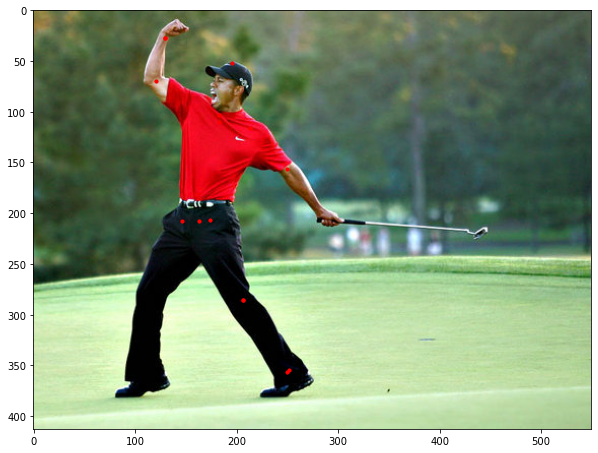

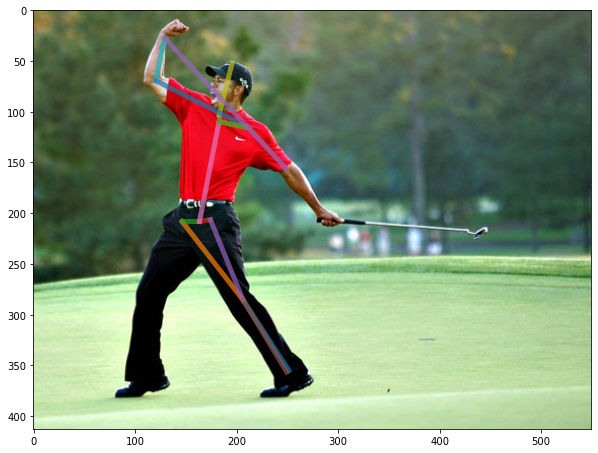

In [38]:
image, keypoints = predict('./test_image.jpg')
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

### 프로젝트 : simplebaseline 모델로 변경

In [28]:
import tensorflow as tf

def _make_deconv_layer(num_deconv_layers):
    seq_model = tf.keras.models.Sequential()
    for i in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same'))
        seq_model.add(tf.keras.layers.BatchNormalization())
        seq_model.add(tf.keras.layers.ReLU())
    return seq_model

def Simplebaseline(input_shape=(256, 256, 3)):
    resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')
    upconv = _make_deconv_layer(3)
    # num_heatmap => 16
    final_layer = tf.keras.layers.Conv2D(num_heatmap, kernel_size=(1,1), padding='same')

    inputs = tf.keras.Input(shape=input_shape)    
    x = resnet(inputs)
    x = upconv(x)
    out = final_layer(x)
    model = tf.keras.Model(inputs, out, name='simple_baseline')
    return model 



m = Simplebaseline()
m.summary()

Model: "simple_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
sequential (Sequential)      (None, 64, 64, 256)       10489600  
_________________________________________________________________
conv2d_244 (Conv2D)          (None, 64, 64, 16)        4112      
Total params: 34,081,424
Trainable params: 34,026,768
Non-trainable params: 54,656
_________________________________________________________________


In [29]:
def train(epochs, start_epoch, learning_rate, tensorboard_dir, checkpoint,
          num_heatmap, batch_size, train_tfrecords, val_tfrecords, version):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(os.path.join('./models')):
        os.makedirs(os.path.join('./models/'))

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = Simplebaseline(IMAGE_SHAPE)
        if checkpoint and os.path.exists(checkpoint):
            model.load_weights(checkpoint)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate,
            start_epoch=start_epoch,
            version=version,
            tensorboard_dir=tensorboard_dir)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

In [30]:
tfrecords_dir = './tfrecords_mpii/'
train_tfrecords = os.path.join(tfrecords_dir, 'train*')
val_tfrecords = os.path.join(tfrecords_dir, 'val*')
epochs = 10
batch_size = 8
num_heatmap = 16
tensorboard_dir = './logs/'
learning_rate = 0.0007
start_epoch = 1

automatic_gpu_usage()

pretrained_path = None # './models_old/model-v0.0.2-epoch-15-loss-1.1013.h5'

1 Physical GPUs, 1 Logical GPUs


In [31]:
train(epochs, start_epoch, learning_rate, tensorboard_dir, pretrained_path,
      num_heatmap, batch_size, train_tfrecords, val_tfrecords, '0.0.2')

Start training...
Start epoch 1 with learning rate 0.0007
Start distributed traininng...
Trained batch 1 batch loss 9.43671227 epoch total loss 9.43671227
Trained batch 2 batch loss 10.3279333 epoch total loss 9.88232231
Trained batch 3 batch loss 7.49945688 epoch total loss 9.08803368
Trained batch 4 batch loss 7.34267187 epoch total loss 8.65169334
Trained batch 5 batch loss 6.81644154 epoch total loss 8.28464317
Trained batch 6 batch loss 7.15909052 epoch total loss 8.09705067
Trained batch 7 batch loss 7.35565472 epoch total loss 7.9911375
Trained batch 8 batch loss 6.79904461 epoch total loss 7.84212589
Trained batch 9 batch loss 6.49794674 epoch total loss 7.69277287
Trained batch 10 batch loss 6.30847597 epoch total loss 7.55434322
Trained batch 11 batch loss 6.39118099 epoch total loss 7.44860125
Trained batch 12 batch loss 6.16022682 epoch total loss 7.34123659
Trained batch 13 batch loss 6.55704641 epoch total loss 7.28091431
Trained batch 14 batch loss 6.44881201 epoch total

Trained batch 123 batch loss 6.4942565 epoch total loss 6.65391207
Trained batch 124 batch loss 6.13974285 epoch total loss 6.64976597
Trained batch 125 batch loss 6.38206244 epoch total loss 6.64762449
Trained batch 126 batch loss 5.92520809 epoch total loss 6.641891
Trained batch 127 batch loss 6.48156595 epoch total loss 6.64062881
Trained batch 128 batch loss 6.37705278 epoch total loss 6.63857
Trained batch 129 batch loss 6.73364592 epoch total loss 6.63930702
Trained batch 130 batch loss 6.98084736 epoch total loss 6.64193392
Trained batch 131 batch loss 6.51912069 epoch total loss 6.64099646
Trained batch 132 batch loss 6.58364773 epoch total loss 6.64056158
Trained batch 133 batch loss 6.68667126 epoch total loss 6.64090824
Trained batch 134 batch loss 5.90826464 epoch total loss 6.63544083
Trained batch 135 batch loss 6.37549353 epoch total loss 6.63351488
Trained batch 136 batch loss 6.50553417 epoch total loss 6.63257408
Trained batch 137 batch loss 6.49995708 epoch total lo

Trained batch 245 batch loss 7.18780947 epoch total loss 6.53546858
Trained batch 246 batch loss 7.34251213 epoch total loss 6.53874922
Trained batch 247 batch loss 7.02824879 epoch total loss 6.54073095
Trained batch 248 batch loss 6.79456472 epoch total loss 6.54175425
Trained batch 249 batch loss 6.68547964 epoch total loss 6.54233122
Trained batch 250 batch loss 6.7393508 epoch total loss 6.54311943
Trained batch 251 batch loss 6.93852 epoch total loss 6.5446949
Trained batch 252 batch loss 6.11597395 epoch total loss 6.54299355
Trained batch 253 batch loss 5.78803 epoch total loss 6.5400095
Trained batch 254 batch loss 5.47308254 epoch total loss 6.53580904
Trained batch 255 batch loss 5.66673565 epoch total loss 6.53240061
Trained batch 256 batch loss 5.51278591 epoch total loss 6.52841806
Trained batch 257 batch loss 5.27145529 epoch total loss 6.52352715
Trained batch 258 batch loss 5.34142399 epoch total loss 6.51894569
Trained batch 259 batch loss 5.38284874 epoch total loss 

Trained batch 367 batch loss 6.69614029 epoch total loss 6.4894309
Trained batch 368 batch loss 6.26959658 epoch total loss 6.48883343
Trained batch 369 batch loss 6.71091557 epoch total loss 6.4894352
Trained batch 370 batch loss 6.36313343 epoch total loss 6.4890933
Trained batch 371 batch loss 6.61069965 epoch total loss 6.48942089
Trained batch 372 batch loss 6.50912619 epoch total loss 6.48947382
Trained batch 373 batch loss 6.70094252 epoch total loss 6.49004078
Trained batch 374 batch loss 6.52367687 epoch total loss 6.49013042
Trained batch 375 batch loss 7.10038948 epoch total loss 6.49175787
Trained batch 376 batch loss 6.46822739 epoch total loss 6.4916954
Trained batch 377 batch loss 5.7890749 epoch total loss 6.48983145
Trained batch 378 batch loss 4.87118673 epoch total loss 6.48554897
Trained batch 379 batch loss 4.82707167 epoch total loss 6.48117352
Trained batch 380 batch loss 4.68519402 epoch total loss 6.47644758
Trained batch 381 batch loss 5.17145443 epoch total l

Trained batch 489 batch loss 6.91677761 epoch total loss 6.48799562
Trained batch 490 batch loss 7.21295166 epoch total loss 6.48947525
Trained batch 491 batch loss 7.58500099 epoch total loss 6.49170637
Trained batch 492 batch loss 6.0141449 epoch total loss 6.49073553
Trained batch 493 batch loss 7.06812572 epoch total loss 6.49190664
Trained batch 494 batch loss 6.87358761 epoch total loss 6.49267912
Trained batch 495 batch loss 6.90384293 epoch total loss 6.49351
Trained batch 496 batch loss 6.80929899 epoch total loss 6.49414635
Trained batch 497 batch loss 5.90033579 epoch total loss 6.49295187
Trained batch 498 batch loss 6.70258 epoch total loss 6.49337292
Trained batch 499 batch loss 6.56310701 epoch total loss 6.49351263
Trained batch 500 batch loss 6.60987616 epoch total loss 6.49374533
Trained batch 501 batch loss 6.42623234 epoch total loss 6.49361038
Trained batch 502 batch loss 6.55621 epoch total loss 6.49373484
Trained batch 503 batch loss 6.26097631 epoch total loss 6

Trained batch 611 batch loss 6.08210182 epoch total loss 6.473557
Trained batch 612 batch loss 6.38589478 epoch total loss 6.47341394
Trained batch 613 batch loss 6.55832911 epoch total loss 6.47355223
Trained batch 614 batch loss 6.7899332 epoch total loss 6.47406769
Trained batch 615 batch loss 6.36113787 epoch total loss 6.47388411
Trained batch 616 batch loss 6.43027496 epoch total loss 6.47381306
Trained batch 617 batch loss 6.40552807 epoch total loss 6.47370243
Trained batch 618 batch loss 6.23934507 epoch total loss 6.47332287
Trained batch 619 batch loss 6.54203415 epoch total loss 6.47343397
Trained batch 620 batch loss 6.48661566 epoch total loss 6.47345543
Trained batch 621 batch loss 6.4005971 epoch total loss 6.47333813
Trained batch 622 batch loss 6.2029829 epoch total loss 6.47290325
Trained batch 623 batch loss 6.43715191 epoch total loss 6.47284603
Trained batch 624 batch loss 6.23336 epoch total loss 6.47246218
Trained batch 625 batch loss 5.79895067 epoch total loss

Trained batch 733 batch loss 6.60787678 epoch total loss 6.43946266
Trained batch 734 batch loss 6.65879536 epoch total loss 6.43976116
Trained batch 735 batch loss 6.78036308 epoch total loss 6.44022465
Trained batch 736 batch loss 6.98650074 epoch total loss 6.44096661
Trained batch 737 batch loss 6.53371239 epoch total loss 6.44109201
Trained batch 738 batch loss 5.8079257 epoch total loss 6.44023466
Trained batch 739 batch loss 4.48867035 epoch total loss 6.43759394
Trained batch 740 batch loss 5.89293098 epoch total loss 6.43685818
Trained batch 741 batch loss 5.12708092 epoch total loss 6.43509
Trained batch 742 batch loss 5.686203 epoch total loss 6.4340806
Trained batch 743 batch loss 6.35975409 epoch total loss 6.43398094
Trained batch 744 batch loss 6.36256123 epoch total loss 6.4338851
Trained batch 745 batch loss 6.06152344 epoch total loss 6.43338537
Trained batch 746 batch loss 5.90331888 epoch total loss 6.43267488
Trained batch 747 batch loss 6.4487381 epoch total loss 

Trained batch 855 batch loss 6.73800421 epoch total loss 6.44077635
Trained batch 856 batch loss 6.84057617 epoch total loss 6.44124317
Trained batch 857 batch loss 6.72191572 epoch total loss 6.44157028
Trained batch 858 batch loss 6.97584295 epoch total loss 6.44219351
Trained batch 859 batch loss 6.26608372 epoch total loss 6.44198847
Trained batch 860 batch loss 6.78759 epoch total loss 6.44239
Trained batch 861 batch loss 6.47231913 epoch total loss 6.44242477
Trained batch 862 batch loss 6.4802227 epoch total loss 6.44246817
Trained batch 863 batch loss 6.58169842 epoch total loss 6.44262934
Trained batch 864 batch loss 6.56575251 epoch total loss 6.44277239
Trained batch 865 batch loss 6.71153927 epoch total loss 6.44308281
Trained batch 866 batch loss 6.46221733 epoch total loss 6.44310522
Trained batch 867 batch loss 6.08099318 epoch total loss 6.44268751
Trained batch 868 batch loss 6.17225838 epoch total loss 6.44237614
Trained batch 869 batch loss 6.43791771 epoch total los

Trained batch 977 batch loss 5.80854273 epoch total loss 6.44115639
Trained batch 978 batch loss 6.53287792 epoch total loss 6.44125
Trained batch 979 batch loss 6.18773603 epoch total loss 6.44099092
Trained batch 980 batch loss 6.8866291 epoch total loss 6.44144583
Trained batch 981 batch loss 6.78184795 epoch total loss 6.44179249
Trained batch 982 batch loss 6.5356493 epoch total loss 6.44188786
Trained batch 983 batch loss 6.30471897 epoch total loss 6.44174862
Trained batch 984 batch loss 5.96203756 epoch total loss 6.44126081
Trained batch 985 batch loss 6.10174322 epoch total loss 6.44091606
Trained batch 986 batch loss 6.19188499 epoch total loss 6.44066334
Trained batch 987 batch loss 6.12620163 epoch total loss 6.44034481
Trained batch 988 batch loss 6.75345802 epoch total loss 6.44066143
Trained batch 989 batch loss 7.0623765 epoch total loss 6.44129038
Trained batch 990 batch loss 7.10523224 epoch total loss 6.44196129
Trained batch 991 batch loss 7.00044346 epoch total lo

Trained batch 1097 batch loss 5.68349552 epoch total loss 6.43209743
Trained batch 1098 batch loss 6.24753523 epoch total loss 6.43192911
Trained batch 1099 batch loss 6.09908772 epoch total loss 6.43162632
Trained batch 1100 batch loss 5.60425949 epoch total loss 6.43087435
Trained batch 1101 batch loss 5.92206573 epoch total loss 6.43041229
Trained batch 1102 batch loss 6.61092758 epoch total loss 6.43057585
Trained batch 1103 batch loss 6.73423862 epoch total loss 6.43085146
Trained batch 1104 batch loss 6.60883379 epoch total loss 6.43101263
Trained batch 1105 batch loss 6.86116362 epoch total loss 6.43140221
Trained batch 1106 batch loss 6.67618799 epoch total loss 6.43162346
Trained batch 1107 batch loss 6.57350969 epoch total loss 6.43175173
Trained batch 1108 batch loss 6.52684689 epoch total loss 6.43183756
Trained batch 1109 batch loss 6.55403233 epoch total loss 6.43194818
Trained batch 1110 batch loss 6.45469284 epoch total loss 6.43196821
Trained batch 1111 batch loss 6.53

Trained batch 1217 batch loss 5.96489191 epoch total loss 6.43256807
Trained batch 1218 batch loss 5.73452902 epoch total loss 6.43199492
Trained batch 1219 batch loss 5.87031507 epoch total loss 6.43153429
Trained batch 1220 batch loss 6.68219328 epoch total loss 6.43173933
Trained batch 1221 batch loss 6.7483182 epoch total loss 6.43199873
Trained batch 1222 batch loss 6.26931 epoch total loss 6.43186617
Trained batch 1223 batch loss 6.69255066 epoch total loss 6.43207884
Trained batch 1224 batch loss 6.20022106 epoch total loss 6.43188953
Trained batch 1225 batch loss 6.30688143 epoch total loss 6.43178749
Trained batch 1226 batch loss 6.20618582 epoch total loss 6.43160295
Trained batch 1227 batch loss 6.09870148 epoch total loss 6.43133163
Trained batch 1228 batch loss 5.81376648 epoch total loss 6.43082905
Trained batch 1229 batch loss 5.80020857 epoch total loss 6.43031597
Trained batch 1230 batch loss 6.43702602 epoch total loss 6.43032169
Trained batch 1231 batch loss 6.699450

Trained batch 1337 batch loss 6.43090487 epoch total loss 6.42042732
Trained batch 1338 batch loss 6.34584475 epoch total loss 6.42037153
Trained batch 1339 batch loss 6.29511738 epoch total loss 6.4202776
Trained batch 1340 batch loss 6.53421831 epoch total loss 6.42036295
Trained batch 1341 batch loss 6.25047398 epoch total loss 6.42023563
Trained batch 1342 batch loss 6.32043028 epoch total loss 6.42016125
Trained batch 1343 batch loss 6.3477664 epoch total loss 6.42010736
Trained batch 1344 batch loss 6.0512867 epoch total loss 6.41983318
Trained batch 1345 batch loss 6.55752754 epoch total loss 6.4199357
Trained batch 1346 batch loss 6.08950615 epoch total loss 6.41969061
Trained batch 1347 batch loss 6.48609209 epoch total loss 6.41973972
Trained batch 1348 batch loss 6.43216515 epoch total loss 6.41974926
Trained batch 1349 batch loss 6.35307741 epoch total loss 6.4197
Trained batch 1350 batch loss 6.40707684 epoch total loss 6.41969109
Trained batch 1351 batch loss 5.97593403 e

Trained batch 1457 batch loss 6.47065496 epoch total loss 6.41156101
Trained batch 1458 batch loss 6.0285449 epoch total loss 6.41129827
Trained batch 1459 batch loss 6.36682 epoch total loss 6.41126823
Trained batch 1460 batch loss 6.45983887 epoch total loss 6.41130114
Trained batch 1461 batch loss 5.4895153 epoch total loss 6.41067028
Trained batch 1462 batch loss 6.49072075 epoch total loss 6.41072464
Trained batch 1463 batch loss 6.02773476 epoch total loss 6.41046286
Trained batch 1464 batch loss 6.08337688 epoch total loss 6.41023874
Trained batch 1465 batch loss 6.05232525 epoch total loss 6.40999508
Trained batch 1466 batch loss 6.01814508 epoch total loss 6.40972805
Trained batch 1467 batch loss 6.30104876 epoch total loss 6.40965366
Trained batch 1468 batch loss 6.25509167 epoch total loss 6.40954828
Trained batch 1469 batch loss 5.96442938 epoch total loss 6.40924549
Trained batch 1470 batch loss 6.00413465 epoch total loss 6.40897
Trained batch 1471 batch loss 6.51634598 e

Trained batch 1577 batch loss 6.29011536 epoch total loss 6.41373205
Trained batch 1578 batch loss 6.53587 epoch total loss 6.4138093
Trained batch 1579 batch loss 6.66267204 epoch total loss 6.41396713
Trained batch 1580 batch loss 6.1314826 epoch total loss 6.4137888
Trained batch 1581 batch loss 6.46239424 epoch total loss 6.41381931
Trained batch 1582 batch loss 6.68798637 epoch total loss 6.41399193
Trained batch 1583 batch loss 6.51309872 epoch total loss 6.41405439
Trained batch 1584 batch loss 6.61776876 epoch total loss 6.41418314
Trained batch 1585 batch loss 6.49004316 epoch total loss 6.4142313
Trained batch 1586 batch loss 6.30112553 epoch total loss 6.41416
Trained batch 1587 batch loss 5.76226044 epoch total loss 6.41374922
Trained batch 1588 batch loss 6.52821159 epoch total loss 6.41382122
Trained batch 1589 batch loss 6.6854682 epoch total loss 6.4139924
Trained batch 1590 batch loss 6.65429688 epoch total loss 6.41414356
Trained batch 1591 batch loss 6.95609093 epoch

Trained batch 1697 batch loss 6.65339422 epoch total loss 6.42110395
Trained batch 1698 batch loss 6.62268782 epoch total loss 6.42122269
Trained batch 1699 batch loss 6.1399107 epoch total loss 6.42105722
Trained batch 1700 batch loss 6.60069 epoch total loss 6.42116261
Trained batch 1701 batch loss 6.95953369 epoch total loss 6.42147923
Trained batch 1702 batch loss 6.4839325 epoch total loss 6.42151642
Trained batch 1703 batch loss 6.44217777 epoch total loss 6.42152882
Trained batch 1704 batch loss 6.33267879 epoch total loss 6.42147684
Trained batch 1705 batch loss 6.62308693 epoch total loss 6.4215951
Trained batch 1706 batch loss 6.31494093 epoch total loss 6.42153215
Trained batch 1707 batch loss 6.44701958 epoch total loss 6.42154741
Trained batch 1708 batch loss 6.38237238 epoch total loss 6.42152452
Trained batch 1709 batch loss 6.92395926 epoch total loss 6.42181826
Trained batch 1710 batch loss 6.49848366 epoch total loss 6.42186308
Trained batch 1711 batch loss 6.32924843

Trained batch 1817 batch loss 6.5909071 epoch total loss 6.41734791
Trained batch 1818 batch loss 6.53174734 epoch total loss 6.41741133
Trained batch 1819 batch loss 6.55713367 epoch total loss 6.4174881
Trained batch 1820 batch loss 6.58454561 epoch total loss 6.41758
Trained batch 1821 batch loss 6.31133 epoch total loss 6.41752195
Trained batch 1822 batch loss 5.90631533 epoch total loss 6.41724157
Trained batch 1823 batch loss 5.81010389 epoch total loss 6.41690874
Trained batch 1824 batch loss 6.01822662 epoch total loss 6.41669035
Trained batch 1825 batch loss 6.56473732 epoch total loss 6.41677141
Trained batch 1826 batch loss 6.73260212 epoch total loss 6.41694403
Trained batch 1827 batch loss 6.54666519 epoch total loss 6.41701508
Trained batch 1828 batch loss 6.30096197 epoch total loss 6.41695166
Trained batch 1829 batch loss 6.55793095 epoch total loss 6.41702843
Trained batch 1830 batch loss 6.14597702 epoch total loss 6.41688
Trained batch 1831 batch loss 6.53537369 epoc

Trained batch 1937 batch loss 6.37173462 epoch total loss 6.40912771
Trained batch 1938 batch loss 6.7031641 epoch total loss 6.40927935
Trained batch 1939 batch loss 6.69083071 epoch total loss 6.4094243
Trained batch 1940 batch loss 6.61799622 epoch total loss 6.40953207
Trained batch 1941 batch loss 6.75666046 epoch total loss 6.40971088
Trained batch 1942 batch loss 6.6739254 epoch total loss 6.40984678
Trained batch 1943 batch loss 6.84986305 epoch total loss 6.41007328
Trained batch 1944 batch loss 6.77908087 epoch total loss 6.41026306
Trained batch 1945 batch loss 6.4809947 epoch total loss 6.4103
Trained batch 1946 batch loss 6.11885214 epoch total loss 6.41015
Trained batch 1947 batch loss 7.0884943 epoch total loss 6.41049862
Trained batch 1948 batch loss 6.4144659 epoch total loss 6.41050053
Trained batch 1949 batch loss 6.69666672 epoch total loss 6.41064739
Trained batch 1950 batch loss 6.88209391 epoch total loss 6.41088915
Trained batch 1951 batch loss 6.87159824 epoch 

Trained batch 2057 batch loss 5.7538538 epoch total loss 6.41789293
Trained batch 2058 batch loss 6.00004673 epoch total loss 6.41769
Trained batch 2059 batch loss 5.46655273 epoch total loss 6.41722775
Trained batch 2060 batch loss 6.58427143 epoch total loss 6.41730881
Trained batch 2061 batch loss 6.03371954 epoch total loss 6.41712284
Trained batch 2062 batch loss 6.30827856 epoch total loss 6.41707039
Trained batch 2063 batch loss 5.3192091 epoch total loss 6.41653824
Trained batch 2064 batch loss 5.93150949 epoch total loss 6.41630316
Trained batch 2065 batch loss 5.57288742 epoch total loss 6.41589499
Trained batch 2066 batch loss 5.98452282 epoch total loss 6.41568613
Trained batch 2067 batch loss 5.62973452 epoch total loss 6.41530609
Trained batch 2068 batch loss 6.03407621 epoch total loss 6.41512156
Trained batch 2069 batch loss 5.62901974 epoch total loss 6.41474152
Trained batch 2070 batch loss 5.53189373 epoch total loss 6.41431522
Trained batch 2071 batch loss 6.2929906

Trained batch 2177 batch loss 6.37338972 epoch total loss 6.41311359
Trained batch 2178 batch loss 6.2766161 epoch total loss 6.41305113
Trained batch 2179 batch loss 6.26841736 epoch total loss 6.41298485
Trained batch 2180 batch loss 6.31621075 epoch total loss 6.4129405
Trained batch 2181 batch loss 6.66991615 epoch total loss 6.41305828
Trained batch 2182 batch loss 6.36710739 epoch total loss 6.4130373
Trained batch 2183 batch loss 6.70406675 epoch total loss 6.41317034
Trained batch 2184 batch loss 6.15121365 epoch total loss 6.41305065
Trained batch 2185 batch loss 6.20296812 epoch total loss 6.41295433
Trained batch 2186 batch loss 6.46594524 epoch total loss 6.41297865
Trained batch 2187 batch loss 6.38260365 epoch total loss 6.41296482
Trained batch 2188 batch loss 6.13895702 epoch total loss 6.41283941
Trained batch 2189 batch loss 6.24898386 epoch total loss 6.41276455
Trained batch 2190 batch loss 6.18552685 epoch total loss 6.41266108
Trained batch 2191 batch loss 6.49703

Trained batch 2297 batch loss 6.41196966 epoch total loss 6.41472626
Trained batch 2298 batch loss 6.39306641 epoch total loss 6.41471672
Trained batch 2299 batch loss 6.80385685 epoch total loss 6.414886
Trained batch 2300 batch loss 5.79945898 epoch total loss 6.41461849
Trained batch 2301 batch loss 5.48452187 epoch total loss 6.41421461
Trained batch 2302 batch loss 5.8815794 epoch total loss 6.41398335
Trained batch 2303 batch loss 5.2403903 epoch total loss 6.41347361
Trained batch 2304 batch loss 6.12302 epoch total loss 6.41334724
Trained batch 2305 batch loss 6.48449945 epoch total loss 6.41337824
Trained batch 2306 batch loss 6.75953388 epoch total loss 6.41352844
Trained batch 2307 batch loss 5.96803236 epoch total loss 6.41333532
Trained batch 2308 batch loss 6.58188963 epoch total loss 6.41340828
Trained batch 2309 batch loss 6.67052937 epoch total loss 6.41352
Trained batch 2310 batch loss 6.11979437 epoch total loss 6.41339302
Trained batch 2311 batch loss 6.19752789 epo

Trained batch 2417 batch loss 6.0596714 epoch total loss 6.40938234
Trained batch 2418 batch loss 6.46528721 epoch total loss 6.40940523
Trained batch 2419 batch loss 6.39115095 epoch total loss 6.40939808
Trained batch 2420 batch loss 6.49473476 epoch total loss 6.40943336
Trained batch 2421 batch loss 6.08497953 epoch total loss 6.40929937
Trained batch 2422 batch loss 6.08707 epoch total loss 6.40916634
Trained batch 2423 batch loss 6.41190386 epoch total loss 6.40916777
Trained batch 2424 batch loss 6.36915398 epoch total loss 6.40915108
Trained batch 2425 batch loss 6.36956024 epoch total loss 6.40913439
Trained batch 2426 batch loss 6.38057613 epoch total loss 6.40912294
Trained batch 2427 batch loss 6.66237783 epoch total loss 6.40922737
Trained batch 2428 batch loss 6.30327463 epoch total loss 6.4091835
Trained batch 2429 batch loss 6.167974 epoch total loss 6.40908432
Trained batch 2430 batch loss 6.25051689 epoch total loss 6.40901947
Trained batch 2431 batch loss 6.39691639 

Trained batch 2537 batch loss 6.80788803 epoch total loss 6.40713692
Trained batch 2538 batch loss 6.68244505 epoch total loss 6.40724564
Trained batch 2539 batch loss 6.48335457 epoch total loss 6.4072752
Trained batch 2540 batch loss 6.51599169 epoch total loss 6.40731812
Trained batch 2541 batch loss 7.02644062 epoch total loss 6.40756178
Trained batch 2542 batch loss 6.60865 epoch total loss 6.40764093
Trained batch 2543 batch loss 6.99625826 epoch total loss 6.4078722
Trained batch 2544 batch loss 6.92006874 epoch total loss 6.40807343
Trained batch 2545 batch loss 6.68731356 epoch total loss 6.4081831
Trained batch 2546 batch loss 6.64002371 epoch total loss 6.40827417
Trained batch 2547 batch loss 6.69017935 epoch total loss 6.4083848
Trained batch 2548 batch loss 6.64450836 epoch total loss 6.40847731
Trained batch 2549 batch loss 6.5197525 epoch total loss 6.40852118
Trained batch 2550 batch loss 6.68651056 epoch total loss 6.40863
Trained batch 2551 batch loss 6.29502678 epoc

Trained batch 2657 batch loss 6.23029852 epoch total loss 6.40587091
Trained batch 2658 batch loss 6.53212404 epoch total loss 6.40591764
Trained batch 2659 batch loss 6.18480778 epoch total loss 6.40583515
Trained batch 2660 batch loss 6.86213875 epoch total loss 6.40600634
Trained batch 2661 batch loss 6.18585253 epoch total loss 6.40592337
Trained batch 2662 batch loss 5.98362684 epoch total loss 6.40576506
Trained batch 2663 batch loss 6.50533104 epoch total loss 6.40580273
Trained batch 2664 batch loss 6.42122889 epoch total loss 6.40580845
Trained batch 2665 batch loss 6.47052956 epoch total loss 6.40583277
Trained batch 2666 batch loss 5.97672844 epoch total loss 6.40567207
Trained batch 2667 batch loss 6.57074642 epoch total loss 6.40573359
Trained batch 2668 batch loss 6.78680611 epoch total loss 6.40587664
Trained batch 2669 batch loss 7.03072691 epoch total loss 6.40611076
Trained batch 2670 batch loss 6.78508186 epoch total loss 6.40625286
Trained batch 2671 batch loss 6.79

Trained batch 2777 batch loss 6.48634958 epoch total loss 6.401546
Trained batch 2778 batch loss 5.58644962 epoch total loss 6.40125275
Trained batch 2779 batch loss 5.98513412 epoch total loss 6.40110254
Trained batch 2780 batch loss 6.05111361 epoch total loss 6.40097666
Trained batch 2781 batch loss 4.2042942 epoch total loss 6.40018702
Epoch 1 train loss 6.400187015533447
Validated batch 1 batch loss 6.02978516
Validated batch 2 batch loss 6.24809074
Validated batch 3 batch loss 6.69006
Validated batch 4 batch loss 6.01674175
Validated batch 5 batch loss 6.10772038
Validated batch 6 batch loss 5.57697296
Validated batch 7 batch loss 5.49519157
Validated batch 8 batch loss 6.4912982
Validated batch 9 batch loss 6.21242332
Validated batch 10 batch loss 6.16048241
Validated batch 11 batch loss 7.05717278
Validated batch 12 batch loss 5.60105705
Validated batch 13 batch loss 6.38985682
Validated batch 14 batch loss 6.26606703
Validated batch 15 batch loss 6.14702606
Validated batch 16 

Validated batch 191 batch loss 6.07098103
Validated batch 192 batch loss 5.73531723
Validated batch 193 batch loss 6.34041357
Validated batch 194 batch loss 5.87869358
Validated batch 195 batch loss 6.37063313
Validated batch 196 batch loss 6.87438059
Validated batch 197 batch loss 5.90183163
Validated batch 198 batch loss 6.08340168
Validated batch 199 batch loss 6.20481491
Validated batch 200 batch loss 6.17419434
Validated batch 201 batch loss 6.50313377
Validated batch 202 batch loss 6.26602459
Validated batch 203 batch loss 6.69289112
Validated batch 204 batch loss 6.45016956
Validated batch 205 batch loss 6.21338367
Validated batch 206 batch loss 6.05788231
Validated batch 207 batch loss 6.16518736
Validated batch 208 batch loss 6.17692423
Validated batch 209 batch loss 5.44404316
Validated batch 210 batch loss 5.84252071
Validated batch 211 batch loss 7.59814882
Validated batch 212 batch loss 6.78243494
Validated batch 213 batch loss 5.72589493
Validated batch 214 batch loss 6.1

Trained batch 9 batch loss 6.38899136 epoch total loss 6.27381372
Trained batch 10 batch loss 6.05098629 epoch total loss 6.25153112
Trained batch 11 batch loss 5.23670483 epoch total loss 6.1592741
Trained batch 12 batch loss 5.28341722 epoch total loss 6.08628607
Trained batch 13 batch loss 6.57020044 epoch total loss 6.12351
Trained batch 14 batch loss 6.19802094 epoch total loss 6.12883234
Trained batch 15 batch loss 6.6625 epoch total loss 6.16441
Trained batch 16 batch loss 6.4299612 epoch total loss 6.18100691
Trained batch 17 batch loss 6.46448755 epoch total loss 6.1976819
Trained batch 18 batch loss 6.44780445 epoch total loss 6.21157789
Trained batch 19 batch loss 6.48833179 epoch total loss 6.22614431
Trained batch 20 batch loss 6.59700727 epoch total loss 6.24468708
Trained batch 21 batch loss 6.31086445 epoch total loss 6.2478385
Trained batch 22 batch loss 6.36483192 epoch total loss 6.25315666
Trained batch 23 batch loss 6.14555073 epoch total loss 6.24847794
Trained ba

Trained batch 133 batch loss 6.30546141 epoch total loss 6.29849625
Trained batch 134 batch loss 6.57001686 epoch total loss 6.30052233
Trained batch 135 batch loss 6.61642075 epoch total loss 6.30286217
Trained batch 136 batch loss 6.58146572 epoch total loss 6.30491114
Trained batch 137 batch loss 6.3967762 epoch total loss 6.30558157
Trained batch 138 batch loss 6.57423067 epoch total loss 6.3075285
Trained batch 139 batch loss 6.78006 epoch total loss 6.31092787
Trained batch 140 batch loss 6.81247663 epoch total loss 6.31451082
Trained batch 141 batch loss 6.54282427 epoch total loss 6.31613
Trained batch 142 batch loss 6.56371212 epoch total loss 6.31787348
Trained batch 143 batch loss 6.70816469 epoch total loss 6.32060337
Trained batch 144 batch loss 6.45313931 epoch total loss 6.32152367
Trained batch 145 batch loss 6.03356075 epoch total loss 6.31953764
Trained batch 146 batch loss 6.24167585 epoch total loss 6.31900454
Trained batch 147 batch loss 6.0621295 epoch total loss 

Trained batch 255 batch loss 6.24873 epoch total loss 6.36491919
Trained batch 256 batch loss 6.55214262 epoch total loss 6.36565065
Trained batch 257 batch loss 6.28535795 epoch total loss 6.36533833
Trained batch 258 batch loss 6.3289113 epoch total loss 6.36519718
Trained batch 259 batch loss 6.87839079 epoch total loss 6.36717844
Trained batch 260 batch loss 6.29974461 epoch total loss 6.36691952
Trained batch 261 batch loss 6.62747908 epoch total loss 6.36791754
Trained batch 262 batch loss 6.37619972 epoch total loss 6.36794949
Trained batch 263 batch loss 6.41233635 epoch total loss 6.36811829
Trained batch 264 batch loss 6.58685493 epoch total loss 6.36894703
Trained batch 265 batch loss 6.40153408 epoch total loss 6.36906958
Trained batch 266 batch loss 7.12152815 epoch total loss 6.37189865
Trained batch 267 batch loss 6.98511124 epoch total loss 6.37419558
Trained batch 268 batch loss 7.76994419 epoch total loss 6.37940311
Trained batch 269 batch loss 7.77503729 epoch total 

Trained batch 377 batch loss 6.82051182 epoch total loss 6.4029851
Trained batch 378 batch loss 6.63532352 epoch total loss 6.40359926
Trained batch 379 batch loss 6.96749258 epoch total loss 6.40508747
Trained batch 380 batch loss 7.13127136 epoch total loss 6.40699863
Trained batch 381 batch loss 6.92548466 epoch total loss 6.40835953
Trained batch 382 batch loss 6.39773178 epoch total loss 6.40833139
Trained batch 383 batch loss 6.42203569 epoch total loss 6.40836763
Trained batch 384 batch loss 6.67205191 epoch total loss 6.40905428
Trained batch 385 batch loss 6.53334808 epoch total loss 6.40937757
Trained batch 386 batch loss 6.1517868 epoch total loss 6.40871048
Trained batch 387 batch loss 6.65132713 epoch total loss 6.40933752
Trained batch 388 batch loss 6.42844677 epoch total loss 6.40938663
Trained batch 389 batch loss 6.53557444 epoch total loss 6.40971136
Trained batch 390 batch loss 6.71598625 epoch total loss 6.41049671
Trained batch 391 batch loss 7.0507021 epoch total

Trained batch 499 batch loss 7.16677046 epoch total loss 6.4434433
Trained batch 500 batch loss 6.43050098 epoch total loss 6.44341755
Trained batch 501 batch loss 6.53526211 epoch total loss 6.44360065
Trained batch 502 batch loss 6.40826178 epoch total loss 6.44353
Trained batch 503 batch loss 6.51846504 epoch total loss 6.44367933
Trained batch 504 batch loss 6.57977629 epoch total loss 6.44394922
Trained batch 505 batch loss 6.64609337 epoch total loss 6.44434929
Trained batch 506 batch loss 6.45533562 epoch total loss 6.44437122
Trained batch 507 batch loss 6.37317324 epoch total loss 6.44423103
Trained batch 508 batch loss 6.62115431 epoch total loss 6.44457912
Trained batch 509 batch loss 6.74540901 epoch total loss 6.44517
Trained batch 510 batch loss 7.11784 epoch total loss 6.44648933
Trained batch 511 batch loss 7.22726965 epoch total loss 6.44801712
Trained batch 512 batch loss 6.91229 epoch total loss 6.44892406
Trained batch 513 batch loss 6.849648 epoch total loss 6.4497

Trained batch 621 batch loss 6.28797054 epoch total loss 6.44987392
Trained batch 622 batch loss 6.24330473 epoch total loss 6.44954205
Trained batch 623 batch loss 6.30819225 epoch total loss 6.44931507
Trained batch 624 batch loss 6.77345419 epoch total loss 6.44983435
Trained batch 625 batch loss 6.4179759 epoch total loss 6.4497838
Trained batch 626 batch loss 6.39662552 epoch total loss 6.44969893
Trained batch 627 batch loss 6.3547287 epoch total loss 6.44954729
Trained batch 628 batch loss 6.53782225 epoch total loss 6.44968796
Trained batch 629 batch loss 6.29481554 epoch total loss 6.44944191
Trained batch 630 batch loss 6.37063408 epoch total loss 6.44931698
Trained batch 631 batch loss 6.41676855 epoch total loss 6.449265
Trained batch 632 batch loss 6.19127035 epoch total loss 6.44885683
Trained batch 633 batch loss 6.46727419 epoch total loss 6.44888592
Trained batch 634 batch loss 6.51107407 epoch total loss 6.44898367
Trained batch 635 batch loss 6.48975277 epoch total l

Trained batch 743 batch loss 6.22234821 epoch total loss 6.46292067
Trained batch 744 batch loss 6.2642827 epoch total loss 6.46265364
Trained batch 745 batch loss 5.48489666 epoch total loss 6.46134138
Trained batch 746 batch loss 6.13070631 epoch total loss 6.4608984
Trained batch 747 batch loss 6.5320549 epoch total loss 6.46099377
Trained batch 748 batch loss 6.69404125 epoch total loss 6.46130514
Trained batch 749 batch loss 6.37456226 epoch total loss 6.46118927
Trained batch 750 batch loss 6.54153776 epoch total loss 6.46129608
Trained batch 751 batch loss 6.41775274 epoch total loss 6.46123838
Trained batch 752 batch loss 6.42243576 epoch total loss 6.46118689
Trained batch 753 batch loss 6.3204422 epoch total loss 6.461
Trained batch 754 batch loss 6.39943647 epoch total loss 6.46091795
Trained batch 755 batch loss 6.46593618 epoch total loss 6.46092463
Trained batch 756 batch loss 6.1012516 epoch total loss 6.46044874
Trained batch 757 batch loss 6.49349308 epoch total loss 6

Trained batch 865 batch loss 6.30297184 epoch total loss 6.42407274
Trained batch 866 batch loss 6.13553143 epoch total loss 6.42373943
Trained batch 867 batch loss 6.3653779 epoch total loss 6.4236722
Trained batch 868 batch loss 6.3562336 epoch total loss 6.42359447
Trained batch 869 batch loss 5.67555523 epoch total loss 6.42273426
Trained batch 870 batch loss 6.83870077 epoch total loss 6.42321253
Trained batch 871 batch loss 6.19822693 epoch total loss 6.42295408
Trained batch 872 batch loss 5.93328333 epoch total loss 6.42239237
Trained batch 873 batch loss 6.12968779 epoch total loss 6.42205715
Trained batch 874 batch loss 6.14969921 epoch total loss 6.42174578
Trained batch 875 batch loss 5.70188951 epoch total loss 6.42092276
Trained batch 876 batch loss 5.56773376 epoch total loss 6.41994905
Trained batch 877 batch loss 5.15918255 epoch total loss 6.41851139
Trained batch 878 batch loss 5.73880148 epoch total loss 6.41773748
Trained batch 879 batch loss 5.67148685 epoch total

Trained batch 987 batch loss 6.16550875 epoch total loss 6.40470648
Trained batch 988 batch loss 6.79860926 epoch total loss 6.40510559
Trained batch 989 batch loss 6.20212 epoch total loss 6.4049
Trained batch 990 batch loss 6.6047287 epoch total loss 6.40510178
Trained batch 991 batch loss 6.42971706 epoch total loss 6.40512657
Trained batch 992 batch loss 6.57516575 epoch total loss 6.40529823
Trained batch 993 batch loss 6.55770206 epoch total loss 6.4054513
Trained batch 994 batch loss 6.36036 epoch total loss 6.405406
Trained batch 995 batch loss 6.12846708 epoch total loss 6.40512753
Trained batch 996 batch loss 6.483922 epoch total loss 6.40520668
Trained batch 997 batch loss 6.08659649 epoch total loss 6.4048872
Trained batch 998 batch loss 6.11448574 epoch total loss 6.40459585
Trained batch 999 batch loss 5.33834791 epoch total loss 6.40352869
Trained batch 1000 batch loss 6.06590748 epoch total loss 6.40319109
Trained batch 1001 batch loss 6.68339396 epoch total loss 6.4034

Trained batch 1108 batch loss 6.47489262 epoch total loss 6.39949179
Trained batch 1109 batch loss 6.47904301 epoch total loss 6.39956331
Trained batch 1110 batch loss 6.41752577 epoch total loss 6.39957952
Trained batch 1111 batch loss 6.61704874 epoch total loss 6.39977551
Trained batch 1112 batch loss 6.60434771 epoch total loss 6.39995956
Trained batch 1113 batch loss 6.67794228 epoch total loss 6.40020895
Trained batch 1114 batch loss 6.15501499 epoch total loss 6.39998865
Trained batch 1115 batch loss 6.5187974 epoch total loss 6.40009499
Trained batch 1116 batch loss 6.62715816 epoch total loss 6.40029812
Trained batch 1117 batch loss 6.55248451 epoch total loss 6.40043449
Trained batch 1118 batch loss 6.0714221 epoch total loss 6.40014
Trained batch 1119 batch loss 6.19548607 epoch total loss 6.3999567
Trained batch 1120 batch loss 6.46512508 epoch total loss 6.40001535
Trained batch 1121 batch loss 6.64878178 epoch total loss 6.40023708
Trained batch 1122 batch loss 6.67492056

Trained batch 1228 batch loss 5.83375549 epoch total loss 6.38712
Trained batch 1229 batch loss 6.44955206 epoch total loss 6.38717079
Trained batch 1230 batch loss 6.23148298 epoch total loss 6.38704443
Trained batch 1231 batch loss 5.92575455 epoch total loss 6.38666964
Trained batch 1232 batch loss 6.19208622 epoch total loss 6.38651133
Trained batch 1233 batch loss 6.53483725 epoch total loss 6.38663149
Trained batch 1234 batch loss 6.39597607 epoch total loss 6.38663912
Trained batch 1235 batch loss 6.00709534 epoch total loss 6.38633204
Trained batch 1236 batch loss 6.41409492 epoch total loss 6.38635445
Trained batch 1237 batch loss 6.68793964 epoch total loss 6.38659859
Trained batch 1238 batch loss 6.89857483 epoch total loss 6.387012
Trained batch 1239 batch loss 6.14848232 epoch total loss 6.38681936
Trained batch 1240 batch loss 6.17650843 epoch total loss 6.38664961
Trained batch 1241 batch loss 6.77077532 epoch total loss 6.38695908
Trained batch 1242 batch loss 6.5671806

Trained batch 1348 batch loss 7.01302 epoch total loss 6.39166546
Trained batch 1349 batch loss 6.93885565 epoch total loss 6.39207077
Trained batch 1350 batch loss 6.18637228 epoch total loss 6.39191818
Trained batch 1351 batch loss 6.0981226 epoch total loss 6.39170074
Trained batch 1352 batch loss 6.21221304 epoch total loss 6.39156771
Trained batch 1353 batch loss 6.53160763 epoch total loss 6.3916707
Trained batch 1354 batch loss 5.92430544 epoch total loss 6.39132547
Trained batch 1355 batch loss 5.42730427 epoch total loss 6.39061403
Trained batch 1356 batch loss 6.47429752 epoch total loss 6.39067602
Trained batch 1357 batch loss 6.68285561 epoch total loss 6.39089108
Trained batch 1358 batch loss 6.44224 epoch total loss 6.39092922
Trained batch 1359 batch loss 5.72099686 epoch total loss 6.39043617
Trained batch 1360 batch loss 6.21603394 epoch total loss 6.39030743
Trained batch 1361 batch loss 6.22482 epoch total loss 6.39018583
Trained batch 1362 batch loss 5.88448763 epoc

Trained batch 1468 batch loss 6.42235041 epoch total loss 6.38575029
Trained batch 1469 batch loss 6.39757729 epoch total loss 6.38575792
Trained batch 1470 batch loss 6.00451088 epoch total loss 6.385499
Trained batch 1471 batch loss 6.07902193 epoch total loss 6.38529062
Trained batch 1472 batch loss 6.05187368 epoch total loss 6.38506413
Trained batch 1473 batch loss 6.38998318 epoch total loss 6.38506746
Trained batch 1474 batch loss 6.4885211 epoch total loss 6.38513708
Trained batch 1475 batch loss 6.37371778 epoch total loss 6.38513
Trained batch 1476 batch loss 6.34392 epoch total loss 6.3851018
Trained batch 1477 batch loss 6.51398373 epoch total loss 6.38518858
Trained batch 1478 batch loss 6.06524229 epoch total loss 6.38497257
Trained batch 1479 batch loss 5.6582613 epoch total loss 6.38448095
Trained batch 1480 batch loss 6.73924589 epoch total loss 6.3847208
Trained batch 1481 batch loss 6.28907251 epoch total loss 6.38465595
Trained batch 1482 batch loss 6.68380642 epoch

Trained batch 1588 batch loss 6.8061409 epoch total loss 6.38699484
Trained batch 1589 batch loss 6.70876503 epoch total loss 6.38719749
Trained batch 1590 batch loss 6.86043501 epoch total loss 6.38749504
Trained batch 1591 batch loss 7.06922626 epoch total loss 6.38792372
Trained batch 1592 batch loss 6.87193871 epoch total loss 6.38822794
Trained batch 1593 batch loss 6.85705662 epoch total loss 6.38852215
Trained batch 1594 batch loss 6.66390228 epoch total loss 6.38869524
Trained batch 1595 batch loss 6.57505083 epoch total loss 6.38881207
Trained batch 1596 batch loss 6.93162107 epoch total loss 6.38915205
Trained batch 1597 batch loss 6.82075596 epoch total loss 6.38942242
Trained batch 1598 batch loss 6.7474041 epoch total loss 6.38964605
Trained batch 1599 batch loss 6.77122164 epoch total loss 6.38988495
Trained batch 1600 batch loss 6.80920792 epoch total loss 6.39014721
Trained batch 1601 batch loss 6.28922701 epoch total loss 6.39008379
Trained batch 1602 batch loss 6.6754

Trained batch 1708 batch loss 6.38669825 epoch total loss 6.37964153
Trained batch 1709 batch loss 6.3137784 epoch total loss 6.37960291
Trained batch 1710 batch loss 6.36183 epoch total loss 6.3795929
Trained batch 1711 batch loss 6.35327911 epoch total loss 6.37957764
Trained batch 1712 batch loss 6.39085054 epoch total loss 6.37958384
Trained batch 1713 batch loss 5.95069885 epoch total loss 6.37933397
Trained batch 1714 batch loss 5.86038589 epoch total loss 6.37903118
Trained batch 1715 batch loss 6.11486387 epoch total loss 6.37887716
Trained batch 1716 batch loss 6.27965975 epoch total loss 6.37881899
Trained batch 1717 batch loss 6.14939594 epoch total loss 6.37868547
Trained batch 1718 batch loss 6.4418211 epoch total loss 6.37872219
Trained batch 1719 batch loss 6.68417358 epoch total loss 6.3789
Trained batch 1720 batch loss 6.88851357 epoch total loss 6.37919617
Trained batch 1721 batch loss 6.56082201 epoch total loss 6.37930155
Trained batch 1722 batch loss 6.25906754 epo

Trained batch 1828 batch loss 6.02843 epoch total loss 6.37378407
Trained batch 1829 batch loss 5.83790922 epoch total loss 6.37349129
Trained batch 1830 batch loss 5.90168428 epoch total loss 6.37323332
Trained batch 1831 batch loss 6.07841873 epoch total loss 6.37307215
Trained batch 1832 batch loss 6.69559622 epoch total loss 6.37324762
Trained batch 1833 batch loss 6.81147194 epoch total loss 6.373487
Trained batch 1834 batch loss 6.38665295 epoch total loss 6.37349415
Trained batch 1835 batch loss 6.28235531 epoch total loss 6.37344456
Trained batch 1836 batch loss 6.56584072 epoch total loss 6.37354898
Trained batch 1837 batch loss 6.53071451 epoch total loss 6.37363434
Trained batch 1838 batch loss 6.22761965 epoch total loss 6.37355471
Trained batch 1839 batch loss 5.97896862 epoch total loss 6.37334
Trained batch 1840 batch loss 5.68973589 epoch total loss 6.3729682
Trained batch 1841 batch loss 6.19130421 epoch total loss 6.37286949
Trained batch 1842 batch loss 6.0165863 epo

Trained batch 1948 batch loss 6.39046 epoch total loss 6.3705349
Trained batch 1949 batch loss 6.57396221 epoch total loss 6.37063932
Trained batch 1950 batch loss 6.36227608 epoch total loss 6.37063503
Trained batch 1951 batch loss 6.6302743 epoch total loss 6.37076807
Trained batch 1952 batch loss 6.65639067 epoch total loss 6.37091398
Trained batch 1953 batch loss 6.4723444 epoch total loss 6.37096643
Trained batch 1954 batch loss 6.57891798 epoch total loss 6.37107277
Trained batch 1955 batch loss 6.69034481 epoch total loss 6.37123632
Trained batch 1956 batch loss 6.47049665 epoch total loss 6.37128687
Trained batch 1957 batch loss 6.46646929 epoch total loss 6.37133598
Trained batch 1958 batch loss 6.60466528 epoch total loss 6.37145472
Trained batch 1959 batch loss 6.58356285 epoch total loss 6.37156343
Trained batch 1960 batch loss 6.40294933 epoch total loss 6.37157965
Trained batch 1961 batch loss 5.63278961 epoch total loss 6.37120295
Trained batch 1962 batch loss 6.54184818

Trained batch 2068 batch loss 6.18397331 epoch total loss 6.36133718
Trained batch 2069 batch loss 5.7864542 epoch total loss 6.36105919
Trained batch 2070 batch loss 5.98162079 epoch total loss 6.36087561
Trained batch 2071 batch loss 6.14420414 epoch total loss 6.36077118
Trained batch 2072 batch loss 6.34076118 epoch total loss 6.36076164
Trained batch 2073 batch loss 6.27968693 epoch total loss 6.36072254
Trained batch 2074 batch loss 7.04293585 epoch total loss 6.36105108
Trained batch 2075 batch loss 6.70626736 epoch total loss 6.3612175
Trained batch 2076 batch loss 5.9522028 epoch total loss 6.36102057
Trained batch 2077 batch loss 6.67479 epoch total loss 6.36117172
Trained batch 2078 batch loss 6.66725826 epoch total loss 6.36131859
Trained batch 2079 batch loss 6.56839895 epoch total loss 6.36141825
Trained batch 2080 batch loss 6.60685349 epoch total loss 6.36153603
Trained batch 2081 batch loss 6.27229166 epoch total loss 6.36149311
Trained batch 2082 batch loss 6.11173296

Trained batch 2188 batch loss 6.39361286 epoch total loss 6.35395479
Trained batch 2189 batch loss 6.29232073 epoch total loss 6.35392666
Trained batch 2190 batch loss 7.07817 epoch total loss 6.35425711
Trained batch 2191 batch loss 7.49472141 epoch total loss 6.35477781
Trained batch 2192 batch loss 6.90906525 epoch total loss 6.35503101
Trained batch 2193 batch loss 6.82687855 epoch total loss 6.35524607
Trained batch 2194 batch loss 7.1443634 epoch total loss 6.35560608
Trained batch 2195 batch loss 6.67386627 epoch total loss 6.35575104
Trained batch 2196 batch loss 6.56839323 epoch total loss 6.35584784
Trained batch 2197 batch loss 6.83755875 epoch total loss 6.35606718
Trained batch 2198 batch loss 6.70978212 epoch total loss 6.35622787
Trained batch 2199 batch loss 6.87952042 epoch total loss 6.35646629
Trained batch 2200 batch loss 6.57128525 epoch total loss 6.35656404
Trained batch 2201 batch loss 6.59259272 epoch total loss 6.35667133
Trained batch 2202 batch loss 6.962506

Trained batch 2308 batch loss 6.72977877 epoch total loss 6.35696125
Trained batch 2309 batch loss 6.68721294 epoch total loss 6.3571043
Trained batch 2310 batch loss 6.48145 epoch total loss 6.35715818
Trained batch 2311 batch loss 6.45131874 epoch total loss 6.35719872
Trained batch 2312 batch loss 6.42727232 epoch total loss 6.35722923
Trained batch 2313 batch loss 7.24422836 epoch total loss 6.35761261
Trained batch 2314 batch loss 7.37174 epoch total loss 6.3580513
Trained batch 2315 batch loss 6.8235445 epoch total loss 6.35825205
Trained batch 2316 batch loss 6.64686441 epoch total loss 6.3583765
Trained batch 2317 batch loss 5.75909472 epoch total loss 6.35811758
Trained batch 2318 batch loss 6.12949848 epoch total loss 6.35801935
Trained batch 2319 batch loss 6.39152813 epoch total loss 6.35803366
Trained batch 2320 batch loss 5.94277 epoch total loss 6.35785437
Trained batch 2321 batch loss 5.97432566 epoch total loss 6.35768938
Trained batch 2322 batch loss 5.22657394 epoch 

Trained batch 2428 batch loss 6.03851748 epoch total loss 6.34604836
Trained batch 2429 batch loss 5.6847949 epoch total loss 6.34577608
Trained batch 2430 batch loss 6.34293747 epoch total loss 6.34577465
Trained batch 2431 batch loss 6.28936052 epoch total loss 6.34575129
Trained batch 2432 batch loss 5.56416798 epoch total loss 6.34543
Trained batch 2433 batch loss 6.05054474 epoch total loss 6.34530878
Trained batch 2434 batch loss 5.98290062 epoch total loss 6.34516
Trained batch 2435 batch loss 6.12822 epoch total loss 6.34507084
Trained batch 2436 batch loss 6.36899 epoch total loss 6.34508038
Trained batch 2437 batch loss 6.54790926 epoch total loss 6.34516382
Trained batch 2438 batch loss 6.67818403 epoch total loss 6.3453
Trained batch 2439 batch loss 6.75844336 epoch total loss 6.34546947
Trained batch 2440 batch loss 6.8685627 epoch total loss 6.34568405
Trained batch 2441 batch loss 6.49610043 epoch total loss 6.34574556
Trained batch 2442 batch loss 6.38560677 epoch total

Trained batch 2548 batch loss 6.86345625 epoch total loss 6.34389544
Trained batch 2549 batch loss 6.47375631 epoch total loss 6.34394646
Trained batch 2550 batch loss 6.55935669 epoch total loss 6.34403133
Trained batch 2551 batch loss 6.62108517 epoch total loss 6.34413958
Trained batch 2552 batch loss 6.45982409 epoch total loss 6.34418488
Trained batch 2553 batch loss 6.45251083 epoch total loss 6.34422731
Trained batch 2554 batch loss 6.45697165 epoch total loss 6.34427166
Trained batch 2555 batch loss 6.33647823 epoch total loss 6.3442688
Trained batch 2556 batch loss 6.02486229 epoch total loss 6.34414339
Trained batch 2557 batch loss 6.30700541 epoch total loss 6.34412909
Trained batch 2558 batch loss 6.24414396 epoch total loss 6.34409
Trained batch 2559 batch loss 6.4383626 epoch total loss 6.3441267
Trained batch 2560 batch loss 6.23114347 epoch total loss 6.34408283
Trained batch 2561 batch loss 6.27750731 epoch total loss 6.34405661
Trained batch 2562 batch loss 6.84957361

Trained batch 2668 batch loss 6.66862583 epoch total loss 6.34401798
Trained batch 2669 batch loss 6.12128639 epoch total loss 6.34393454
Trained batch 2670 batch loss 6.00891304 epoch total loss 6.34380913
Trained batch 2671 batch loss 6.78890276 epoch total loss 6.34397602
Trained batch 2672 batch loss 6.38688374 epoch total loss 6.34399176
Trained batch 2673 batch loss 6.49382544 epoch total loss 6.34404802
Trained batch 2674 batch loss 6.41434 epoch total loss 6.34407425
Trained batch 2675 batch loss 6.54778957 epoch total loss 6.34415
Trained batch 2676 batch loss 6.58216906 epoch total loss 6.34423923
Trained batch 2677 batch loss 6.78244781 epoch total loss 6.34440279
Trained batch 2678 batch loss 6.59752464 epoch total loss 6.34449768
Trained batch 2679 batch loss 6.34658813 epoch total loss 6.34449816
Trained batch 2680 batch loss 6.73326874 epoch total loss 6.34464264
Trained batch 2681 batch loss 6.45934248 epoch total loss 6.34468555
Trained batch 2682 batch loss 6.84285736

Validated batch 10 batch loss 6.07219696
Validated batch 11 batch loss 6.94907808
Validated batch 12 batch loss 5.68022966
Validated batch 13 batch loss 6.38329792
Validated batch 14 batch loss 6.29861593
Validated batch 15 batch loss 6.20223475
Validated batch 16 batch loss 6.4159441
Validated batch 17 batch loss 6.39800501
Validated batch 18 batch loss 6.53432131
Validated batch 19 batch loss 6.42413759
Validated batch 20 batch loss 6.62801313
Validated batch 21 batch loss 6.70176888
Validated batch 22 batch loss 5.91879702
Validated batch 23 batch loss 6.92889881
Validated batch 24 batch loss 5.7226758
Validated batch 25 batch loss 6.31727123
Validated batch 26 batch loss 6.62699318
Validated batch 27 batch loss 6.04722166
Validated batch 28 batch loss 6.42046928
Validated batch 29 batch loss 6.61169434
Validated batch 30 batch loss 6.67337704
Validated batch 31 batch loss 6.78238487
Validated batch 32 batch loss 6.4428606
Validated batch 33 batch loss 6.43626165
Validated batch 34 

Validated batch 209 batch loss 5.68737364
Validated batch 210 batch loss 4.92766523
Validated batch 211 batch loss 6.45582342
Validated batch 212 batch loss 6.46241283
Validated batch 213 batch loss 6.59866571
Validated batch 214 batch loss 6.57077932
Validated batch 215 batch loss 6.39287329
Validated batch 216 batch loss 6.2264576
Validated batch 217 batch loss 5.94928074
Validated batch 218 batch loss 6.6364994
Validated batch 219 batch loss 6.32555
Validated batch 220 batch loss 6.5694828
Validated batch 221 batch loss 6.34766722
Validated batch 222 batch loss 6.74212837
Validated batch 223 batch loss 6.13241959
Validated batch 224 batch loss 6.63635921
Validated batch 225 batch loss 6.46250772
Validated batch 226 batch loss 6.45467377
Validated batch 227 batch loss 6.50498724
Validated batch 228 batch loss 6.48139143
Validated batch 229 batch loss 6.04341078
Validated batch 230 batch loss 5.51125383
Validated batch 231 batch loss 6.42683601
Validated batch 232 batch loss 6.4182090

Trained batch 21 batch loss 6.3890934 epoch total loss 6.31494951
Trained batch 22 batch loss 6.35442305 epoch total loss 6.31674337
Trained batch 23 batch loss 6.20750904 epoch total loss 6.3119936
Trained batch 24 batch loss 6.59156132 epoch total loss 6.32364273
Trained batch 25 batch loss 6.56740284 epoch total loss 6.3333931
Trained batch 26 batch loss 6.03162384 epoch total loss 6.32178688
Trained batch 27 batch loss 5.74314308 epoch total loss 6.30035591
Trained batch 28 batch loss 5.14557266 epoch total loss 6.25911331
Trained batch 29 batch loss 6.46896124 epoch total loss 6.26634932
Trained batch 30 batch loss 5.78305817 epoch total loss 6.25024
Trained batch 31 batch loss 5.72363377 epoch total loss 6.23325253
Trained batch 32 batch loss 5.58741188 epoch total loss 6.21307039
Trained batch 33 batch loss 5.24505615 epoch total loss 6.1837368
Trained batch 34 batch loss 5.2641468 epoch total loss 6.15668964
Trained batch 35 batch loss 5.92356777 epoch total loss 6.15002918
Tra

Trained batch 144 batch loss 6.48926926 epoch total loss 6.2566452
Trained batch 145 batch loss 6.10778761 epoch total loss 6.25561857
Trained batch 146 batch loss 5.93579149 epoch total loss 6.25342798
Trained batch 147 batch loss 6.36774969 epoch total loss 6.2542057
Trained batch 148 batch loss 6.04689646 epoch total loss 6.25280476
Trained batch 149 batch loss 6.01320934 epoch total loss 6.25119638
Trained batch 150 batch loss 6.25561237 epoch total loss 6.25122595
Trained batch 151 batch loss 5.79249144 epoch total loss 6.24818802
Trained batch 152 batch loss 5.99232 epoch total loss 6.24650431
Trained batch 153 batch loss 6.17172813 epoch total loss 6.24601603
Trained batch 154 batch loss 6.28822374 epoch total loss 6.24628973
Trained batch 155 batch loss 5.97407 epoch total loss 6.24453354
Trained batch 156 batch loss 6.32527208 epoch total loss 6.24505091
Trained batch 157 batch loss 6.05432749 epoch total loss 6.2438364
Trained batch 158 batch loss 6.47545576 epoch total loss 

Trained batch 266 batch loss 6.50218058 epoch total loss 6.29913712
Trained batch 267 batch loss 6.7107811 epoch total loss 6.30067873
Trained batch 268 batch loss 6.50205803 epoch total loss 6.30143
Trained batch 269 batch loss 6.38897038 epoch total loss 6.30175543
Trained batch 270 batch loss 6.61576653 epoch total loss 6.30291843
Trained batch 271 batch loss 6.48628473 epoch total loss 6.30359507
Trained batch 272 batch loss 6.52386 epoch total loss 6.30440474
Trained batch 273 batch loss 6.74919701 epoch total loss 6.30603409
Trained batch 274 batch loss 6.89175224 epoch total loss 6.30817127
Trained batch 275 batch loss 6.90290308 epoch total loss 6.31033421
Trained batch 276 batch loss 6.71855116 epoch total loss 6.31181335
Trained batch 277 batch loss 6.90911961 epoch total loss 6.31396961
Trained batch 278 batch loss 6.46799421 epoch total loss 6.3145237
Trained batch 279 batch loss 6.96455145 epoch total loss 6.316854
Trained batch 280 batch loss 6.531847 epoch total loss 6.3

Trained batch 388 batch loss 5.31500578 epoch total loss 6.32659149
Trained batch 389 batch loss 6.03543 epoch total loss 6.32584286
Trained batch 390 batch loss 5.79988146 epoch total loss 6.32449436
Trained batch 391 batch loss 6.38299084 epoch total loss 6.32464409
Trained batch 392 batch loss 6.4594 epoch total loss 6.32498789
Trained batch 393 batch loss 6.19538164 epoch total loss 6.32465792
Trained batch 394 batch loss 6.22420216 epoch total loss 6.32440281
Trained batch 395 batch loss 6.40663671 epoch total loss 6.32461119
Trained batch 396 batch loss 6.45006704 epoch total loss 6.32492781
Trained batch 397 batch loss 5.86059809 epoch total loss 6.32375813
Trained batch 398 batch loss 6.03546667 epoch total loss 6.32303381
Trained batch 399 batch loss 6.65753031 epoch total loss 6.32387161
Trained batch 400 batch loss 6.69892359 epoch total loss 6.32480955
Trained batch 401 batch loss 6.29728413 epoch total loss 6.32474136
Trained batch 402 batch loss 5.65447903 epoch total los

Trained batch 510 batch loss 6.30902 epoch total loss 6.33773088
Trained batch 511 batch loss 5.88516903 epoch total loss 6.3368454
Trained batch 512 batch loss 6.34188461 epoch total loss 6.33685493
Trained batch 513 batch loss 6.6402092 epoch total loss 6.33744621
Trained batch 514 batch loss 6.17186737 epoch total loss 6.33712387
Trained batch 515 batch loss 6.60995579 epoch total loss 6.33765364
Trained batch 516 batch loss 6.2481966 epoch total loss 6.33748055
Trained batch 517 batch loss 6.60891151 epoch total loss 6.33800554
Trained batch 518 batch loss 5.72252655 epoch total loss 6.33681679
Trained batch 519 batch loss 6.5046587 epoch total loss 6.33714056
Trained batch 520 batch loss 6.22146893 epoch total loss 6.33691788
Trained batch 521 batch loss 6.71138096 epoch total loss 6.33763647
Trained batch 522 batch loss 6.60604048 epoch total loss 6.3381505
Trained batch 523 batch loss 7.16411495 epoch total loss 6.33973
Trained batch 524 batch loss 7.10348368 epoch total loss 6.

Trained batch 632 batch loss 6.19069719 epoch total loss 6.32466555
Trained batch 633 batch loss 6.37894821 epoch total loss 6.3247509
Trained batch 634 batch loss 6.50208235 epoch total loss 6.3250308
Trained batch 635 batch loss 6.639431 epoch total loss 6.32552576
Trained batch 636 batch loss 6.79107618 epoch total loss 6.32625771
Trained batch 637 batch loss 5.35695744 epoch total loss 6.32473612
Trained batch 638 batch loss 4.65492201 epoch total loss 6.32211924
Trained batch 639 batch loss 4.73942471 epoch total loss 6.31964254
Trained batch 640 batch loss 4.28209257 epoch total loss 6.3164587
Trained batch 641 batch loss 4.89967823 epoch total loss 6.31424809
Trained batch 642 batch loss 5.42611313 epoch total loss 6.31286478
Trained batch 643 batch loss 6.41869 epoch total loss 6.31302929
Trained batch 644 batch loss 7.18800735 epoch total loss 6.3143878
Trained batch 645 batch loss 7.41983128 epoch total loss 6.31610203
Trained batch 646 batch loss 7.51239491 epoch total loss 

Trained batch 754 batch loss 6.56054688 epoch total loss 6.31572104
Trained batch 755 batch loss 6.13242865 epoch total loss 6.31547832
Trained batch 756 batch loss 5.63881445 epoch total loss 6.31458282
Trained batch 757 batch loss 5.78906 epoch total loss 6.31388855
Trained batch 758 batch loss 6.07539082 epoch total loss 6.31357384
Trained batch 759 batch loss 6.11455154 epoch total loss 6.31331205
Trained batch 760 batch loss 6.30340958 epoch total loss 6.3132987
Trained batch 761 batch loss 5.6588273 epoch total loss 6.31243849
Trained batch 762 batch loss 5.65162897 epoch total loss 6.3115716
Trained batch 763 batch loss 5.99304247 epoch total loss 6.31115437
Trained batch 764 batch loss 6.07735395 epoch total loss 6.31084776
Trained batch 765 batch loss 5.3048892 epoch total loss 6.30953264
Trained batch 766 batch loss 6.01309824 epoch total loss 6.30914593
Trained batch 767 batch loss 6.09881973 epoch total loss 6.30887127
Trained batch 768 batch loss 6.33470345 epoch total los

Trained batch 876 batch loss 6.44026852 epoch total loss 6.32159853
Trained batch 877 batch loss 6.48040199 epoch total loss 6.32177973
Trained batch 878 batch loss 6.31476545 epoch total loss 6.32177162
Trained batch 879 batch loss 6.67877674 epoch total loss 6.32217789
Trained batch 880 batch loss 6.25932884 epoch total loss 6.32210636
Trained batch 881 batch loss 6.38747311 epoch total loss 6.32218075
Trained batch 882 batch loss 6.4028883 epoch total loss 6.3222723
Trained batch 883 batch loss 6.60749912 epoch total loss 6.32259512
Trained batch 884 batch loss 6.52738571 epoch total loss 6.32282686
Trained batch 885 batch loss 6.49181461 epoch total loss 6.3230176
Trained batch 886 batch loss 6.63943338 epoch total loss 6.32337523
Trained batch 887 batch loss 6.36894751 epoch total loss 6.32342672
Trained batch 888 batch loss 6.52620602 epoch total loss 6.32365513
Trained batch 889 batch loss 6.64942 epoch total loss 6.32402134
Trained batch 890 batch loss 6.3540554 epoch total los

Trained batch 998 batch loss 6.47464132 epoch total loss 6.32494593
Trained batch 999 batch loss 6.56914616 epoch total loss 6.32519054
Trained batch 1000 batch loss 6.42583561 epoch total loss 6.32529116
Trained batch 1001 batch loss 6.46480179 epoch total loss 6.32543039
Trained batch 1002 batch loss 6.64267349 epoch total loss 6.32574701
Trained batch 1003 batch loss 7.07608891 epoch total loss 6.32649517
Trained batch 1004 batch loss 7.01460934 epoch total loss 6.32718039
Trained batch 1005 batch loss 6.4090209 epoch total loss 6.32726192
Trained batch 1006 batch loss 6.10119629 epoch total loss 6.32703733
Trained batch 1007 batch loss 6.46989155 epoch total loss 6.32717896
Trained batch 1008 batch loss 6.49651384 epoch total loss 6.32734728
Trained batch 1009 batch loss 6.18019581 epoch total loss 6.32720137
Trained batch 1010 batch loss 6.40874386 epoch total loss 6.32728195
Trained batch 1011 batch loss 6.5985527 epoch total loss 6.32755041
Trained batch 1012 batch loss 6.517582

Trained batch 1118 batch loss 6.8203783 epoch total loss 6.32354593
Trained batch 1119 batch loss 6.81295967 epoch total loss 6.32398367
Trained batch 1120 batch loss 6.08452463 epoch total loss 6.32376957
Trained batch 1121 batch loss 6.46921206 epoch total loss 6.32389927
Trained batch 1122 batch loss 6.67634678 epoch total loss 6.3242135
Trained batch 1123 batch loss 5.96230507 epoch total loss 6.32389116
Trained batch 1124 batch loss 5.45044041 epoch total loss 6.3231144
Trained batch 1125 batch loss 5.55594349 epoch total loss 6.32243252
Trained batch 1126 batch loss 6.47680807 epoch total loss 6.32257
Trained batch 1127 batch loss 6.26669455 epoch total loss 6.32252026
Trained batch 1128 batch loss 6.48949385 epoch total loss 6.32266808
Trained batch 1129 batch loss 6.58134842 epoch total loss 6.32289743
Trained batch 1130 batch loss 6.51232719 epoch total loss 6.3230648
Trained batch 1131 batch loss 6.46291304 epoch total loss 6.32318878
Trained batch 1132 batch loss 6.37531137 

Trained batch 1238 batch loss 7.28811836 epoch total loss 6.32680655
Trained batch 1239 batch loss 6.80969048 epoch total loss 6.32719612
Trained batch 1240 batch loss 7.17089844 epoch total loss 6.32787657
Trained batch 1241 batch loss 6.43341732 epoch total loss 6.32796192
Trained batch 1242 batch loss 6.59909439 epoch total loss 6.32818
Trained batch 1243 batch loss 6.39969826 epoch total loss 6.32823753
Trained batch 1244 batch loss 6.65192604 epoch total loss 6.32849789
Trained batch 1245 batch loss 6.69509888 epoch total loss 6.32879257
Trained batch 1246 batch loss 6.45124245 epoch total loss 6.3288908
Trained batch 1247 batch loss 6.46568203 epoch total loss 6.32900047
Trained batch 1248 batch loss 6.00483561 epoch total loss 6.3287406
Trained batch 1249 batch loss 6.02395439 epoch total loss 6.32849693
Trained batch 1250 batch loss 6.11893 epoch total loss 6.32832909
Trained batch 1251 batch loss 6.57386303 epoch total loss 6.32852554
Trained batch 1252 batch loss 6.99602365 e

Trained batch 1358 batch loss 5.69594 epoch total loss 6.33625126
Trained batch 1359 batch loss 5.77582455 epoch total loss 6.33583832
Trained batch 1360 batch loss 6.52106142 epoch total loss 6.33597469
Trained batch 1361 batch loss 6.65077162 epoch total loss 6.33620596
Trained batch 1362 batch loss 6.48678446 epoch total loss 6.33631611
Trained batch 1363 batch loss 6.35848188 epoch total loss 6.33633232
Trained batch 1364 batch loss 6.57615852 epoch total loss 6.33650827
Trained batch 1365 batch loss 6.26632261 epoch total loss 6.33645678
Trained batch 1366 batch loss 5.9738555 epoch total loss 6.33619118
Trained batch 1367 batch loss 6.28194332 epoch total loss 6.3361516
Trained batch 1368 batch loss 6.30241966 epoch total loss 6.33612728
Trained batch 1369 batch loss 6.36293936 epoch total loss 6.33614731
Trained batch 1370 batch loss 6.40665483 epoch total loss 6.33619833
Trained batch 1371 batch loss 6.32426214 epoch total loss 6.33618975
Trained batch 1372 batch loss 6.5822691

Trained batch 1478 batch loss 6.17299128 epoch total loss 6.32425451
Trained batch 1479 batch loss 5.60066366 epoch total loss 6.32376528
Trained batch 1480 batch loss 5.67739916 epoch total loss 6.3233285
Trained batch 1481 batch loss 5.93145466 epoch total loss 6.32306433
Trained batch 1482 batch loss 6.44624615 epoch total loss 6.3231473
Trained batch 1483 batch loss 6.20799065 epoch total loss 6.32306957
Trained batch 1484 batch loss 6.29434156 epoch total loss 6.32305
Trained batch 1485 batch loss 6.50499201 epoch total loss 6.32317257
Trained batch 1486 batch loss 6.36173439 epoch total loss 6.32319832
Trained batch 1487 batch loss 6.33412457 epoch total loss 6.32320547
Trained batch 1488 batch loss 6.31361485 epoch total loss 6.3231988
Trained batch 1489 batch loss 6.33567 epoch total loss 6.32320738
Trained batch 1490 batch loss 6.1680727 epoch total loss 6.32310343
Trained batch 1491 batch loss 6.28730059 epoch total loss 6.32307911
Trained batch 1492 batch loss 6.54824 epoch 

Trained batch 1598 batch loss 5.65342855 epoch total loss 6.31543446
Trained batch 1599 batch loss 6.22684431 epoch total loss 6.31537914
Trained batch 1600 batch loss 6.47987032 epoch total loss 6.31548166
Trained batch 1601 batch loss 6.42151594 epoch total loss 6.31554794
Trained batch 1602 batch loss 6.78252888 epoch total loss 6.31583929
Trained batch 1603 batch loss 6.45136786 epoch total loss 6.31592369
Trained batch 1604 batch loss 6.61800671 epoch total loss 6.31611204
Trained batch 1605 batch loss 6.19783115 epoch total loss 6.31603861
Trained batch 1606 batch loss 6.22683334 epoch total loss 6.31598282
Trained batch 1607 batch loss 6.54645395 epoch total loss 6.31612682
Trained batch 1608 batch loss 6.37880421 epoch total loss 6.31616592
Trained batch 1609 batch loss 5.96973801 epoch total loss 6.31595039
Trained batch 1610 batch loss 6.63415051 epoch total loss 6.3161478
Trained batch 1611 batch loss 6.80371189 epoch total loss 6.3164506
Trained batch 1612 batch loss 6.4906

Trained batch 1718 batch loss 6.60985231 epoch total loss 6.32216406
Trained batch 1719 batch loss 6.72859097 epoch total loss 6.3224
Trained batch 1720 batch loss 6.75366306 epoch total loss 6.32265091
Trained batch 1721 batch loss 6.69081116 epoch total loss 6.32286501
Trained batch 1722 batch loss 6.37657833 epoch total loss 6.32289648
Trained batch 1723 batch loss 6.51624203 epoch total loss 6.32300854
Trained batch 1724 batch loss 6.65366364 epoch total loss 6.3232
Trained batch 1725 batch loss 6.7927103 epoch total loss 6.3234725
Trained batch 1726 batch loss 6.68176508 epoch total loss 6.32368
Trained batch 1727 batch loss 6.19631577 epoch total loss 6.32360649
Trained batch 1728 batch loss 5.80950975 epoch total loss 6.32330894
Trained batch 1729 batch loss 6.55135107 epoch total loss 6.32344103
Trained batch 1730 batch loss 6.47093534 epoch total loss 6.32352591
Trained batch 1731 batch loss 6.20241404 epoch total loss 6.32345581
Trained batch 1732 batch loss 6.28977299 epoch 

Trained batch 1838 batch loss 6.76743364 epoch total loss 6.31644487
Trained batch 1839 batch loss 6.97165203 epoch total loss 6.31680155
Trained batch 1840 batch loss 7.11351728 epoch total loss 6.31723404
Trained batch 1841 batch loss 6.76982117 epoch total loss 6.31748
Trained batch 1842 batch loss 5.8588748 epoch total loss 6.3172307
Trained batch 1843 batch loss 5.7529974 epoch total loss 6.31692457
Trained batch 1844 batch loss 5.88723373 epoch total loss 6.31669188
Trained batch 1845 batch loss 6.03367901 epoch total loss 6.31653786
Trained batch 1846 batch loss 6.32074642 epoch total loss 6.31654024
Trained batch 1847 batch loss 6.68836784 epoch total loss 6.31674147
Trained batch 1848 batch loss 6.30528831 epoch total loss 6.31673527
Trained batch 1849 batch loss 6.3873415 epoch total loss 6.31677389
Trained batch 1850 batch loss 5.7622118 epoch total loss 6.31647444
Trained batch 1851 batch loss 6.3623395 epoch total loss 6.31649923
Trained batch 1852 batch loss 6.44672871 ep

Trained batch 1958 batch loss 6.2852354 epoch total loss 6.32011
Trained batch 1959 batch loss 6.38811 epoch total loss 6.32014465
Trained batch 1960 batch loss 5.53096056 epoch total loss 6.3197422
Trained batch 1961 batch loss 5.99127388 epoch total loss 6.31957436
Trained batch 1962 batch loss 5.8373661 epoch total loss 6.31932831
Trained batch 1963 batch loss 6.4349947 epoch total loss 6.31938696
Trained batch 1964 batch loss 6.78605175 epoch total loss 6.3196249
Trained batch 1965 batch loss 5.96062756 epoch total loss 6.31944227
Trained batch 1966 batch loss 6.24095583 epoch total loss 6.31940269
Trained batch 1967 batch loss 5.40343809 epoch total loss 6.31893682
Trained batch 1968 batch loss 5.60054493 epoch total loss 6.31857157
Trained batch 1969 batch loss 5.83039904 epoch total loss 6.31832361
Trained batch 1970 batch loss 5.94830799 epoch total loss 6.31813574
Trained batch 1971 batch loss 5.66521263 epoch total loss 6.31780434
Trained batch 1972 batch loss 5.54288 epoch t

Trained batch 2079 batch loss 6.25801182 epoch total loss 6.31392574
Trained batch 2080 batch loss 5.83714676 epoch total loss 6.31369638
Trained batch 2081 batch loss 6.21107101 epoch total loss 6.31364679
Trained batch 2082 batch loss 6.18598461 epoch total loss 6.31358528
Trained batch 2083 batch loss 6.37453842 epoch total loss 6.31361485
Trained batch 2084 batch loss 6.25286388 epoch total loss 6.31358576
Trained batch 2085 batch loss 6.11074066 epoch total loss 6.31348848
Trained batch 2086 batch loss 6.32606268 epoch total loss 6.31349421
Trained batch 2087 batch loss 7.27452946 epoch total loss 6.31395483
Trained batch 2088 batch loss 7.30569649 epoch total loss 6.31442976
Trained batch 2089 batch loss 7.38483 epoch total loss 6.31494188
Trained batch 2090 batch loss 7.34146881 epoch total loss 6.3154335
Trained batch 2091 batch loss 6.82606077 epoch total loss 6.31567764
Trained batch 2092 batch loss 6.78716135 epoch total loss 6.31590319
Trained batch 2093 batch loss 5.988342

Trained batch 2199 batch loss 5.77950954 epoch total loss 6.30809832
Trained batch 2200 batch loss 6.14820051 epoch total loss 6.30802536
Trained batch 2201 batch loss 6.6841526 epoch total loss 6.30819654
Trained batch 2202 batch loss 6.82439852 epoch total loss 6.30843115
Trained batch 2203 batch loss 6.96452904 epoch total loss 6.30872917
Trained batch 2204 batch loss 6.74813128 epoch total loss 6.30892849
Trained batch 2205 batch loss 6.40579557 epoch total loss 6.30897236
Trained batch 2206 batch loss 7.25506 epoch total loss 6.30940104
Trained batch 2207 batch loss 7.14053631 epoch total loss 6.30977774
Trained batch 2208 batch loss 7.26902676 epoch total loss 6.31021214
Trained batch 2209 batch loss 7.63863277 epoch total loss 6.31081343
Trained batch 2210 batch loss 7.29382086 epoch total loss 6.31125832
Trained batch 2211 batch loss 7.20680046 epoch total loss 6.31166363
Trained batch 2212 batch loss 7.02715206 epoch total loss 6.31198692
Trained batch 2213 batch loss 6.893126

Trained batch 2319 batch loss 6.87731934 epoch total loss 6.30975771
Trained batch 2320 batch loss 6.80955935 epoch total loss 6.30997324
Trained batch 2321 batch loss 6.66785 epoch total loss 6.31012726
Trained batch 2322 batch loss 6.86976814 epoch total loss 6.31036854
Trained batch 2323 batch loss 6.25346136 epoch total loss 6.31034422
Trained batch 2324 batch loss 6.80365896 epoch total loss 6.31055641
Trained batch 2325 batch loss 6.74203634 epoch total loss 6.31074238
Trained batch 2326 batch loss 6.96925783 epoch total loss 6.31102562
Trained batch 2327 batch loss 6.65194607 epoch total loss 6.31117201
Trained batch 2328 batch loss 6.52729702 epoch total loss 6.31126499
Trained batch 2329 batch loss 6.37498236 epoch total loss 6.31129217
Trained batch 2330 batch loss 6.72186422 epoch total loss 6.3114686
Trained batch 2331 batch loss 6.67313814 epoch total loss 6.31162357
Trained batch 2332 batch loss 6.6543355 epoch total loss 6.31177044
Trained batch 2333 batch loss 6.0330829

Trained batch 2439 batch loss 6.39714718 epoch total loss 6.31188059
Trained batch 2440 batch loss 6.55027485 epoch total loss 6.31197786
Trained batch 2441 batch loss 7.28410101 epoch total loss 6.3123765
Trained batch 2442 batch loss 7.84270334 epoch total loss 6.31300306
Trained batch 2443 batch loss 7.29494381 epoch total loss 6.31340504
Trained batch 2444 batch loss 7.24607658 epoch total loss 6.31378651
Trained batch 2445 batch loss 6.79741764 epoch total loss 6.31398439
Trained batch 2446 batch loss 6.88135576 epoch total loss 6.31421661
Trained batch 2447 batch loss 6.41109228 epoch total loss 6.31425619
Trained batch 2448 batch loss 7.14334488 epoch total loss 6.31459522
Trained batch 2449 batch loss 6.4241643 epoch total loss 6.31463957
Trained batch 2450 batch loss 7.00864458 epoch total loss 6.31492329
Trained batch 2451 batch loss 6.25885201 epoch total loss 6.3149004
Trained batch 2452 batch loss 5.70794725 epoch total loss 6.31465244
Trained batch 2453 batch loss 5.52073

Trained batch 2559 batch loss 6.75199461 epoch total loss 6.31092739
Trained batch 2560 batch loss 6.9081707 epoch total loss 6.31116056
Trained batch 2561 batch loss 6.68484545 epoch total loss 6.31130648
Trained batch 2562 batch loss 6.52905273 epoch total loss 6.31139135
Trained batch 2563 batch loss 6.33842373 epoch total loss 6.31140232
Trained batch 2564 batch loss 5.41628647 epoch total loss 6.31105328
Trained batch 2565 batch loss 5.6841135 epoch total loss 6.31080866
Trained batch 2566 batch loss 5.64255381 epoch total loss 6.31054831
Trained batch 2567 batch loss 5.17650509 epoch total loss 6.31010675
Trained batch 2568 batch loss 5.33139372 epoch total loss 6.30972528
Trained batch 2569 batch loss 6.07415581 epoch total loss 6.30963373
Trained batch 2570 batch loss 6.52314949 epoch total loss 6.30971718
Trained batch 2571 batch loss 6.63689756 epoch total loss 6.30984402
Trained batch 2572 batch loss 6.48412132 epoch total loss 6.3099122
Trained batch 2573 batch loss 6.10712

Trained batch 2679 batch loss 6.57224321 epoch total loss 6.31137943
Trained batch 2680 batch loss 6.27957058 epoch total loss 6.31136751
Trained batch 2681 batch loss 6.66605234 epoch total loss 6.3114996
Trained batch 2682 batch loss 6.20956373 epoch total loss 6.31146145
Trained batch 2683 batch loss 6.46205521 epoch total loss 6.31151819
Trained batch 2684 batch loss 6.01035309 epoch total loss 6.31140566
Trained batch 2685 batch loss 6.60829496 epoch total loss 6.31151581
Trained batch 2686 batch loss 5.89583397 epoch total loss 6.31136131
Trained batch 2687 batch loss 6.2512207 epoch total loss 6.31133938
Trained batch 2688 batch loss 6.17530918 epoch total loss 6.31128883
Trained batch 2689 batch loss 6.31726027 epoch total loss 6.31129074
Trained batch 2690 batch loss 6.4333272 epoch total loss 6.31133604
Trained batch 2691 batch loss 6.37550831 epoch total loss 6.31136
Trained batch 2692 batch loss 6.31006098 epoch total loss 6.31135941
Trained batch 2693 batch loss 5.40782881

Validated batch 28 batch loss 6.6688509
Validated batch 29 batch loss 6.33146572
Validated batch 30 batch loss 6.47483587
Validated batch 31 batch loss 6.19868374
Validated batch 32 batch loss 6.00990295
Validated batch 33 batch loss 6.51868248
Validated batch 34 batch loss 6.41757774
Validated batch 35 batch loss 6.5162077
Validated batch 36 batch loss 6.44625425
Validated batch 37 batch loss 6.64953089
Validated batch 38 batch loss 6.11535072
Validated batch 39 batch loss 6.73176241
Validated batch 40 batch loss 6.37307739
Validated batch 41 batch loss 6.40091515
Validated batch 42 batch loss 6.58824635
Validated batch 43 batch loss 6.37222672
Validated batch 44 batch loss 6.05901098
Validated batch 45 batch loss 5.48090935
Validated batch 46 batch loss 6.49264193
Validated batch 47 batch loss 6.72477865
Validated batch 48 batch loss 6.69724321
Validated batch 49 batch loss 6.24447441
Validated batch 50 batch loss 6.71762609
Validated batch 51 batch loss 6.29462481
Validated batch 52

Validated batch 226 batch loss 5.97328234
Validated batch 227 batch loss 6.1323514
Validated batch 228 batch loss 6.78305292
Validated batch 229 batch loss 6.17653
Validated batch 230 batch loss 6.4675827
Validated batch 231 batch loss 6.60759926
Validated batch 232 batch loss 6.19247818
Validated batch 233 batch loss 6.33244658
Validated batch 234 batch loss 6.53770971
Validated batch 235 batch loss 6.18896914
Validated batch 236 batch loss 6.19477701
Validated batch 237 batch loss 6.03137112
Validated batch 238 batch loss 6.44673157
Validated batch 239 batch loss 6.97515869
Validated batch 240 batch loss 6.64365101
Validated batch 241 batch loss 6.53303289
Validated batch 242 batch loss 6.32667351
Validated batch 243 batch loss 6.47095
Validated batch 244 batch loss 6.6213007
Validated batch 245 batch loss 6.22784805
Validated batch 246 batch loss 6.04748964
Validated batch 247 batch loss 6.86718178
Validated batch 248 batch loss 6.48916674
Validated batch 249 batch loss 6.39829445
V

Trained batch 31 batch loss 6.51674557 epoch total loss 6.07872534
Trained batch 32 batch loss 6.46097374 epoch total loss 6.09067059
Trained batch 33 batch loss 5.97937679 epoch total loss 6.08729792
Trained batch 34 batch loss 6.42078876 epoch total loss 6.09710646
Trained batch 35 batch loss 6.37591219 epoch total loss 6.1050725
Trained batch 36 batch loss 6.07955694 epoch total loss 6.10436392
Trained batch 37 batch loss 6.05558872 epoch total loss 6.10304546
Trained batch 38 batch loss 6.0548234 epoch total loss 6.1017766
Trained batch 39 batch loss 6.05875444 epoch total loss 6.10067368
Trained batch 40 batch loss 5.88886309 epoch total loss 6.0953784
Trained batch 41 batch loss 5.98806906 epoch total loss 6.09276104
Trained batch 42 batch loss 6.0544529 epoch total loss 6.09184933
Trained batch 43 batch loss 5.99608612 epoch total loss 6.0896225
Trained batch 44 batch loss 5.8092165 epoch total loss 6.08324909
Trained batch 45 batch loss 5.65585327 epoch total loss 6.07375145
Tr

Trained batch 154 batch loss 6.01176548 epoch total loss 6.19168282
Trained batch 155 batch loss 6.00183392 epoch total loss 6.19045782
Trained batch 156 batch loss 6.0454154 epoch total loss 6.18952847
Trained batch 157 batch loss 6.33702 epoch total loss 6.19046783
Trained batch 158 batch loss 6.3279705 epoch total loss 6.19133806
Trained batch 159 batch loss 6.28563929 epoch total loss 6.19193077
Trained batch 160 batch loss 6.11074162 epoch total loss 6.19142342
Trained batch 161 batch loss 6.34592438 epoch total loss 6.19238329
Trained batch 162 batch loss 6.40637636 epoch total loss 6.19370413
Trained batch 163 batch loss 6.49496746 epoch total loss 6.19555235
Trained batch 164 batch loss 6.75708 epoch total loss 6.19897652
Trained batch 165 batch loss 6.87225819 epoch total loss 6.20305681
Trained batch 166 batch loss 6.55948591 epoch total loss 6.20520401
Trained batch 167 batch loss 6.54480791 epoch total loss 6.20723724
Trained batch 168 batch loss 6.22589254 epoch total loss

Trained batch 276 batch loss 6.16298962 epoch total loss 6.23407459
Trained batch 277 batch loss 6.08133602 epoch total loss 6.23352337
Trained batch 278 batch loss 5.78350973 epoch total loss 6.23190451
Trained batch 279 batch loss 5.43211079 epoch total loss 6.22903824
Trained batch 280 batch loss 5.90438 epoch total loss 6.22787857
Trained batch 281 batch loss 5.69934845 epoch total loss 6.22599792
Trained batch 282 batch loss 5.06203604 epoch total loss 6.22187
Trained batch 283 batch loss 5.35237741 epoch total loss 6.21879768
Trained batch 284 batch loss 5.57473087 epoch total loss 6.21653
Trained batch 285 batch loss 5.69602346 epoch total loss 6.21470356
Trained batch 286 batch loss 5.15952969 epoch total loss 6.21101427
Trained batch 287 batch loss 5.06647682 epoch total loss 6.20702648
Trained batch 288 batch loss 4.90038729 epoch total loss 6.20249
Trained batch 289 batch loss 4.96397209 epoch total loss 6.19820404
Trained batch 290 batch loss 4.97845411 epoch total loss 6.1

Trained batch 398 batch loss 6.37046909 epoch total loss 6.23635817
Trained batch 399 batch loss 6.41819811 epoch total loss 6.23681402
Trained batch 400 batch loss 6.56730366 epoch total loss 6.23764038
Trained batch 401 batch loss 6.43012381 epoch total loss 6.23812056
Trained batch 402 batch loss 5.7623477 epoch total loss 6.23693705
Trained batch 403 batch loss 6.18763733 epoch total loss 6.23681498
Trained batch 404 batch loss 5.72172642 epoch total loss 6.23554
Trained batch 405 batch loss 6.27999687 epoch total loss 6.23565
Trained batch 406 batch loss 6.25629902 epoch total loss 6.23570108
Trained batch 407 batch loss 6.08654213 epoch total loss 6.2353344
Trained batch 408 batch loss 5.78399754 epoch total loss 6.23422766
Trained batch 409 batch loss 6.13175 epoch total loss 6.23397732
Trained batch 410 batch loss 5.88349247 epoch total loss 6.23312283
Trained batch 411 batch loss 6.0752306 epoch total loss 6.23273849
Trained batch 412 batch loss 6.10970306 epoch total loss 6.2

Trained batch 520 batch loss 6.66787624 epoch total loss 6.25395536
Trained batch 521 batch loss 6.675488 epoch total loss 6.25476456
Trained batch 522 batch loss 6.27632141 epoch total loss 6.25480604
Trained batch 523 batch loss 6.50723648 epoch total loss 6.25528908
Trained batch 524 batch loss 6.23838234 epoch total loss 6.25525665
Trained batch 525 batch loss 6.28766108 epoch total loss 6.25531816
Trained batch 526 batch loss 6.19429922 epoch total loss 6.25520229
Trained batch 527 batch loss 6.07118559 epoch total loss 6.25485325
Trained batch 528 batch loss 6.04222 epoch total loss 6.25445032
Trained batch 529 batch loss 5.9759922 epoch total loss 6.25392437
Trained batch 530 batch loss 6.04545879 epoch total loss 6.25353098
Trained batch 531 batch loss 6.05943537 epoch total loss 6.25316525
Trained batch 532 batch loss 6.31609488 epoch total loss 6.2532835
Trained batch 533 batch loss 6.49913216 epoch total loss 6.2537446
Trained batch 534 batch loss 6.83286572 epoch total loss

Trained batch 642 batch loss 6.51229191 epoch total loss 6.24192858
Trained batch 643 batch loss 6.44289923 epoch total loss 6.24224091
Trained batch 644 batch loss 6.32156181 epoch total loss 6.24236393
Trained batch 645 batch loss 6.11604643 epoch total loss 6.24216843
Trained batch 646 batch loss 6.54494381 epoch total loss 6.24263668
Trained batch 647 batch loss 7.22184658 epoch total loss 6.24415064
Trained batch 648 batch loss 7.36998177 epoch total loss 6.24588776
Trained batch 649 batch loss 7.10400963 epoch total loss 6.24721
Trained batch 650 batch loss 7.03259277 epoch total loss 6.24841785
Trained batch 651 batch loss 6.50589561 epoch total loss 6.24881363
Trained batch 652 batch loss 6.25768948 epoch total loss 6.24882698
Trained batch 653 batch loss 6.34936142 epoch total loss 6.248981
Trained batch 654 batch loss 6.35459518 epoch total loss 6.24914217
Trained batch 655 batch loss 6.71845198 epoch total loss 6.24985886
Trained batch 656 batch loss 6.57903051 epoch total l

Trained batch 764 batch loss 6.7079072 epoch total loss 6.26731777
Trained batch 765 batch loss 6.28851223 epoch total loss 6.26734591
Trained batch 766 batch loss 6.22283125 epoch total loss 6.26728725
Trained batch 767 batch loss 6.12695074 epoch total loss 6.26710463
Trained batch 768 batch loss 6.50702047 epoch total loss 6.26741648
Trained batch 769 batch loss 6.31719589 epoch total loss 6.2674818
Trained batch 770 batch loss 6.35656691 epoch total loss 6.2675972
Trained batch 771 batch loss 6.36702633 epoch total loss 6.26772642
Trained batch 772 batch loss 6.45289516 epoch total loss 6.26796627
Trained batch 773 batch loss 6.37653 epoch total loss 6.26810694
Trained batch 774 batch loss 6.36341047 epoch total loss 6.26823
Trained batch 775 batch loss 5.80443 epoch total loss 6.26763105
Trained batch 776 batch loss 5.80398512 epoch total loss 6.26703405
Trained batch 777 batch loss 6.07784319 epoch total loss 6.26679
Trained batch 778 batch loss 6.57794523 epoch total loss 6.2671

Trained batch 886 batch loss 6.15363026 epoch total loss 6.25293636
Trained batch 887 batch loss 6.61619473 epoch total loss 6.25334597
Trained batch 888 batch loss 6.81680584 epoch total loss 6.25398064
Trained batch 889 batch loss 6.67402 epoch total loss 6.25445271
Trained batch 890 batch loss 6.11606312 epoch total loss 6.25429726
Trained batch 891 batch loss 5.59938717 epoch total loss 6.25356245
Trained batch 892 batch loss 5.89005184 epoch total loss 6.25315523
Trained batch 893 batch loss 5.78734398 epoch total loss 6.25263309
Trained batch 894 batch loss 6.35741711 epoch total loss 6.2527504
Trained batch 895 batch loss 6.44289351 epoch total loss 6.25296307
Trained batch 896 batch loss 6.75380135 epoch total loss 6.25352192
Trained batch 897 batch loss 6.70499897 epoch total loss 6.25402546
Trained batch 898 batch loss 6.50112391 epoch total loss 6.25430059
Trained batch 899 batch loss 6.43963051 epoch total loss 6.25450659
Trained batch 900 batch loss 6.01973104 epoch total 

Trained batch 1008 batch loss 6.84643316 epoch total loss 6.25286722
Trained batch 1009 batch loss 7.0200038 epoch total loss 6.2536273
Trained batch 1010 batch loss 6.87010431 epoch total loss 6.25423813
Trained batch 1011 batch loss 6.61868906 epoch total loss 6.25459814
Trained batch 1012 batch loss 5.59213591 epoch total loss 6.25394392
Trained batch 1013 batch loss 5.57532263 epoch total loss 6.25327396
Trained batch 1014 batch loss 6.00221395 epoch total loss 6.25302649
Trained batch 1015 batch loss 6.25365305 epoch total loss 6.25302696
Trained batch 1016 batch loss 6.16463137 epoch total loss 6.2529397
Trained batch 1017 batch loss 5.6862607 epoch total loss 6.25238228
Trained batch 1018 batch loss 6.03237391 epoch total loss 6.25216627
Trained batch 1019 batch loss 6.40588188 epoch total loss 6.25231695
Trained batch 1020 batch loss 6.25766754 epoch total loss 6.2523222
Trained batch 1021 batch loss 6.32368755 epoch total loss 6.25239229
Trained batch 1022 batch loss 6.4210295

Trained batch 1128 batch loss 6.56655645 epoch total loss 6.27024126
Trained batch 1129 batch loss 6.35524273 epoch total loss 6.2703166
Trained batch 1130 batch loss 6.8724575 epoch total loss 6.2708497
Trained batch 1131 batch loss 6.32899 epoch total loss 6.2709012
Trained batch 1132 batch loss 6.06106615 epoch total loss 6.27071571
Trained batch 1133 batch loss 5.24561453 epoch total loss 6.26981115
Trained batch 1134 batch loss 5.40803671 epoch total loss 6.26905107
Trained batch 1135 batch loss 4.99707842 epoch total loss 6.26793051
Trained batch 1136 batch loss 5.08632755 epoch total loss 6.26689053
Trained batch 1137 batch loss 6.02486706 epoch total loss 6.26667738
Trained batch 1138 batch loss 6.29021883 epoch total loss 6.26669788
Trained batch 1139 batch loss 6.49178 epoch total loss 6.26689577
Trained batch 1140 batch loss 6.56986904 epoch total loss 6.26716137
Trained batch 1141 batch loss 6.47885466 epoch total loss 6.26734686
Trained batch 1142 batch loss 6.37565041 epo

Trained batch 1248 batch loss 6.32521915 epoch total loss 6.27743816
Trained batch 1249 batch loss 6.14232206 epoch total loss 6.27732944
Trained batch 1250 batch loss 6.8302722 epoch total loss 6.27777195
Trained batch 1251 batch loss 6.25721169 epoch total loss 6.27775574
Trained batch 1252 batch loss 6.30701542 epoch total loss 6.2777791
Trained batch 1253 batch loss 5.75052929 epoch total loss 6.27735806
Trained batch 1254 batch loss 6.14964 epoch total loss 6.27725601
Trained batch 1255 batch loss 5.73460054 epoch total loss 6.27682352
Trained batch 1256 batch loss 5.57145357 epoch total loss 6.27626181
Trained batch 1257 batch loss 5.38079834 epoch total loss 6.27554941
Trained batch 1258 batch loss 5.67007685 epoch total loss 6.27506828
Trained batch 1259 batch loss 6.42526722 epoch total loss 6.27518749
Trained batch 1260 batch loss 6.24286699 epoch total loss 6.27516174
Trained batch 1261 batch loss 6.14352131 epoch total loss 6.27505732
Trained batch 1262 batch loss 6.1193537

Trained batch 1368 batch loss 6.19523621 epoch total loss 6.28085041
Trained batch 1369 batch loss 6.50423717 epoch total loss 6.28101301
Trained batch 1370 batch loss 6.07024193 epoch total loss 6.28085947
Trained batch 1371 batch loss 6.33253 epoch total loss 6.28089762
Trained batch 1372 batch loss 6.41804838 epoch total loss 6.28099728
Trained batch 1373 batch loss 6.3187232 epoch total loss 6.28102446
Trained batch 1374 batch loss 5.90077305 epoch total loss 6.28074741
Trained batch 1375 batch loss 5.34786892 epoch total loss 6.28006887
Trained batch 1376 batch loss 5.61530828 epoch total loss 6.27958584
Trained batch 1377 batch loss 5.56759739 epoch total loss 6.27906847
Trained batch 1378 batch loss 6.19296 epoch total loss 6.27900648
Trained batch 1379 batch loss 6.44675732 epoch total loss 6.2791276
Trained batch 1380 batch loss 6.55823135 epoch total loss 6.27933025
Trained batch 1381 batch loss 6.41043758 epoch total loss 6.27942467
Trained batch 1382 batch loss 6.52489519 e

Trained batch 1488 batch loss 6.09710264 epoch total loss 6.26861095
Trained batch 1489 batch loss 5.88512468 epoch total loss 6.26835346
Trained batch 1490 batch loss 6.00948572 epoch total loss 6.26818
Trained batch 1491 batch loss 6.30529642 epoch total loss 6.26820517
Trained batch 1492 batch loss 6.20217609 epoch total loss 6.26816082
Trained batch 1493 batch loss 6.04751778 epoch total loss 6.268013
Trained batch 1494 batch loss 6.25013161 epoch total loss 6.26800108
Trained batch 1495 batch loss 6.49917269 epoch total loss 6.26815557
Trained batch 1496 batch loss 6.81562614 epoch total loss 6.26852131
Trained batch 1497 batch loss 6.72222042 epoch total loss 6.26882458
Trained batch 1498 batch loss 6.8591032 epoch total loss 6.26921892
Trained batch 1499 batch loss 6.79732084 epoch total loss 6.26957083
Trained batch 1500 batch loss 6.22091627 epoch total loss 6.2695384
Trained batch 1501 batch loss 6.08799839 epoch total loss 6.26941729
Trained batch 1502 batch loss 5.99053478 

Trained batch 1608 batch loss 5.90572357 epoch total loss 6.26172733
Trained batch 1609 batch loss 6.34848738 epoch total loss 6.26178122
Trained batch 1610 batch loss 6.60964203 epoch total loss 6.26199722
Trained batch 1611 batch loss 6.51141262 epoch total loss 6.26215219
Trained batch 1612 batch loss 6.35250759 epoch total loss 6.26220846
Trained batch 1613 batch loss 6.28623 epoch total loss 6.26222324
Trained batch 1614 batch loss 6.00757217 epoch total loss 6.26206541
Trained batch 1615 batch loss 6.1901865 epoch total loss 6.26202106
Trained batch 1616 batch loss 6.00380707 epoch total loss 6.26186132
Trained batch 1617 batch loss 6.23702574 epoch total loss 6.26184607
Trained batch 1618 batch loss 6.43507719 epoch total loss 6.26195335
Trained batch 1619 batch loss 6.3527832 epoch total loss 6.26200962
Trained batch 1620 batch loss 6.26236963 epoch total loss 6.26201
Trained batch 1621 batch loss 6.32732821 epoch total loss 6.26205
Trained batch 1622 batch loss 6.82814121 epoc

Trained batch 1728 batch loss 6.33381319 epoch total loss 6.26428604
Trained batch 1729 batch loss 6.13981485 epoch total loss 6.26421404
Trained batch 1730 batch loss 6.02386045 epoch total loss 6.2640748
Trained batch 1731 batch loss 5.73624 epoch total loss 6.26377
Trained batch 1732 batch loss 6.55769968 epoch total loss 6.26394
Trained batch 1733 batch loss 6.21407175 epoch total loss 6.26391077
Trained batch 1734 batch loss 6.4998188 epoch total loss 6.26404715
Trained batch 1735 batch loss 6.79551792 epoch total loss 6.26435328
Trained batch 1736 batch loss 6.48922873 epoch total loss 6.26448298
Trained batch 1737 batch loss 6.60327864 epoch total loss 6.264678
Trained batch 1738 batch loss 5.8488512 epoch total loss 6.26443863
Trained batch 1739 batch loss 5.3448019 epoch total loss 6.26391
Trained batch 1740 batch loss 6.19073439 epoch total loss 6.26386786
Trained batch 1741 batch loss 5.90309191 epoch total loss 6.26366043
Trained batch 1742 batch loss 5.12790108 epoch total

Trained batch 1848 batch loss 6.32445049 epoch total loss 6.26348162
Trained batch 1849 batch loss 6.12483072 epoch total loss 6.26340675
Trained batch 1850 batch loss 5.50685692 epoch total loss 6.26299763
Trained batch 1851 batch loss 6.25707626 epoch total loss 6.26299429
Trained batch 1852 batch loss 6.72972 epoch total loss 6.26324654
Trained batch 1853 batch loss 6.58746338 epoch total loss 6.26342154
Trained batch 1854 batch loss 5.88509893 epoch total loss 6.26321745
Trained batch 1855 batch loss 6.33429527 epoch total loss 6.2632556
Trained batch 1856 batch loss 6.07470512 epoch total loss 6.26315355
Trained batch 1857 batch loss 6.36506844 epoch total loss 6.26320839
Trained batch 1858 batch loss 6.21438408 epoch total loss 6.26318264
Trained batch 1859 batch loss 6.21918678 epoch total loss 6.2631588
Trained batch 1860 batch loss 6.02943945 epoch total loss 6.26303291
Trained batch 1861 batch loss 6.335742 epoch total loss 6.26307201
Trained batch 1862 batch loss 6.62351274 

Trained batch 1968 batch loss 6.39061165 epoch total loss 6.26277733
Trained batch 1969 batch loss 6.39889574 epoch total loss 6.26284599
Trained batch 1970 batch loss 6.49093723 epoch total loss 6.26296186
Trained batch 1971 batch loss 6.18458939 epoch total loss 6.26292229
Trained batch 1972 batch loss 6.33248711 epoch total loss 6.2629571
Trained batch 1973 batch loss 6.49882603 epoch total loss 6.26307678
Trained batch 1974 batch loss 6.40316296 epoch total loss 6.26314783
Trained batch 1975 batch loss 6.48654842 epoch total loss 6.26326084
Trained batch 1976 batch loss 6.54115438 epoch total loss 6.26340151
Trained batch 1977 batch loss 5.64329529 epoch total loss 6.26308823
Trained batch 1978 batch loss 5.85380173 epoch total loss 6.2628808
Trained batch 1979 batch loss 6.67402601 epoch total loss 6.2630887
Trained batch 1980 batch loss 6.47656488 epoch total loss 6.26319647
Trained batch 1981 batch loss 6.83573532 epoch total loss 6.26348543
Trained batch 1982 batch loss 6.88321

Trained batch 2088 batch loss 6.66204071 epoch total loss 6.26432
Trained batch 2089 batch loss 6.74075508 epoch total loss 6.2645483
Trained batch 2090 batch loss 6.29932785 epoch total loss 6.26456547
Trained batch 2091 batch loss 6.5850811 epoch total loss 6.26471853
Trained batch 2092 batch loss 6.40844917 epoch total loss 6.2647872
Trained batch 2093 batch loss 6.4846921 epoch total loss 6.2648921
Trained batch 2094 batch loss 6.50743437 epoch total loss 6.26500797
Trained batch 2095 batch loss 6.19289303 epoch total loss 6.26497364
Trained batch 2096 batch loss 7.30699968 epoch total loss 6.26547098
Trained batch 2097 batch loss 6.66205406 epoch total loss 6.26566
Trained batch 2098 batch loss 6.62353706 epoch total loss 6.26583052
Trained batch 2099 batch loss 6.62068224 epoch total loss 6.266
Trained batch 2100 batch loss 6.45793 epoch total loss 6.26609135
Trained batch 2101 batch loss 6.76259327 epoch total loss 6.26632786
Trained batch 2102 batch loss 6.96823406 epoch total 

Trained batch 2208 batch loss 6.06601858 epoch total loss 6.26608801
Trained batch 2209 batch loss 6.262 epoch total loss 6.2660861
Trained batch 2210 batch loss 6.08035755 epoch total loss 6.2660017
Trained batch 2211 batch loss 6.2062273 epoch total loss 6.265975
Trained batch 2212 batch loss 6.17248487 epoch total loss 6.26593256
Trained batch 2213 batch loss 6.20457649 epoch total loss 6.2659049
Trained batch 2214 batch loss 6.08483601 epoch total loss 6.26582289
Trained batch 2215 batch loss 6.51879787 epoch total loss 6.26593733
Trained batch 2216 batch loss 6.12485409 epoch total loss 6.26587343
Trained batch 2217 batch loss 5.96518517 epoch total loss 6.26573753
Trained batch 2218 batch loss 6.63907337 epoch total loss 6.26590586
Trained batch 2219 batch loss 6.41371346 epoch total loss 6.26597261
Trained batch 2220 batch loss 6.6151967 epoch total loss 6.26613
Trained batch 2221 batch loss 5.99981833 epoch total loss 6.26601028
Trained batch 2222 batch loss 6.27760649 epoch to

Trained batch 2328 batch loss 6.35868454 epoch total loss 6.26735449
Trained batch 2329 batch loss 6.41136074 epoch total loss 6.26741648
Trained batch 2330 batch loss 6.41247845 epoch total loss 6.26747847
Trained batch 2331 batch loss 6.12776804 epoch total loss 6.26741838
Trained batch 2332 batch loss 6.3106823 epoch total loss 6.26743698
Trained batch 2333 batch loss 6.28081369 epoch total loss 6.2674427
Trained batch 2334 batch loss 6.18554783 epoch total loss 6.26740789
Trained batch 2335 batch loss 6.30258274 epoch total loss 6.26742315
Trained batch 2336 batch loss 6.50238705 epoch total loss 6.26752329
Trained batch 2337 batch loss 6.49559212 epoch total loss 6.26762056
Trained batch 2338 batch loss 5.85876656 epoch total loss 6.26744556
Trained batch 2339 batch loss 6.63467264 epoch total loss 6.26760292
Trained batch 2340 batch loss 6.43119192 epoch total loss 6.26767302
Trained batch 2341 batch loss 5.9559865 epoch total loss 6.26754
Trained batch 2342 batch loss 6.7311244 

Trained batch 2448 batch loss 6.78909636 epoch total loss 6.27606058
Trained batch 2449 batch loss 5.72375727 epoch total loss 6.27583504
Trained batch 2450 batch loss 6.1904335 epoch total loss 6.27579975
Trained batch 2451 batch loss 6.57265854 epoch total loss 6.27592087
Trained batch 2452 batch loss 6.52935 epoch total loss 6.27602434
Trained batch 2453 batch loss 6.15456057 epoch total loss 6.27597475
Trained batch 2454 batch loss 6.42223215 epoch total loss 6.27603388
Trained batch 2455 batch loss 6.47660065 epoch total loss 6.27611589
Trained batch 2456 batch loss 6.69832802 epoch total loss 6.27628756
Trained batch 2457 batch loss 6.87717962 epoch total loss 6.27653217
Trained batch 2458 batch loss 6.87808037 epoch total loss 6.27677679
Trained batch 2459 batch loss 6.34697723 epoch total loss 6.2768054
Trained batch 2460 batch loss 6.83111238 epoch total loss 6.27703047
Trained batch 2461 batch loss 6.14413214 epoch total loss 6.27697659
Trained batch 2462 batch loss 5.7410969

Trained batch 2568 batch loss 6.36633539 epoch total loss 6.27821827
Trained batch 2569 batch loss 6.00672054 epoch total loss 6.27811289
Trained batch 2570 batch loss 5.95987034 epoch total loss 6.27798891
Trained batch 2571 batch loss 6.05871344 epoch total loss 6.27790356
Trained batch 2572 batch loss 6.40998173 epoch total loss 6.27795506
Trained batch 2573 batch loss 6.67958498 epoch total loss 6.27811098
Trained batch 2574 batch loss 6.92885733 epoch total loss 6.2783637
Trained batch 2575 batch loss 6.0430932 epoch total loss 6.27827263
Trained batch 2576 batch loss 6.00377321 epoch total loss 6.27816582
Trained batch 2577 batch loss 6.61188936 epoch total loss 6.27829552
Trained batch 2578 batch loss 6.23496532 epoch total loss 6.27827883
Trained batch 2579 batch loss 6.59011269 epoch total loss 6.2784
Trained batch 2580 batch loss 5.99674606 epoch total loss 6.27829075
Trained batch 2581 batch loss 5.86779928 epoch total loss 6.27813196
Trained batch 2582 batch loss 6.02136946

Trained batch 2688 batch loss 6.04655552 epoch total loss 6.2810936
Trained batch 2689 batch loss 5.97534084 epoch total loss 6.28097963
Trained batch 2690 batch loss 6.08141899 epoch total loss 6.28090572
Trained batch 2691 batch loss 5.93079376 epoch total loss 6.28077602
Trained batch 2692 batch loss 6.58483362 epoch total loss 6.28088856
Trained batch 2693 batch loss 6.1599369 epoch total loss 6.28084373
Trained batch 2694 batch loss 6.11117125 epoch total loss 6.28078079
Trained batch 2695 batch loss 5.71340275 epoch total loss 6.28057
Trained batch 2696 batch loss 6.36425495 epoch total loss 6.28060102
Trained batch 2697 batch loss 6.30574799 epoch total loss 6.28061056
Trained batch 2698 batch loss 6.3741765 epoch total loss 6.28064537
Trained batch 2699 batch loss 6.37776375 epoch total loss 6.28068113
Trained batch 2700 batch loss 6.48605585 epoch total loss 6.28075743
Trained batch 2701 batch loss 6.67739534 epoch total loss 6.28090429
Trained batch 2702 batch loss 6.2918334 

Validated batch 44 batch loss 6.56664753
Validated batch 45 batch loss 6.70041656
Validated batch 46 batch loss 6.39128828
Validated batch 47 batch loss 6.27601385
Validated batch 48 batch loss 6.42502117
Validated batch 49 batch loss 6.24016953
Validated batch 50 batch loss 5.59470272
Validated batch 51 batch loss 6.02506
Validated batch 52 batch loss 6.58949852
Validated batch 53 batch loss 6.04796505
Validated batch 54 batch loss 6.36385679
Validated batch 55 batch loss 6.10684681
Validated batch 56 batch loss 5.8977828
Validated batch 57 batch loss 6.51784229
Validated batch 58 batch loss 6.72935915
Validated batch 59 batch loss 6.44392109
Validated batch 60 batch loss 6.31044436
Validated batch 61 batch loss 6.22030878
Validated batch 62 batch loss 6.14985228
Validated batch 63 batch loss 7.01436043
Validated batch 64 batch loss 5.96746969
Validated batch 65 batch loss 6.85187531
Validated batch 66 batch loss 6.2946167
Validated batch 67 batch loss 6.33861971
Validated batch 68 ba

Validated batch 242 batch loss 5.80725908
Validated batch 243 batch loss 6.50377321
Validated batch 244 batch loss 5.91949129
Validated batch 245 batch loss 5.86177254
Validated batch 246 batch loss 5.74586678
Validated batch 247 batch loss 6.43742418
Validated batch 248 batch loss 5.2320075
Validated batch 249 batch loss 6.55896664
Validated batch 250 batch loss 6.61350393
Validated batch 251 batch loss 6.44524
Validated batch 252 batch loss 5.92773819
Validated batch 253 batch loss 5.97728157
Validated batch 254 batch loss 5.96749353
Validated batch 255 batch loss 5.78649235
Validated batch 256 batch loss 6.16106272
Validated batch 257 batch loss 6.34833813
Validated batch 258 batch loss 6.31949615
Validated batch 259 batch loss 6.57102537
Validated batch 260 batch loss 5.74304771
Validated batch 261 batch loss 6.274086
Validated batch 262 batch loss 6.1840992
Validated batch 263 batch loss 6.39728689
Validated batch 264 batch loss 6.02529335
Validated batch 265 batch loss 6.4533062


Trained batch 42 batch loss 6.30991459 epoch total loss 6.2706728
Trained batch 43 batch loss 6.33077288 epoch total loss 6.27207041
Trained batch 44 batch loss 6.30226421 epoch total loss 6.27275705
Trained batch 45 batch loss 6.5944953 epoch total loss 6.27990675
Trained batch 46 batch loss 6.15888214 epoch total loss 6.27727556
Trained batch 47 batch loss 6.85801744 epoch total loss 6.28963184
Trained batch 48 batch loss 6.82212257 epoch total loss 6.30072546
Trained batch 49 batch loss 7.27704573 epoch total loss 6.32065
Trained batch 50 batch loss 7.15972853 epoch total loss 6.33743143
Trained batch 51 batch loss 7.04372501 epoch total loss 6.35128069
Trained batch 52 batch loss 6.88152695 epoch total loss 6.36147785
Trained batch 53 batch loss 7.06776237 epoch total loss 6.37480354
Trained batch 54 batch loss 6.97789669 epoch total loss 6.38597202
Trained batch 55 batch loss 6.79155588 epoch total loss 6.39334679
Trained batch 56 batch loss 6.08900785 epoch total loss 6.38791227


Trained batch 165 batch loss 6.41469479 epoch total loss 6.39663744
Trained batch 166 batch loss 6.3566227 epoch total loss 6.39639616
Trained batch 167 batch loss 6.17381716 epoch total loss 6.3950634
Trained batch 168 batch loss 6.18079 epoch total loss 6.39378786
Trained batch 169 batch loss 6.22488117 epoch total loss 6.39278841
Trained batch 170 batch loss 6.42486668 epoch total loss 6.39297724
Trained batch 171 batch loss 6.15569878 epoch total loss 6.39158964
Trained batch 172 batch loss 5.77797508 epoch total loss 6.38802195
Trained batch 173 batch loss 6.01608562 epoch total loss 6.38587189
Trained batch 174 batch loss 6.19733906 epoch total loss 6.38478899
Trained batch 175 batch loss 6.47810173 epoch total loss 6.38532209
Trained batch 176 batch loss 6.31272888 epoch total loss 6.38491
Trained batch 177 batch loss 6.43993235 epoch total loss 6.385221
Trained batch 178 batch loss 6.22394657 epoch total loss 6.38431501
Trained batch 179 batch loss 6.27667522 epoch total loss 6

Trained batch 287 batch loss 6.08182812 epoch total loss 6.28494167
Trained batch 288 batch loss 6.79008913 epoch total loss 6.28669548
Trained batch 289 batch loss 6.67850304 epoch total loss 6.28805065
Trained batch 290 batch loss 6.4939456 epoch total loss 6.28876066
Trained batch 291 batch loss 6.30571032 epoch total loss 6.28881884
Trained batch 292 batch loss 6.40596 epoch total loss 6.28922033
Trained batch 293 batch loss 6.5461483 epoch total loss 6.29009676
Trained batch 294 batch loss 5.86613941 epoch total loss 6.2886548
Trained batch 295 batch loss 6.22309971 epoch total loss 6.2884326
Trained batch 296 batch loss 6.31281042 epoch total loss 6.28851509
Trained batch 297 batch loss 5.98133421 epoch total loss 6.28748083
Trained batch 298 batch loss 6.17971754 epoch total loss 6.28711939
Trained batch 299 batch loss 6.18887758 epoch total loss 6.28679037
Trained batch 300 batch loss 5.85649443 epoch total loss 6.28535604
Trained batch 301 batch loss 5.73402691 epoch total los

Trained batch 409 batch loss 6.24502325 epoch total loss 6.27357912
Trained batch 410 batch loss 5.93429613 epoch total loss 6.27275133
Trained batch 411 batch loss 6.11866093 epoch total loss 6.27237654
Trained batch 412 batch loss 6.2436676 epoch total loss 6.27230692
Trained batch 413 batch loss 5.90485811 epoch total loss 6.27141714
Trained batch 414 batch loss 6.34934092 epoch total loss 6.27160549
Trained batch 415 batch loss 6.25913906 epoch total loss 6.27157497
Trained batch 416 batch loss 6.1671896 epoch total loss 6.27132416
Trained batch 417 batch loss 6.68763828 epoch total loss 6.27232265
Trained batch 418 batch loss 6.30841827 epoch total loss 6.27240896
Trained batch 419 batch loss 6.53778505 epoch total loss 6.27304268
Trained batch 420 batch loss 6.05025959 epoch total loss 6.27251196
Trained batch 421 batch loss 6.86623812 epoch total loss 6.27392244
Trained batch 422 batch loss 6.46781206 epoch total loss 6.27438164
Trained batch 423 batch loss 5.94745588 epoch tota

Trained batch 531 batch loss 5.92306852 epoch total loss 6.28225756
Trained batch 532 batch loss 6.08297396 epoch total loss 6.28188276
Trained batch 533 batch loss 5.63728952 epoch total loss 6.2806735
Trained batch 534 batch loss 5.97848892 epoch total loss 6.2801075
Trained batch 535 batch loss 6.3204484 epoch total loss 6.28018332
Trained batch 536 batch loss 6.76162863 epoch total loss 6.28108168
Trained batch 537 batch loss 6.51681 epoch total loss 6.28152037
Trained batch 538 batch loss 7.53758526 epoch total loss 6.28385544
Trained batch 539 batch loss 7.31177044 epoch total loss 6.28576231
Trained batch 540 batch loss 6.94498873 epoch total loss 6.28698301
Trained batch 541 batch loss 6.60911179 epoch total loss 6.28757858
Trained batch 542 batch loss 6.69840622 epoch total loss 6.28833675
Trained batch 543 batch loss 7.063169 epoch total loss 6.28976393
Trained batch 544 batch loss 6.56316233 epoch total loss 6.29026651
Trained batch 545 batch loss 6.28129578 epoch total loss

Trained batch 653 batch loss 5.33301 epoch total loss 6.28758287
Trained batch 654 batch loss 5.41743946 epoch total loss 6.2862525
Trained batch 655 batch loss 5.87627697 epoch total loss 6.28562641
Trained batch 656 batch loss 6.12707949 epoch total loss 6.28538465
Trained batch 657 batch loss 6.34156609 epoch total loss 6.28547049
Trained batch 658 batch loss 6.61559677 epoch total loss 6.2859726
Trained batch 659 batch loss 6.02735138 epoch total loss 6.28558
Trained batch 660 batch loss 6.04606915 epoch total loss 6.28521681
Trained batch 661 batch loss 6.0152154 epoch total loss 6.28480816
Trained batch 662 batch loss 6.42298174 epoch total loss 6.28501701
Trained batch 663 batch loss 6.2542696 epoch total loss 6.28497076
Trained batch 664 batch loss 6.48822927 epoch total loss 6.28527689
Trained batch 665 batch loss 6.34873152 epoch total loss 6.28537226
Trained batch 666 batch loss 6.37112141 epoch total loss 6.285501
Trained batch 667 batch loss 6.81778765 epoch total loss 6.2

Trained batch 775 batch loss 6.15742683 epoch total loss 6.26862478
Trained batch 776 batch loss 7.1223135 epoch total loss 6.26972437
Trained batch 777 batch loss 7.01620817 epoch total loss 6.2706852
Trained batch 778 batch loss 6.90879774 epoch total loss 6.27150488
Trained batch 779 batch loss 7.08624649 epoch total loss 6.27255106
Trained batch 780 batch loss 7.05839968 epoch total loss 6.27355909
Trained batch 781 batch loss 7.03162479 epoch total loss 6.27453
Trained batch 782 batch loss 6.21267128 epoch total loss 6.27445078
Trained batch 783 batch loss 6.51615238 epoch total loss 6.27476
Trained batch 784 batch loss 6.50937939 epoch total loss 6.27505875
Trained batch 785 batch loss 5.86735249 epoch total loss 6.27453899
Trained batch 786 batch loss 6.34727621 epoch total loss 6.2746315
Trained batch 787 batch loss 6.5369 epoch total loss 6.27496481
Trained batch 788 batch loss 6.59874344 epoch total loss 6.27537584
Trained batch 789 batch loss 5.77182817 epoch total loss 6.27

Trained batch 897 batch loss 5.26447 epoch total loss 6.24925375
Trained batch 898 batch loss 4.54559231 epoch total loss 6.24735641
Trained batch 899 batch loss 5.07405281 epoch total loss 6.24605131
Trained batch 900 batch loss 5.07215881 epoch total loss 6.24474716
Trained batch 901 batch loss 4.89557743 epoch total loss 6.24325
Trained batch 902 batch loss 4.84143829 epoch total loss 6.2416954
Trained batch 903 batch loss 4.89109898 epoch total loss 6.24019957
Trained batch 904 batch loss 5.8643918 epoch total loss 6.23978376
Trained batch 905 batch loss 5.58284 epoch total loss 6.23905802
Trained batch 906 batch loss 6.24978065 epoch total loss 6.23907042
Trained batch 907 batch loss 6.18510151 epoch total loss 6.23901081
Trained batch 908 batch loss 6.19852877 epoch total loss 6.23896646
Trained batch 909 batch loss 6.17734432 epoch total loss 6.23889828
Trained batch 910 batch loss 6.78885078 epoch total loss 6.23950291
Trained batch 911 batch loss 6.61324024 epoch total loss 6.

Trained batch 1019 batch loss 5.42937613 epoch total loss 6.25128746
Trained batch 1020 batch loss 5.8004179 epoch total loss 6.25084543
Trained batch 1021 batch loss 6.32368 epoch total loss 6.25091696
Trained batch 1022 batch loss 6.38971663 epoch total loss 6.25105238
Trained batch 1023 batch loss 6.6084671 epoch total loss 6.2514019
Trained batch 1024 batch loss 6.33994055 epoch total loss 6.25148821
Trained batch 1025 batch loss 6.53477716 epoch total loss 6.2517643
Trained batch 1026 batch loss 6.56880522 epoch total loss 6.25207376
Trained batch 1027 batch loss 6.12829971 epoch total loss 6.25195312
Trained batch 1028 batch loss 5.71310091 epoch total loss 6.2514286
Trained batch 1029 batch loss 5.72576189 epoch total loss 6.25091791
Trained batch 1030 batch loss 6.07588863 epoch total loss 6.25074768
Trained batch 1031 batch loss 6.15354872 epoch total loss 6.25065327
Trained batch 1032 batch loss 6.37802315 epoch total loss 6.25077629
Trained batch 1033 batch loss 6.23735142 e

Trained batch 1139 batch loss 7.08393669 epoch total loss 6.25497818
Trained batch 1140 batch loss 6.80014324 epoch total loss 6.25545692
Trained batch 1141 batch loss 6.83592 epoch total loss 6.25596571
Trained batch 1142 batch loss 6.52257 epoch total loss 6.25619888
Trained batch 1143 batch loss 6.92484093 epoch total loss 6.25678396
Trained batch 1144 batch loss 6.92018318 epoch total loss 6.2573638
Trained batch 1145 batch loss 7.10157251 epoch total loss 6.25810099
Trained batch 1146 batch loss 6.62207222 epoch total loss 6.25841904
Trained batch 1147 batch loss 6.88950777 epoch total loss 6.25896931
Trained batch 1148 batch loss 6.17632198 epoch total loss 6.2588973
Trained batch 1149 batch loss 5.961164 epoch total loss 6.25863791
Trained batch 1150 batch loss 6.01545191 epoch total loss 6.25842667
Trained batch 1151 batch loss 6.27122307 epoch total loss 6.25843716
Trained batch 1152 batch loss 6.58505917 epoch total loss 6.25872087
Trained batch 1153 batch loss 6.54101 epoch 

Trained batch 1259 batch loss 5.885499 epoch total loss 6.26055527
Trained batch 1260 batch loss 5.55769825 epoch total loss 6.25999737
Trained batch 1261 batch loss 5.53850889 epoch total loss 6.25942516
Trained batch 1262 batch loss 5.37351608 epoch total loss 6.25872326
Trained batch 1263 batch loss 6.44376659 epoch total loss 6.25886965
Trained batch 1264 batch loss 7.15593481 epoch total loss 6.25957966
Trained batch 1265 batch loss 7.01532 epoch total loss 6.26017666
Trained batch 1266 batch loss 6.4769 epoch total loss 6.26034784
Trained batch 1267 batch loss 6.64943552 epoch total loss 6.26065493
Trained batch 1268 batch loss 6.15830755 epoch total loss 6.26057434
Trained batch 1269 batch loss 6.00320244 epoch total loss 6.26037169
Trained batch 1270 batch loss 6.28486109 epoch total loss 6.26039076
Trained batch 1271 batch loss 6.76272917 epoch total loss 6.26078606
Trained batch 1272 batch loss 6.44445705 epoch total loss 6.26093
Trained batch 1273 batch loss 6.91320705 epoch

Trained batch 1379 batch loss 6.36180067 epoch total loss 6.26812267
Trained batch 1380 batch loss 6.22674179 epoch total loss 6.26809263
Trained batch 1381 batch loss 5.94073963 epoch total loss 6.26785517
Trained batch 1382 batch loss 5.86314249 epoch total loss 6.26756239
Trained batch 1383 batch loss 6.80074644 epoch total loss 6.26794815
Trained batch 1384 batch loss 6.7192812 epoch total loss 6.26827478
Trained batch 1385 batch loss 6.45134878 epoch total loss 6.26840639
Trained batch 1386 batch loss 6.43854713 epoch total loss 6.26852942
Trained batch 1387 batch loss 6.01049042 epoch total loss 6.26834345
Trained batch 1388 batch loss 6.12600708 epoch total loss 6.26824093
Trained batch 1389 batch loss 5.02843189 epoch total loss 6.26734829
Trained batch 1390 batch loss 6.02303028 epoch total loss 6.26717281
Trained batch 1391 batch loss 6.53499699 epoch total loss 6.26736546
Trained batch 1392 batch loss 6.01796532 epoch total loss 6.26718616
Trained batch 1393 batch loss 6.500

Trained batch 1499 batch loss 5.67908955 epoch total loss 6.25349379
Trained batch 1500 batch loss 5.60764885 epoch total loss 6.2530632
Trained batch 1501 batch loss 5.41260862 epoch total loss 6.2525034
Trained batch 1502 batch loss 6.25623846 epoch total loss 6.25250578
Trained batch 1503 batch loss 6.5129776 epoch total loss 6.25267887
Trained batch 1504 batch loss 6.96914721 epoch total loss 6.25315523
Trained batch 1505 batch loss 6.97994 epoch total loss 6.25363779
Trained batch 1506 batch loss 5.95033932 epoch total loss 6.25343609
Trained batch 1507 batch loss 6.09711647 epoch total loss 6.25333214
Trained batch 1508 batch loss 6.47961664 epoch total loss 6.25348186
Trained batch 1509 batch loss 6.5102334 epoch total loss 6.2536521
Trained batch 1510 batch loss 5.91323948 epoch total loss 6.25342655
Trained batch 1511 batch loss 5.79986286 epoch total loss 6.25312614
Trained batch 1512 batch loss 5.63061714 epoch total loss 6.25271463
Trained batch 1513 batch loss 6.23588943 e

Trained batch 1619 batch loss 6.31939602 epoch total loss 6.25096512
Trained batch 1620 batch loss 6.4735527 epoch total loss 6.25110245
Trained batch 1621 batch loss 6.36892748 epoch total loss 6.2511754
Trained batch 1622 batch loss 6.60041952 epoch total loss 6.25139093
Trained batch 1623 batch loss 6.76774836 epoch total loss 6.25170898
Trained batch 1624 batch loss 6.13727474 epoch total loss 6.25163841
Trained batch 1625 batch loss 6.48387432 epoch total loss 6.25178146
Trained batch 1626 batch loss 6.18509769 epoch total loss 6.25174046
Trained batch 1627 batch loss 6.07387257 epoch total loss 6.25163126
Trained batch 1628 batch loss 6.36271334 epoch total loss 6.25169945
Trained batch 1629 batch loss 6.09210777 epoch total loss 6.25160122
Trained batch 1630 batch loss 6.18575 epoch total loss 6.25156069
Trained batch 1631 batch loss 5.9142046 epoch total loss 6.25135374
Trained batch 1632 batch loss 5.01840591 epoch total loss 6.25059843
Trained batch 1633 batch loss 6.3164196 

Trained batch 1739 batch loss 6.73658705 epoch total loss 6.24626
Trained batch 1740 batch loss 6.77527571 epoch total loss 6.24656391
Trained batch 1741 batch loss 6.4026041 epoch total loss 6.24665356
Trained batch 1742 batch loss 6.22893906 epoch total loss 6.24664307
Trained batch 1743 batch loss 6.42409182 epoch total loss 6.24674463
Trained batch 1744 batch loss 6.50030518 epoch total loss 6.24689
Trained batch 1745 batch loss 6.472404 epoch total loss 6.24701929
Trained batch 1746 batch loss 6.56446362 epoch total loss 6.24720097
Trained batch 1747 batch loss 6.30027866 epoch total loss 6.24723148
Trained batch 1748 batch loss 6.57724428 epoch total loss 6.24742
Trained batch 1749 batch loss 6.3045249 epoch total loss 6.24745274
Trained batch 1750 batch loss 6.20926428 epoch total loss 6.2474308
Trained batch 1751 batch loss 6.27405071 epoch total loss 6.24744606
Trained batch 1752 batch loss 6.16763067 epoch total loss 6.24740076
Trained batch 1753 batch loss 6.45486164 epoch t

Trained batch 1859 batch loss 6.30159044 epoch total loss 6.24806738
Trained batch 1860 batch loss 6.52404785 epoch total loss 6.24821615
Trained batch 1861 batch loss 6.37157059 epoch total loss 6.24828196
Trained batch 1862 batch loss 5.59641886 epoch total loss 6.24793196
Trained batch 1863 batch loss 5.71894741 epoch total loss 6.24764776
Trained batch 1864 batch loss 6.41307449 epoch total loss 6.24773693
Trained batch 1865 batch loss 5.78995275 epoch total loss 6.24749136
Trained batch 1866 batch loss 6.37147236 epoch total loss 6.24755764
Trained batch 1867 batch loss 6.13751268 epoch total loss 6.24749851
Trained batch 1868 batch loss 6.36232328 epoch total loss 6.24756
Trained batch 1869 batch loss 6.67539549 epoch total loss 6.24778938
Trained batch 1870 batch loss 6.3888588 epoch total loss 6.24786472
Trained batch 1871 batch loss 6.50417328 epoch total loss 6.24800158
Trained batch 1872 batch loss 6.71681356 epoch total loss 6.24825191
Trained batch 1873 batch loss 6.550623

Trained batch 1979 batch loss 6.466506 epoch total loss 6.25701189
Trained batch 1980 batch loss 6.33605385 epoch total loss 6.25705194
Trained batch 1981 batch loss 6.23660421 epoch total loss 6.25704145
Trained batch 1982 batch loss 6.48999596 epoch total loss 6.25715923
Trained batch 1983 batch loss 6.41534758 epoch total loss 6.25723886
Trained batch 1984 batch loss 6.59987593 epoch total loss 6.25741148
Trained batch 1985 batch loss 6.66755104 epoch total loss 6.25761795
Trained batch 1986 batch loss 6.60484076 epoch total loss 6.25779295
Trained batch 1987 batch loss 6.59251881 epoch total loss 6.25796127
Trained batch 1988 batch loss 6.48789454 epoch total loss 6.25807714
Trained batch 1989 batch loss 6.31530905 epoch total loss 6.25810623
Trained batch 1990 batch loss 6.21074867 epoch total loss 6.25808239
Trained batch 1991 batch loss 6.86125469 epoch total loss 6.25838518
Trained batch 1992 batch loss 6.71723127 epoch total loss 6.25861549
Trained batch 1993 batch loss 6.8762

Trained batch 2099 batch loss 6.03408623 epoch total loss 6.25973606
Trained batch 2100 batch loss 6.51131153 epoch total loss 6.25985575
Trained batch 2101 batch loss 5.83912325 epoch total loss 6.25965548
Trained batch 2102 batch loss 6.45471573 epoch total loss 6.25974846
Trained batch 2103 batch loss 6.10616875 epoch total loss 6.2596755
Trained batch 2104 batch loss 6.29896832 epoch total loss 6.2596941
Trained batch 2105 batch loss 6.28927183 epoch total loss 6.25970793
Trained batch 2106 batch loss 6.17194 epoch total loss 6.25966644
Trained batch 2107 batch loss 6.13155794 epoch total loss 6.25960588
Trained batch 2108 batch loss 5.83446646 epoch total loss 6.25940371
Trained batch 2109 batch loss 6.0906167 epoch total loss 6.25932407
Trained batch 2110 batch loss 5.9814949 epoch total loss 6.25919199
Trained batch 2111 batch loss 6.327353 epoch total loss 6.25922441
Trained batch 2112 batch loss 6.02506781 epoch total loss 6.25911379
Trained batch 2113 batch loss 6.09999609 ep

Trained batch 2219 batch loss 6.25357771 epoch total loss 6.25980043
Trained batch 2220 batch loss 6.14307 epoch total loss 6.25974798
Trained batch 2221 batch loss 6.14549828 epoch total loss 6.25969648
Trained batch 2222 batch loss 6.4517827 epoch total loss 6.25978327
Trained batch 2223 batch loss 6.41814 epoch total loss 6.25985432
Trained batch 2224 batch loss 6.53399229 epoch total loss 6.25997782
Trained batch 2225 batch loss 6.0237627 epoch total loss 6.25987148
Trained batch 2226 batch loss 6.01846123 epoch total loss 6.25976276
Trained batch 2227 batch loss 4.98218393 epoch total loss 6.25918961
Trained batch 2228 batch loss 5.46466589 epoch total loss 6.25883293
Trained batch 2229 batch loss 5.42910624 epoch total loss 6.25846052
Trained batch 2230 batch loss 5.94135427 epoch total loss 6.25831842
Trained batch 2231 batch loss 6.54052401 epoch total loss 6.25844479
Trained batch 2232 batch loss 6.30428362 epoch total loss 6.25846529
Trained batch 2233 batch loss 6.91849375 e

Trained batch 2339 batch loss 6.35421228 epoch total loss 6.25242472
Trained batch 2340 batch loss 6.60866976 epoch total loss 6.25257683
Trained batch 2341 batch loss 7.07952499 epoch total loss 6.25293
Trained batch 2342 batch loss 7.22598076 epoch total loss 6.25334549
Trained batch 2343 batch loss 7.17913294 epoch total loss 6.25374031
Trained batch 2344 batch loss 6.93006325 epoch total loss 6.2540288
Trained batch 2345 batch loss 6.60843754 epoch total loss 6.25418
Trained batch 2346 batch loss 6.85059309 epoch total loss 6.25443411
Trained batch 2347 batch loss 6.48895407 epoch total loss 6.25453424
Trained batch 2348 batch loss 6.2920022 epoch total loss 6.25455
Trained batch 2349 batch loss 6.53072071 epoch total loss 6.25466728
Trained batch 2350 batch loss 5.71859932 epoch total loss 6.25443935
Trained batch 2351 batch loss 5.72702503 epoch total loss 6.25421476
Trained batch 2352 batch loss 6.48190975 epoch total loss 6.25431156
Trained batch 2353 batch loss 6.19210052 epoc

Trained batch 2459 batch loss 6.72079182 epoch total loss 6.25208712
Trained batch 2460 batch loss 6.68059254 epoch total loss 6.25226116
Trained batch 2461 batch loss 6.87953138 epoch total loss 6.25251627
Trained batch 2462 batch loss 7.16850376 epoch total loss 6.2528882
Trained batch 2463 batch loss 6.78360367 epoch total loss 6.25310373
Trained batch 2464 batch loss 6.84731483 epoch total loss 6.25334501
Trained batch 2465 batch loss 6.85374689 epoch total loss 6.25358868
Trained batch 2466 batch loss 6.96126366 epoch total loss 6.25387526
Trained batch 2467 batch loss 6.70033073 epoch total loss 6.25405645
Trained batch 2468 batch loss 6.1014595 epoch total loss 6.25399446
Trained batch 2469 batch loss 6.2459054 epoch total loss 6.25399113
Trained batch 2470 batch loss 5.0872 epoch total loss 6.25351858
Trained batch 2471 batch loss 5.1756 epoch total loss 6.25308275
Trained batch 2472 batch loss 4.95082712 epoch total loss 6.25255585
Trained batch 2473 batch loss 5.46664238 epoc

Trained batch 2579 batch loss 6.05575752 epoch total loss 6.25342798
Trained batch 2580 batch loss 6.19380951 epoch total loss 6.25340462
Trained batch 2581 batch loss 5.97772026 epoch total loss 6.25329781
Trained batch 2582 batch loss 5.9528017 epoch total loss 6.25318146
Trained batch 2583 batch loss 6.18318796 epoch total loss 6.25315475
Trained batch 2584 batch loss 6.57943726 epoch total loss 6.25328064
Trained batch 2585 batch loss 6.88884211 epoch total loss 6.25352669
Trained batch 2586 batch loss 6.83042431 epoch total loss 6.25374937
Trained batch 2587 batch loss 6.31854868 epoch total loss 6.25377464
Trained batch 2588 batch loss 5.34156179 epoch total loss 6.25342226
Trained batch 2589 batch loss 6.05525303 epoch total loss 6.25334597
Trained batch 2590 batch loss 5.76975822 epoch total loss 6.25315905
Trained batch 2591 batch loss 6.57538223 epoch total loss 6.25328302
Trained batch 2592 batch loss 6.44105053 epoch total loss 6.25335598
Trained batch 2593 batch loss 6.394

Trained batch 2699 batch loss 6.38947439 epoch total loss 6.24680424
Trained batch 2700 batch loss 6.33836937 epoch total loss 6.24683809
Trained batch 2701 batch loss 6.41399097 epoch total loss 6.2469
Trained batch 2702 batch loss 6.60004091 epoch total loss 6.24703074
Trained batch 2703 batch loss 5.77752066 epoch total loss 6.24685669
Trained batch 2704 batch loss 6.09287357 epoch total loss 6.2468
Trained batch 2705 batch loss 6.22651815 epoch total loss 6.24679279
Trained batch 2706 batch loss 6.32186508 epoch total loss 6.24682045
Trained batch 2707 batch loss 6.18848085 epoch total loss 6.24679947
Trained batch 2708 batch loss 6.11603308 epoch total loss 6.24675083
Trained batch 2709 batch loss 6.03520393 epoch total loss 6.24667263
Trained batch 2710 batch loss 6.28100872 epoch total loss 6.2466855
Trained batch 2711 batch loss 6.49858665 epoch total loss 6.24677801
Trained batch 2712 batch loss 5.94771624 epoch total loss 6.24666786
Trained batch 2713 batch loss 6.39393711 ep

Validated batch 63 batch loss 6.2322464
Validated batch 64 batch loss 6.04962301
Validated batch 65 batch loss 6.70683765
Validated batch 66 batch loss 6.25878572
Validated batch 67 batch loss 6.19694805
Validated batch 68 batch loss 6.66142511
Validated batch 69 batch loss 5.91917467
Validated batch 70 batch loss 5.63779116
Validated batch 71 batch loss 4.87507057
Validated batch 72 batch loss 6.61906528
Validated batch 73 batch loss 6.43966436
Validated batch 74 batch loss 6.62450314
Validated batch 75 batch loss 6.37922287
Validated batch 76 batch loss 6.51387453
Validated batch 77 batch loss 6.20059395
Validated batch 78 batch loss 5.94737577
Validated batch 79 batch loss 6.65892315
Validated batch 80 batch loss 6.27696323
Validated batch 81 batch loss 6.70589304
Validated batch 82 batch loss 6.32049656
Validated batch 83 batch loss 6.73191547
Validated batch 84 batch loss 6.12800169
Validated batch 85 batch loss 6.65437889
Validated batch 86 batch loss 6.38643742
Validated batch 8

Validated batch 261 batch loss 6.56893
Validated batch 262 batch loss 6.48380756
Validated batch 263 batch loss 6.29112482
Validated batch 264 batch loss 6.84390163
Validated batch 265 batch loss 5.87273073
Validated batch 266 batch loss 5.83721399
Validated batch 267 batch loss 6.19110966
Validated batch 268 batch loss 5.97651911
Validated batch 269 batch loss 6.4243083
Validated batch 270 batch loss 6.41465759
Validated batch 271 batch loss 6.09523
Validated batch 272 batch loss 6.28696442
Validated batch 273 batch loss 6.90020132
Validated batch 274 batch loss 6.80915737
Validated batch 275 batch loss 6.31350136
Validated batch 276 batch loss 5.97368288
Validated batch 277 batch loss 6.4393363
Validated batch 278 batch loss 6.13129139
Validated batch 279 batch loss 6.35305309
Validated batch 280 batch loss 6.41605
Validated batch 281 batch loss 6.30238485
Validated batch 282 batch loss 6.03350735
Validated batch 283 batch loss 5.26977205
Validated batch 284 batch loss 5.85654879
Val

Trained batch 54 batch loss 6.76296234 epoch total loss 5.94624949
Trained batch 55 batch loss 6.60365105 epoch total loss 5.95820189
Trained batch 56 batch loss 5.98899937 epoch total loss 5.95875216
Trained batch 57 batch loss 6.64028502 epoch total loss 5.97070885
Trained batch 58 batch loss 6.39251709 epoch total loss 5.97798157
Trained batch 59 batch loss 5.93211508 epoch total loss 5.97720432
Trained batch 60 batch loss 6.32631063 epoch total loss 5.98302317
Trained batch 61 batch loss 6.09093761 epoch total loss 5.98479223
Trained batch 62 batch loss 6.38452816 epoch total loss 5.99123955
Trained batch 63 batch loss 6.29335213 epoch total loss 5.9960351
Trained batch 64 batch loss 5.90849113 epoch total loss 5.99466705
Trained batch 65 batch loss 6.28211927 epoch total loss 5.99908924
Trained batch 66 batch loss 6.31173229 epoch total loss 6.00382614
Trained batch 67 batch loss 6.44308567 epoch total loss 6.01038218
Trained batch 68 batch loss 6.12356043 epoch total loss 6.01204

Trained batch 176 batch loss 6.0641222 epoch total loss 6.00603771
Trained batch 177 batch loss 6.22901249 epoch total loss 6.00729752
Trained batch 178 batch loss 6.30183506 epoch total loss 6.00895214
Trained batch 179 batch loss 6.14186811 epoch total loss 6.00969458
Trained batch 180 batch loss 5.8722291 epoch total loss 6.00893068
Trained batch 181 batch loss 5.45288038 epoch total loss 6.0058589
Trained batch 182 batch loss 5.30247211 epoch total loss 6.00199413
Trained batch 183 batch loss 4.84671593 epoch total loss 5.99568081
Trained batch 184 batch loss 5.72296 epoch total loss 5.99419832
Trained batch 185 batch loss 6.10947323 epoch total loss 5.99482155
Trained batch 186 batch loss 5.78100109 epoch total loss 5.99367189
Trained batch 187 batch loss 5.35079145 epoch total loss 5.99023438
Trained batch 188 batch loss 6.31063318 epoch total loss 5.99193859
Trained batch 189 batch loss 6.61839676 epoch total loss 5.99525356
Trained batch 190 batch loss 6.71113205 epoch total lo

Trained batch 298 batch loss 6.25640059 epoch total loss 6.0872817
Trained batch 299 batch loss 5.99882603 epoch total loss 6.08698559
Trained batch 300 batch loss 6.15926933 epoch total loss 6.08722639
Trained batch 301 batch loss 6.14913034 epoch total loss 6.08743238
Trained batch 302 batch loss 6.52208614 epoch total loss 6.08887148
Trained batch 303 batch loss 6.62507725 epoch total loss 6.0906415
Trained batch 304 batch loss 6.15299511 epoch total loss 6.09084654
Trained batch 305 batch loss 6.34658146 epoch total loss 6.09168482
Trained batch 306 batch loss 6.28349733 epoch total loss 6.09231138
Trained batch 307 batch loss 6.40469599 epoch total loss 6.09332895
Trained batch 308 batch loss 5.66140509 epoch total loss 6.09192657
Trained batch 309 batch loss 5.83900738 epoch total loss 6.09110785
Trained batch 310 batch loss 5.97929382 epoch total loss 6.09074688
Trained batch 311 batch loss 6.22024775 epoch total loss 6.09116316
Trained batch 312 batch loss 6.59409475 epoch tota

Trained batch 420 batch loss 6.55815458 epoch total loss 6.13467
Trained batch 421 batch loss 6.89452076 epoch total loss 6.13647461
Trained batch 422 batch loss 6.65295219 epoch total loss 6.13769817
Trained batch 423 batch loss 6.5800581 epoch total loss 6.13874388
Trained batch 424 batch loss 6.74349308 epoch total loss 6.14017
Trained batch 425 batch loss 6.42692423 epoch total loss 6.14084482
Trained batch 426 batch loss 6.42641497 epoch total loss 6.14151573
Trained batch 427 batch loss 6.73057556 epoch total loss 6.14289474
Trained batch 428 batch loss 6.40602636 epoch total loss 6.14350939
Trained batch 429 batch loss 6.58667612 epoch total loss 6.14454269
Trained batch 430 batch loss 6.51445246 epoch total loss 6.14540291
Trained batch 431 batch loss 6.50710297 epoch total loss 6.14624214
Trained batch 432 batch loss 6.3692975 epoch total loss 6.14675856
Trained batch 433 batch loss 6.04203558 epoch total loss 6.14651632
Trained batch 434 batch loss 6.15584612 epoch total loss

Trained batch 542 batch loss 6.38747501 epoch total loss 6.13217497
Trained batch 543 batch loss 6.18587542 epoch total loss 6.13227367
Trained batch 544 batch loss 6.12791729 epoch total loss 6.13226604
Trained batch 545 batch loss 6.33454561 epoch total loss 6.13263702
Trained batch 546 batch loss 5.45057297 epoch total loss 6.13138771
Trained batch 547 batch loss 6.45646572 epoch total loss 6.13198233
Trained batch 548 batch loss 5.78497458 epoch total loss 6.13134909
Trained batch 549 batch loss 6.09022665 epoch total loss 6.13127422
Trained batch 550 batch loss 6.40422058 epoch total loss 6.13177061
Trained batch 551 batch loss 6.26724529 epoch total loss 6.13201666
Trained batch 552 batch loss 6.80866241 epoch total loss 6.13324261
Trained batch 553 batch loss 6.54083633 epoch total loss 6.13397932
Trained batch 554 batch loss 6.52503252 epoch total loss 6.13468552
Trained batch 555 batch loss 6.66176748 epoch total loss 6.13563538
Trained batch 556 batch loss 6.03734493 epoch to

Trained batch 664 batch loss 6.39608145 epoch total loss 6.13013506
Trained batch 665 batch loss 6.38257313 epoch total loss 6.13051462
Trained batch 666 batch loss 6.30529 epoch total loss 6.13077688
Trained batch 667 batch loss 6.11251497 epoch total loss 6.1307497
Trained batch 668 batch loss 5.9438591 epoch total loss 6.13047
Trained batch 669 batch loss 6.20690346 epoch total loss 6.13058424
Trained batch 670 batch loss 5.4593153 epoch total loss 6.12958241
Trained batch 671 batch loss 5.88684654 epoch total loss 6.12922049
Trained batch 672 batch loss 6.28319454 epoch total loss 6.12945
Trained batch 673 batch loss 6.26051426 epoch total loss 6.12964487
Trained batch 674 batch loss 6.54081345 epoch total loss 6.13025522
Trained batch 675 batch loss 6.49358273 epoch total loss 6.13079357
Trained batch 676 batch loss 5.30074644 epoch total loss 6.12956572
Trained batch 677 batch loss 6.21000385 epoch total loss 6.12968445
Trained batch 678 batch loss 6.70639467 epoch total loss 6.1

Trained batch 786 batch loss 5.75382376 epoch total loss 6.15908337
Trained batch 787 batch loss 5.75822639 epoch total loss 6.1585741
Trained batch 788 batch loss 5.36223221 epoch total loss 6.15756369
Trained batch 789 batch loss 5.31505919 epoch total loss 6.15649557
Trained batch 790 batch loss 5.67960453 epoch total loss 6.1558919
Trained batch 791 batch loss 5.67422867 epoch total loss 6.15528345
Trained batch 792 batch loss 5.91369534 epoch total loss 6.15497828
Trained batch 793 batch loss 7.50940657 epoch total loss 6.15668583
Trained batch 794 batch loss 6.85903072 epoch total loss 6.15757036
Trained batch 795 batch loss 7.0188241 epoch total loss 6.15865374
Trained batch 796 batch loss 7.02769709 epoch total loss 6.15974569
Trained batch 797 batch loss 6.59819794 epoch total loss 6.16029596
Trained batch 798 batch loss 6.63854599 epoch total loss 6.16089535
Trained batch 799 batch loss 6.82048512 epoch total loss 6.16172075
Trained batch 800 batch loss 6.5546875 epoch total 

Trained batch 908 batch loss 5.51494122 epoch total loss 6.17664766
Trained batch 909 batch loss 5.2540822 epoch total loss 6.17563248
Trained batch 910 batch loss 5.3727 epoch total loss 6.17475
Trained batch 911 batch loss 5.38408947 epoch total loss 6.17388248
Trained batch 912 batch loss 6.65987587 epoch total loss 6.17441511
Trained batch 913 batch loss 5.94828939 epoch total loss 6.17416716
Trained batch 914 batch loss 6.32778358 epoch total loss 6.174335
Trained batch 915 batch loss 5.99913073 epoch total loss 6.17414331
Trained batch 916 batch loss 6.1627183 epoch total loss 6.17413092
Trained batch 917 batch loss 6.08896542 epoch total loss 6.17403793
Trained batch 918 batch loss 6.45119667 epoch total loss 6.17434
Trained batch 919 batch loss 6.20798159 epoch total loss 6.17437649
Trained batch 920 batch loss 6.29464865 epoch total loss 6.17450714
Trained batch 921 batch loss 6.64258099 epoch total loss 6.17501497
Trained batch 922 batch loss 6.92880249 epoch total loss 6.175

Trained batch 1030 batch loss 6.69047356 epoch total loss 6.17955589
Trained batch 1031 batch loss 7.14018 epoch total loss 6.18048763
Trained batch 1032 batch loss 6.65693521 epoch total loss 6.18094873
Trained batch 1033 batch loss 6.57781 epoch total loss 6.18133307
Trained batch 1034 batch loss 6.19376278 epoch total loss 6.18134499
Trained batch 1035 batch loss 6.44116735 epoch total loss 6.18159628
Trained batch 1036 batch loss 6.17058659 epoch total loss 6.18158531
Trained batch 1037 batch loss 6.33252907 epoch total loss 6.18173122
Trained batch 1038 batch loss 6.43610477 epoch total loss 6.18197584
Trained batch 1039 batch loss 6.10026932 epoch total loss 6.18189716
Trained batch 1040 batch loss 6.27883768 epoch total loss 6.18199062
Trained batch 1041 batch loss 6.3931036 epoch total loss 6.18219328
Trained batch 1042 batch loss 6.43073606 epoch total loss 6.1824317
Trained batch 1043 batch loss 6.10346699 epoch total loss 6.18235588
Trained batch 1044 batch loss 6.64967585 e

Trained batch 1150 batch loss 5.94227076 epoch total loss 6.18085384
Trained batch 1151 batch loss 6.42846155 epoch total loss 6.1810689
Trained batch 1152 batch loss 6.06957054 epoch total loss 6.18097162
Trained batch 1153 batch loss 6.45845413 epoch total loss 6.18121243
Trained batch 1154 batch loss 6.28630638 epoch total loss 6.1813035
Trained batch 1155 batch loss 6.41029739 epoch total loss 6.18150139
Trained batch 1156 batch loss 6.36478329 epoch total loss 6.18166
Trained batch 1157 batch loss 6.2531538 epoch total loss 6.18172169
Trained batch 1158 batch loss 6.17412949 epoch total loss 6.18171549
Trained batch 1159 batch loss 6.43238163 epoch total loss 6.18193197
Trained batch 1160 batch loss 6.22529268 epoch total loss 6.18196917
Trained batch 1161 batch loss 6.75088215 epoch total loss 6.18245888
Trained batch 1162 batch loss 6.13706112 epoch total loss 6.18242025
Trained batch 1163 batch loss 6.29018974 epoch total loss 6.18251276
Trained batch 1164 batch loss 6.00102711

Trained batch 1270 batch loss 6.3753376 epoch total loss 6.17890406
Trained batch 1271 batch loss 6.06116199 epoch total loss 6.17881107
Trained batch 1272 batch loss 6.52814484 epoch total loss 6.17908621
Trained batch 1273 batch loss 6.50121069 epoch total loss 6.17933893
Trained batch 1274 batch loss 6.61674213 epoch total loss 6.17968225
Trained batch 1275 batch loss 6.29199219 epoch total loss 6.17977
Trained batch 1276 batch loss 5.90175915 epoch total loss 6.17955256
Trained batch 1277 batch loss 5.89771938 epoch total loss 6.17933178
Trained batch 1278 batch loss 5.82195711 epoch total loss 6.17905235
Trained batch 1279 batch loss 6.1550622 epoch total loss 6.17903376
Trained batch 1280 batch loss 6.01922941 epoch total loss 6.17890835
Trained batch 1281 batch loss 5.75185728 epoch total loss 6.17857504
Trained batch 1282 batch loss 6.39538479 epoch total loss 6.17874432
Trained batch 1283 batch loss 6.29175949 epoch total loss 6.17883253
Trained batch 1284 batch loss 5.85939 e

Trained batch 1390 batch loss 6.1078372 epoch total loss 6.18688536
Trained batch 1391 batch loss 6.54670286 epoch total loss 6.18714428
Trained batch 1392 batch loss 6.47269154 epoch total loss 6.18734932
Trained batch 1393 batch loss 6.16198635 epoch total loss 6.1873312
Trained batch 1394 batch loss 6.33769464 epoch total loss 6.18743896
Trained batch 1395 batch loss 6.35169458 epoch total loss 6.18755674
Trained batch 1396 batch loss 5.99626684 epoch total loss 6.18741941
Trained batch 1397 batch loss 6.11237526 epoch total loss 6.18736601
Trained batch 1398 batch loss 6.24051 epoch total loss 6.18740368
Trained batch 1399 batch loss 6.21223354 epoch total loss 6.18742132
Trained batch 1400 batch loss 5.9757185 epoch total loss 6.18726969
Trained batch 1401 batch loss 6.30434704 epoch total loss 6.18735361
Trained batch 1402 batch loss 6.54605961 epoch total loss 6.1876092
Trained batch 1403 batch loss 5.57727051 epoch total loss 6.18717432
Trained batch 1404 batch loss 5.25251055 

Trained batch 1510 batch loss 6.80861235 epoch total loss 6.19467783
Trained batch 1511 batch loss 6.90729046 epoch total loss 6.19514942
Trained batch 1512 batch loss 5.8862381 epoch total loss 6.19494581
Trained batch 1513 batch loss 6.78271294 epoch total loss 6.19533396
Trained batch 1514 batch loss 6.48779583 epoch total loss 6.19552708
Trained batch 1515 batch loss 6.65028143 epoch total loss 6.19582748
Trained batch 1516 batch loss 6.72567081 epoch total loss 6.19617701
Trained batch 1517 batch loss 6.5963769 epoch total loss 6.19644117
Trained batch 1518 batch loss 6.34336805 epoch total loss 6.19653797
Trained batch 1519 batch loss 5.45227051 epoch total loss 6.19604778
Trained batch 1520 batch loss 5.82986736 epoch total loss 6.19580698
Trained batch 1521 batch loss 6.49546337 epoch total loss 6.19600391
Trained batch 1522 batch loss 6.42234421 epoch total loss 6.19615221
Trained batch 1523 batch loss 6.20200062 epoch total loss 6.1961565
Trained batch 1524 batch loss 6.75523

Trained batch 1630 batch loss 6.56036377 epoch total loss 6.20369768
Trained batch 1631 batch loss 5.83513784 epoch total loss 6.20347166
Trained batch 1632 batch loss 6.35031176 epoch total loss 6.20356178
Trained batch 1633 batch loss 6.36022949 epoch total loss 6.20365763
Trained batch 1634 batch loss 6.36427593 epoch total loss 6.20375633
Trained batch 1635 batch loss 6.07967854 epoch total loss 6.20368052
Trained batch 1636 batch loss 6.48364162 epoch total loss 6.20385122
Trained batch 1637 batch loss 6.50016499 epoch total loss 6.20403242
Trained batch 1638 batch loss 6.84156275 epoch total loss 6.20442152
Trained batch 1639 batch loss 6.85935116 epoch total loss 6.20482111
Trained batch 1640 batch loss 6.67274761 epoch total loss 6.20510674
Trained batch 1641 batch loss 6.35917425 epoch total loss 6.20520067
Trained batch 1642 batch loss 6.06937933 epoch total loss 6.20511818
Trained batch 1643 batch loss 5.97962904 epoch total loss 6.20498085
Trained batch 1644 batch loss 5.84

Trained batch 1750 batch loss 6.28193808 epoch total loss 6.20540571
Trained batch 1751 batch loss 6.43548203 epoch total loss 6.20553732
Trained batch 1752 batch loss 6.46958542 epoch total loss 6.205688
Trained batch 1753 batch loss 5.83780861 epoch total loss 6.20547819
Trained batch 1754 batch loss 6.19924545 epoch total loss 6.20547438
Trained batch 1755 batch loss 6.1591773 epoch total loss 6.20544815
Trained batch 1756 batch loss 6.45178938 epoch total loss 6.20558882
Trained batch 1757 batch loss 6.52547646 epoch total loss 6.20577049
Trained batch 1758 batch loss 6.32979918 epoch total loss 6.20584154
Trained batch 1759 batch loss 6.46368933 epoch total loss 6.20598793
Trained batch 1760 batch loss 6.35310411 epoch total loss 6.20607185
Trained batch 1761 batch loss 6.41665173 epoch total loss 6.20619154
Trained batch 1762 batch loss 6.63298035 epoch total loss 6.20643377
Trained batch 1763 batch loss 6.21642065 epoch total loss 6.2064395
Trained batch 1764 batch loss 6.750754

Trained batch 1870 batch loss 5.8318491 epoch total loss 6.20479345
Trained batch 1871 batch loss 6.50613976 epoch total loss 6.20495462
Trained batch 1872 batch loss 6.54569483 epoch total loss 6.20513678
Trained batch 1873 batch loss 6.45754623 epoch total loss 6.20527172
Trained batch 1874 batch loss 6.14332533 epoch total loss 6.20523882
Trained batch 1875 batch loss 5.96080732 epoch total loss 6.20510817
Trained batch 1876 batch loss 6.10922384 epoch total loss 6.20505714
Trained batch 1877 batch loss 6.05881 epoch total loss 6.20497942
Trained batch 1878 batch loss 6.316432 epoch total loss 6.20503855
Trained batch 1879 batch loss 6.72943926 epoch total loss 6.2053175
Trained batch 1880 batch loss 6.58275938 epoch total loss 6.20551872
Trained batch 1881 batch loss 6.4022665 epoch total loss 6.20562315
Trained batch 1882 batch loss 5.93072081 epoch total loss 6.20547724
Trained batch 1883 batch loss 6.03505659 epoch total loss 6.20538664
Trained batch 1884 batch loss 6.169137 epo

Trained batch 1990 batch loss 6.16747665 epoch total loss 6.20880651
Trained batch 1991 batch loss 6.58061934 epoch total loss 6.20899391
Trained batch 1992 batch loss 6.28470945 epoch total loss 6.20903206
Trained batch 1993 batch loss 6.14215088 epoch total loss 6.20899868
Trained batch 1994 batch loss 6.40056229 epoch total loss 6.20909452
Trained batch 1995 batch loss 6.42631388 epoch total loss 6.20920372
Trained batch 1996 batch loss 5.98357296 epoch total loss 6.20909071
Trained batch 1997 batch loss 5.95878744 epoch total loss 6.2089653
Trained batch 1998 batch loss 5.30648088 epoch total loss 6.20851374
Trained batch 1999 batch loss 6.0730648 epoch total loss 6.20844603
Trained batch 2000 batch loss 6.13473892 epoch total loss 6.20840931
Trained batch 2001 batch loss 6.33336496 epoch total loss 6.2084713
Trained batch 2002 batch loss 6.39667 epoch total loss 6.20856524
Trained batch 2003 batch loss 5.97666931 epoch total loss 6.20844936
Trained batch 2004 batch loss 6.43501091

Trained batch 2110 batch loss 6.62096643 epoch total loss 6.20682144
Trained batch 2111 batch loss 6.15978193 epoch total loss 6.20679951
Trained batch 2112 batch loss 6.35756779 epoch total loss 6.20687103
Trained batch 2113 batch loss 6.54533052 epoch total loss 6.20703077
Trained batch 2114 batch loss 6.58926964 epoch total loss 6.20721149
Trained batch 2115 batch loss 6.69411564 epoch total loss 6.20744181
Trained batch 2116 batch loss 6.42503166 epoch total loss 6.20754433
Trained batch 2117 batch loss 6.57876968 epoch total loss 6.20772
Trained batch 2118 batch loss 6.31873846 epoch total loss 6.20777225
Trained batch 2119 batch loss 6.43327379 epoch total loss 6.20787859
Trained batch 2120 batch loss 6.6427207 epoch total loss 6.20808363
Trained batch 2121 batch loss 6.4534812 epoch total loss 6.2081995
Trained batch 2122 batch loss 6.43762302 epoch total loss 6.20830727
Trained batch 2123 batch loss 6.83307934 epoch total loss 6.20860147
Trained batch 2124 batch loss 6.72359848

Trained batch 2230 batch loss 6.19177914 epoch total loss 6.20870829
Trained batch 2231 batch loss 6.46808147 epoch total loss 6.20882463
Trained batch 2232 batch loss 5.88075876 epoch total loss 6.20867777
Trained batch 2233 batch loss 6.37015724 epoch total loss 6.20875
Trained batch 2234 batch loss 6.15487432 epoch total loss 6.20872593
Trained batch 2235 batch loss 6.01682425 epoch total loss 6.20864
Trained batch 2236 batch loss 6.40474224 epoch total loss 6.20872736
Trained batch 2237 batch loss 6.5137 epoch total loss 6.20886374
Trained batch 2238 batch loss 5.99924326 epoch total loss 6.20877028
Trained batch 2239 batch loss 6.3293252 epoch total loss 6.20882368
Trained batch 2240 batch loss 5.82416201 epoch total loss 6.20865202
Trained batch 2241 batch loss 5.89710093 epoch total loss 6.20851326
Trained batch 2242 batch loss 5.91533375 epoch total loss 6.20838261
Trained batch 2243 batch loss 6.01479101 epoch total loss 6.20829582
Trained batch 2244 batch loss 6.39454174 epoc

Trained batch 2350 batch loss 6.3625989 epoch total loss 6.2035718
Trained batch 2351 batch loss 6.56676054 epoch total loss 6.20372629
Trained batch 2352 batch loss 6.31963444 epoch total loss 6.20377541
Trained batch 2353 batch loss 6.66896105 epoch total loss 6.20397282
Trained batch 2354 batch loss 6.2476387 epoch total loss 6.20399141
Trained batch 2355 batch loss 6.43984318 epoch total loss 6.20409155
Trained batch 2356 batch loss 6.31451893 epoch total loss 6.20413828
Trained batch 2357 batch loss 6.0955143 epoch total loss 6.2040925
Trained batch 2358 batch loss 6.18415689 epoch total loss 6.2040844
Trained batch 2359 batch loss 6.1333828 epoch total loss 6.20405436
Trained batch 2360 batch loss 6.396667 epoch total loss 6.20413589
Trained batch 2361 batch loss 6.32362127 epoch total loss 6.20418644
Trained batch 2362 batch loss 5.78833103 epoch total loss 6.20401
Trained batch 2363 batch loss 5.85061789 epoch total loss 6.20386076
Trained batch 2364 batch loss 6.47209883 epoch

Trained batch 2470 batch loss 6.86930847 epoch total loss 6.20841074
Trained batch 2471 batch loss 6.44240284 epoch total loss 6.20850515
Trained batch 2472 batch loss 6.46213055 epoch total loss 6.20860767
Trained batch 2473 batch loss 6.36938238 epoch total loss 6.208673
Trained batch 2474 batch loss 6.2599535 epoch total loss 6.2086935
Trained batch 2475 batch loss 6.8308959 epoch total loss 6.2089448
Trained batch 2476 batch loss 6.88906145 epoch total loss 6.20921946
Trained batch 2477 batch loss 6.76158857 epoch total loss 6.20944262
Trained batch 2478 batch loss 6.68149137 epoch total loss 6.20963287
Trained batch 2479 batch loss 6.41343498 epoch total loss 6.20971489
Trained batch 2480 batch loss 5.83497238 epoch total loss 6.20956421
Trained batch 2481 batch loss 6.19478798 epoch total loss 6.20955801
Trained batch 2482 batch loss 6.0735054 epoch total loss 6.20950317
Trained batch 2483 batch loss 6.37062502 epoch total loss 6.20956802
Trained batch 2484 batch loss 6.17153597 

Trained batch 2590 batch loss 6.90349579 epoch total loss 6.21416187
Trained batch 2591 batch loss 6.69543266 epoch total loss 6.21434736
Trained batch 2592 batch loss 6.99283123 epoch total loss 6.21464777
Trained batch 2593 batch loss 6.79293633 epoch total loss 6.21487093
Trained batch 2594 batch loss 7.00861835 epoch total loss 6.21517706
Trained batch 2595 batch loss 6.99967384 epoch total loss 6.21547937
Trained batch 2596 batch loss 6.84330654 epoch total loss 6.21572161
Trained batch 2597 batch loss 6.79060841 epoch total loss 6.21594286
Trained batch 2598 batch loss 6.46819305 epoch total loss 6.21603966
Trained batch 2599 batch loss 7.0156045 epoch total loss 6.21634769
Trained batch 2600 batch loss 7.11143875 epoch total loss 6.21669149
Trained batch 2601 batch loss 6.90974426 epoch total loss 6.21695852
Trained batch 2602 batch loss 6.62436295 epoch total loss 6.21711493
Trained batch 2603 batch loss 6.82984209 epoch total loss 6.21735048
Trained batch 2604 batch loss 6.490

Trained batch 2710 batch loss 6.51320267 epoch total loss 6.21955204
Trained batch 2711 batch loss 6.38515425 epoch total loss 6.21961308
Trained batch 2712 batch loss 6.56836414 epoch total loss 6.21974182
Trained batch 2713 batch loss 6.1517067 epoch total loss 6.21971703
Trained batch 2714 batch loss 6.22729158 epoch total loss 6.21971941
Trained batch 2715 batch loss 6.16893673 epoch total loss 6.21970034
Trained batch 2716 batch loss 6.22646332 epoch total loss 6.21970272
Trained batch 2717 batch loss 6.11451197 epoch total loss 6.21966457
Trained batch 2718 batch loss 6.24693632 epoch total loss 6.21967411
Trained batch 2719 batch loss 6.61404896 epoch total loss 6.21981907
Trained batch 2720 batch loss 6.28414106 epoch total loss 6.21984196
Trained batch 2721 batch loss 6.72214794 epoch total loss 6.22002697
Trained batch 2722 batch loss 6.25696516 epoch total loss 6.2200408
Trained batch 2723 batch loss 6.31140089 epoch total loss 6.22007418
Trained batch 2724 batch loss 6.2702

Validated batch 81 batch loss 5.74510574
Validated batch 82 batch loss 5.91394854
Validated batch 83 batch loss 6.23649788
Validated batch 84 batch loss 6.29962063
Validated batch 85 batch loss 6.31531811
Validated batch 86 batch loss 6.49886513
Validated batch 87 batch loss 6.46541786
Validated batch 88 batch loss 6.28968382
Validated batch 89 batch loss 6.40960217
Validated batch 90 batch loss 6.64160061
Validated batch 91 batch loss 6.16330481
Validated batch 92 batch loss 5.98476553
Validated batch 93 batch loss 6.34144592
Validated batch 94 batch loss 6.59946108
Validated batch 95 batch loss 7.10966492
Validated batch 96 batch loss 6.27755833
Validated batch 97 batch loss 6.11058569
Validated batch 98 batch loss 6.328578
Validated batch 99 batch loss 6.02957821
Validated batch 100 batch loss 5.28801918
Validated batch 101 batch loss 6.51748562
Validated batch 102 batch loss 6.34270477
Validated batch 103 batch loss 5.9221077
Validated batch 104 batch loss 6.47391558
Validated batc

Validated batch 278 batch loss 6.36502409
Validated batch 279 batch loss 6.44042397
Validated batch 280 batch loss 6.51554823
Validated batch 281 batch loss 6.12491894
Validated batch 282 batch loss 6.16428471
Validated batch 283 batch loss 6.09124041
Validated batch 284 batch loss 6.52312279
Validated batch 285 batch loss 6.88665104
Validated batch 286 batch loss 6.76923227
Validated batch 287 batch loss 6.49753666
Validated batch 288 batch loss 6.45639277
Validated batch 289 batch loss 6.3796978
Validated batch 290 batch loss 6.53543329
Validated batch 291 batch loss 6.38496256
Validated batch 292 batch loss 6.18198538
Validated batch 293 batch loss 6.72951174
Validated batch 294 batch loss 6.35877085
Validated batch 295 batch loss 6.84371662
Validated batch 296 batch loss 6.39280081
Validated batch 297 batch loss 6.41284704
Validated batch 298 batch loss 6.80078
Validated batch 299 batch loss 6.80822
Validated batch 300 batch loss 7.11760235
Validated batch 301 batch loss 6.4465332


Trained batch 65 batch loss 6.55396652 epoch total loss 6.08865547
Trained batch 66 batch loss 6.76431513 epoch total loss 6.09889269
Trained batch 67 batch loss 6.38126135 epoch total loss 6.10310698
Trained batch 68 batch loss 6.2697978 epoch total loss 6.1055584
Trained batch 69 batch loss 6.55450535 epoch total loss 6.11206484
Trained batch 70 batch loss 6.44222927 epoch total loss 6.11678171
Trained batch 71 batch loss 6.61857748 epoch total loss 6.12384939
Trained batch 72 batch loss 6.42821455 epoch total loss 6.12807655
Trained batch 73 batch loss 6.49974489 epoch total loss 6.13316822
Trained batch 74 batch loss 6.49508667 epoch total loss 6.13805914
Trained batch 75 batch loss 6.34266043 epoch total loss 6.14078712
Trained batch 76 batch loss 6.06944227 epoch total loss 6.13984823
Trained batch 77 batch loss 6.27883482 epoch total loss 6.14165306
Trained batch 78 batch loss 6.76299858 epoch total loss 6.1496191
Trained batch 79 batch loss 6.81105518 epoch total loss 6.1579918

Trained batch 187 batch loss 6.22893333 epoch total loss 6.21026134
Trained batch 188 batch loss 6.51463699 epoch total loss 6.21188
Trained batch 189 batch loss 6.43418121 epoch total loss 6.21305656
Trained batch 190 batch loss 6.7752533 epoch total loss 6.21601582
Trained batch 191 batch loss 6.49202394 epoch total loss 6.21746111
Trained batch 192 batch loss 6.24407291 epoch total loss 6.21759939
Trained batch 193 batch loss 6.33856678 epoch total loss 6.21822643
Trained batch 194 batch loss 6.21659756 epoch total loss 6.21821785
Trained batch 195 batch loss 6.24369097 epoch total loss 6.21834803
Trained batch 196 batch loss 6.64635706 epoch total loss 6.22053194
Trained batch 197 batch loss 6.38398886 epoch total loss 6.22136164
Trained batch 198 batch loss 6.24027872 epoch total loss 6.221457
Trained batch 199 batch loss 6.25138664 epoch total loss 6.22160721
Trained batch 200 batch loss 6.25471497 epoch total loss 6.22177315
Trained batch 201 batch loss 6.24232578 epoch total lo

Trained batch 309 batch loss 6.32507324 epoch total loss 6.21996
Trained batch 310 batch loss 6.12104273 epoch total loss 6.21964121
Trained batch 311 batch loss 6.51071644 epoch total loss 6.22057724
Trained batch 312 batch loss 6.57517338 epoch total loss 6.22171354
Trained batch 313 batch loss 6.66184473 epoch total loss 6.22311974
Trained batch 314 batch loss 6.54325485 epoch total loss 6.22413921
Trained batch 315 batch loss 6.70295477 epoch total loss 6.22565937
Trained batch 316 batch loss 6.91588688 epoch total loss 6.22784376
Trained batch 317 batch loss 6.84567928 epoch total loss 6.22979307
Trained batch 318 batch loss 6.81664658 epoch total loss 6.23163843
Trained batch 319 batch loss 5.85563087 epoch total loss 6.23045969
Trained batch 320 batch loss 5.70906401 epoch total loss 6.22883034
Trained batch 321 batch loss 5.11823368 epoch total loss 6.22537088
Trained batch 322 batch loss 5.90734434 epoch total loss 6.22438288
Trained batch 323 batch loss 6.25740719 epoch total

Trained batch 431 batch loss 6.15918207 epoch total loss 6.2062645
Trained batch 432 batch loss 6.33466 epoch total loss 6.20656157
Trained batch 433 batch loss 6.2595892 epoch total loss 6.20668411
Trained batch 434 batch loss 6.56633568 epoch total loss 6.20751286
Trained batch 435 batch loss 6.15789938 epoch total loss 6.20739889
Trained batch 436 batch loss 6.27258873 epoch total loss 6.20754862
Trained batch 437 batch loss 6.11412525 epoch total loss 6.20733452
Trained batch 438 batch loss 6.111063 epoch total loss 6.2071147
Trained batch 439 batch loss 6.18319178 epoch total loss 6.20706034
Trained batch 440 batch loss 6.2075882 epoch total loss 6.20706129
Trained batch 441 batch loss 6.34012508 epoch total loss 6.20736265
Trained batch 442 batch loss 6.23098135 epoch total loss 6.20741606
Trained batch 443 batch loss 6.22076321 epoch total loss 6.2074461
Trained batch 444 batch loss 7.14444113 epoch total loss 6.20955658
Trained batch 445 batch loss 6.71743155 epoch total loss 6

Trained batch 553 batch loss 6.27147388 epoch total loss 6.17897654
Trained batch 554 batch loss 6.20504665 epoch total loss 6.17902374
Trained batch 555 batch loss 6.26967049 epoch total loss 6.1791873
Trained batch 556 batch loss 6.25332737 epoch total loss 6.17932081
Trained batch 557 batch loss 6.31041241 epoch total loss 6.17955589
Trained batch 558 batch loss 6.49314737 epoch total loss 6.18011808
Trained batch 559 batch loss 6.55382681 epoch total loss 6.18078613
Trained batch 560 batch loss 6.69208527 epoch total loss 6.18169928
Trained batch 561 batch loss 6.4613409 epoch total loss 6.18219805
Trained batch 562 batch loss 6.56077194 epoch total loss 6.18287182
Trained batch 563 batch loss 6.35836363 epoch total loss 6.18318367
Trained batch 564 batch loss 6.14447165 epoch total loss 6.18311501
Trained batch 565 batch loss 5.33141232 epoch total loss 6.18160725
Trained batch 566 batch loss 5.80831146 epoch total loss 6.18094778
Trained batch 567 batch loss 5.97194 epoch total l

Trained batch 675 batch loss 5.84458208 epoch total loss 6.18956184
Trained batch 676 batch loss 6.28205633 epoch total loss 6.1896987
Trained batch 677 batch loss 6.26286316 epoch total loss 6.18980646
Trained batch 678 batch loss 6.16234541 epoch total loss 6.18976545
Trained batch 679 batch loss 6.7597332 epoch total loss 6.19060516
Trained batch 680 batch loss 5.95150042 epoch total loss 6.19025373
Trained batch 681 batch loss 5.88519239 epoch total loss 6.18980598
Trained batch 682 batch loss 6.18569136 epoch total loss 6.1898
Trained batch 683 batch loss 6.22822666 epoch total loss 6.18985558
Trained batch 684 batch loss 6.44491196 epoch total loss 6.19022846
Trained batch 685 batch loss 6.57435513 epoch total loss 6.19078875
Trained batch 686 batch loss 6.28569269 epoch total loss 6.19092703
Trained batch 687 batch loss 6.73833513 epoch total loss 6.19172382
Trained batch 688 batch loss 6.81568718 epoch total loss 6.19263124
Trained batch 689 batch loss 5.54110193 epoch total lo

Trained batch 797 batch loss 6.40527725 epoch total loss 6.2086277
Trained batch 798 batch loss 6.23130894 epoch total loss 6.20865631
Trained batch 799 batch loss 6.35256624 epoch total loss 6.20883656
Trained batch 800 batch loss 6.29367447 epoch total loss 6.20894241
Trained batch 801 batch loss 6.23838568 epoch total loss 6.20897865
Trained batch 802 batch loss 5.73092 epoch total loss 6.20838308
Trained batch 803 batch loss 5.19145679 epoch total loss 6.2071166
Trained batch 804 batch loss 6.13343143 epoch total loss 6.20702457
Trained batch 805 batch loss 6.15603542 epoch total loss 6.20696163
Trained batch 806 batch loss 6.11821318 epoch total loss 6.20685148
Trained batch 807 batch loss 6.33276 epoch total loss 6.20700693
Trained batch 808 batch loss 6.17442274 epoch total loss 6.2069664
Trained batch 809 batch loss 6.29533768 epoch total loss 6.20707607
Trained batch 810 batch loss 6.08706284 epoch total loss 6.20692778
Trained batch 811 batch loss 5.79888344 epoch total loss 

Trained batch 919 batch loss 6.11030245 epoch total loss 6.19517183
Trained batch 920 batch loss 5.81636953 epoch total loss 6.19476
Trained batch 921 batch loss 6.06054449 epoch total loss 6.19461441
Trained batch 922 batch loss 6.0177331 epoch total loss 6.19442225
Trained batch 923 batch loss 6.11296 epoch total loss 6.19433403
Trained batch 924 batch loss 5.22423077 epoch total loss 6.19328403
Trained batch 925 batch loss 6.51209497 epoch total loss 6.19362879
Trained batch 926 batch loss 6.57671833 epoch total loss 6.19404221
Trained batch 927 batch loss 6.49435091 epoch total loss 6.19436598
Trained batch 928 batch loss 7.06883049 epoch total loss 6.19530821
Trained batch 929 batch loss 7.1209116 epoch total loss 6.1963048
Trained batch 930 batch loss 7.06053543 epoch total loss 6.19723415
Trained batch 931 batch loss 6.3100996 epoch total loss 6.19735527
Trained batch 932 batch loss 6.84386873 epoch total loss 6.19804907
Trained batch 933 batch loss 6.82340908 epoch total loss 6

Trained batch 1040 batch loss 6.43957329 epoch total loss 6.19790554
Trained batch 1041 batch loss 6.23900318 epoch total loss 6.19794464
Trained batch 1042 batch loss 6.16686678 epoch total loss 6.19791508
Trained batch 1043 batch loss 6.16789913 epoch total loss 6.19788647
Trained batch 1044 batch loss 6.08369493 epoch total loss 6.19777679
Trained batch 1045 batch loss 6.01677132 epoch total loss 6.19760323
Trained batch 1046 batch loss 6.18678427 epoch total loss 6.19759321
Trained batch 1047 batch loss 6.22269535 epoch total loss 6.19761705
Trained batch 1048 batch loss 6.13282633 epoch total loss 6.19755554
Trained batch 1049 batch loss 5.92032385 epoch total loss 6.19729137
Trained batch 1050 batch loss 5.81794071 epoch total loss 6.19693
Trained batch 1051 batch loss 5.89250755 epoch total loss 6.19664049
Trained batch 1052 batch loss 6.50958586 epoch total loss 6.19693804
Trained batch 1053 batch loss 6.29449177 epoch total loss 6.19703054
Trained batch 1054 batch loss 6.01838

Trained batch 1160 batch loss 6.3459506 epoch total loss 6.20965052
Trained batch 1161 batch loss 5.91587877 epoch total loss 6.20939779
Trained batch 1162 batch loss 6.3637476 epoch total loss 6.20953083
Trained batch 1163 batch loss 5.7577734 epoch total loss 6.20914221
Trained batch 1164 batch loss 6.49078274 epoch total loss 6.20938396
Trained batch 1165 batch loss 6.17177629 epoch total loss 6.20935202
Trained batch 1166 batch loss 6.91468191 epoch total loss 6.20995665
Trained batch 1167 batch loss 6.55362 epoch total loss 6.21025133
Trained batch 1168 batch loss 6.74085 epoch total loss 6.21070528
Trained batch 1169 batch loss 6.3559103 epoch total loss 6.21082973
Trained batch 1170 batch loss 6.18341732 epoch total loss 6.21080637
Trained batch 1171 batch loss 6.3795042 epoch total loss 6.21095037
Trained batch 1172 batch loss 6.17485762 epoch total loss 6.21091938
Trained batch 1173 batch loss 6.44938 epoch total loss 6.21112251
Trained batch 1174 batch loss 6.27325535 epoch t

Trained batch 1280 batch loss 6.43628931 epoch total loss 6.21571922
Trained batch 1281 batch loss 6.73519182 epoch total loss 6.21612501
Trained batch 1282 batch loss 6.72595 epoch total loss 6.21652269
Trained batch 1283 batch loss 6.78997564 epoch total loss 6.21696949
Trained batch 1284 batch loss 6.77203226 epoch total loss 6.21740198
Trained batch 1285 batch loss 6.75501776 epoch total loss 6.21782
Trained batch 1286 batch loss 6.41531563 epoch total loss 6.21797371
Trained batch 1287 batch loss 6.41514206 epoch total loss 6.21812725
Trained batch 1288 batch loss 6.30223036 epoch total loss 6.21819258
Trained batch 1289 batch loss 6.1300869 epoch total loss 6.21812391
Trained batch 1290 batch loss 6.42904043 epoch total loss 6.21828747
Trained batch 1291 batch loss 5.54189 epoch total loss 6.21776342
Trained batch 1292 batch loss 5.48775959 epoch total loss 6.21719885
Trained batch 1293 batch loss 5.42538166 epoch total loss 6.21658611
Trained batch 1294 batch loss 5.87742519 epo

Trained batch 1400 batch loss 6.45396757 epoch total loss 6.20946646
Trained batch 1401 batch loss 6.08472347 epoch total loss 6.20937729
Trained batch 1402 batch loss 6.50998116 epoch total loss 6.20959187
Trained batch 1403 batch loss 6.54177666 epoch total loss 6.20982885
Trained batch 1404 batch loss 6.28588676 epoch total loss 6.20988321
Trained batch 1405 batch loss 6.02543163 epoch total loss 6.20975161
Trained batch 1406 batch loss 6.392941 epoch total loss 6.20988178
Trained batch 1407 batch loss 5.9673357 epoch total loss 6.20970964
Trained batch 1408 batch loss 6.23041344 epoch total loss 6.20972443
Trained batch 1409 batch loss 6.32507 epoch total loss 6.20980644
Trained batch 1410 batch loss 6.39562416 epoch total loss 6.20993805
Trained batch 1411 batch loss 5.96851254 epoch total loss 6.20976734
Trained batch 1412 batch loss 6.35020971 epoch total loss 6.209867
Trained batch 1413 batch loss 6.19210052 epoch total loss 6.2098546
Trained batch 1414 batch loss 6.49908638 ep

Trained batch 1520 batch loss 5.82489681 epoch total loss 6.21472549
Trained batch 1521 batch loss 5.40500164 epoch total loss 6.21419334
Trained batch 1522 batch loss 5.14577961 epoch total loss 6.21349096
Trained batch 1523 batch loss 5.27963448 epoch total loss 6.21287775
Trained batch 1524 batch loss 6.50049067 epoch total loss 6.21306705
Trained batch 1525 batch loss 5.7687273 epoch total loss 6.21277523
Trained batch 1526 batch loss 6.46109724 epoch total loss 6.21293783
Trained batch 1527 batch loss 5.64627695 epoch total loss 6.21256685
Trained batch 1528 batch loss 4.83055592 epoch total loss 6.21166229
Trained batch 1529 batch loss 4.94580221 epoch total loss 6.2108345
Trained batch 1530 batch loss 4.96758652 epoch total loss 6.21002245
Trained batch 1531 batch loss 4.90878773 epoch total loss 6.20917273
Trained batch 1532 batch loss 4.87206554 epoch total loss 6.20829964
Trained batch 1533 batch loss 4.87923098 epoch total loss 6.20743275
Trained batch 1534 batch loss 5.7210

Trained batch 1640 batch loss 6.22329569 epoch total loss 6.20800066
Trained batch 1641 batch loss 6.285501 epoch total loss 6.20804787
Trained batch 1642 batch loss 6.58045483 epoch total loss 6.20827436
Trained batch 1643 batch loss 6.18364143 epoch total loss 6.20825911
Trained batch 1644 batch loss 5.43544769 epoch total loss 6.20778942
Trained batch 1645 batch loss 5.49274349 epoch total loss 6.20735502
Trained batch 1646 batch loss 5.78956 epoch total loss 6.20710135
Trained batch 1647 batch loss 5.26018715 epoch total loss 6.20652628
Trained batch 1648 batch loss 6.35381889 epoch total loss 6.20661545
Trained batch 1649 batch loss 5.86994505 epoch total loss 6.20641136
Trained batch 1650 batch loss 5.88388634 epoch total loss 6.20621586
Trained batch 1651 batch loss 5.70689774 epoch total loss 6.20591354
Trained batch 1652 batch loss 5.95822096 epoch total loss 6.20576334
Trained batch 1653 batch loss 5.66297913 epoch total loss 6.2054348
Trained batch 1654 batch loss 5.23838043

Trained batch 1760 batch loss 6.21455717 epoch total loss 6.2024188
Trained batch 1761 batch loss 6.26618481 epoch total loss 6.20245504
Trained batch 1762 batch loss 6.12790966 epoch total loss 6.20241261
Trained batch 1763 batch loss 6.36699629 epoch total loss 6.20250607
Trained batch 1764 batch loss 6.43269777 epoch total loss 6.20263672
Trained batch 1765 batch loss 5.91865206 epoch total loss 6.20247602
Trained batch 1766 batch loss 6.50841045 epoch total loss 6.20264959
Trained batch 1767 batch loss 6.4971981 epoch total loss 6.20281601
Trained batch 1768 batch loss 6.23096895 epoch total loss 6.20283222
Trained batch 1769 batch loss 6.27509117 epoch total loss 6.20287323
Trained batch 1770 batch loss 6.43549299 epoch total loss 6.20300484
Trained batch 1771 batch loss 6.50905 epoch total loss 6.20317745
Trained batch 1772 batch loss 6.12250662 epoch total loss 6.20313168
Trained batch 1773 batch loss 6.39092064 epoch total loss 6.20323753
Trained batch 1774 batch loss 6.7847242

Trained batch 1880 batch loss 6.65820408 epoch total loss 6.19833422
Trained batch 1881 batch loss 6.35316372 epoch total loss 6.19841671
Trained batch 1882 batch loss 6.33028698 epoch total loss 6.1984868
Trained batch 1883 batch loss 6.32240343 epoch total loss 6.19855213
Trained batch 1884 batch loss 6.38711739 epoch total loss 6.19865227
Trained batch 1885 batch loss 6.30940914 epoch total loss 6.19871092
Trained batch 1886 batch loss 6.32143164 epoch total loss 6.19877625
Trained batch 1887 batch loss 6.25527 epoch total loss 6.19880581
Trained batch 1888 batch loss 6.02011681 epoch total loss 6.1987114
Trained batch 1889 batch loss 6.40228462 epoch total loss 6.19881916
Trained batch 1890 batch loss 6.51415539 epoch total loss 6.19898558
Trained batch 1891 batch loss 6.64661217 epoch total loss 6.19922256
Trained batch 1892 batch loss 6.44062233 epoch total loss 6.19935
Trained batch 1893 batch loss 6.26424408 epoch total loss 6.19938421
Trained batch 1894 batch loss 6.20694923 e

Trained batch 2000 batch loss 5.7872448 epoch total loss 6.1928153
Trained batch 2001 batch loss 5.52535868 epoch total loss 6.19248199
Trained batch 2002 batch loss 4.74561357 epoch total loss 6.19175959
Trained batch 2003 batch loss 4.38365507 epoch total loss 6.19085693
Trained batch 2004 batch loss 4.83665466 epoch total loss 6.19018126
Trained batch 2005 batch loss 4.91675901 epoch total loss 6.18954611
Trained batch 2006 batch loss 6.30946398 epoch total loss 6.18960619
Trained batch 2007 batch loss 6.1646843 epoch total loss 6.18959379
Trained batch 2008 batch loss 6.09667778 epoch total loss 6.18954754
Trained batch 2009 batch loss 6.70622349 epoch total loss 6.18980455
Trained batch 2010 batch loss 6.95008 epoch total loss 6.19018269
Trained batch 2011 batch loss 7.31292439 epoch total loss 6.19074106
Trained batch 2012 batch loss 6.64620638 epoch total loss 6.19096756
Trained batch 2013 batch loss 5.85571718 epoch total loss 6.19080067
Trained batch 2014 batch loss 6.18844223

Trained batch 2120 batch loss 6.25107288 epoch total loss 6.19171381
Trained batch 2121 batch loss 6.76126766 epoch total loss 6.19198275
Trained batch 2122 batch loss 6.28449 epoch total loss 6.19202614
Trained batch 2123 batch loss 6.11137 epoch total loss 6.19198799
Trained batch 2124 batch loss 6.35827637 epoch total loss 6.19206667
Trained batch 2125 batch loss 6.2336297 epoch total loss 6.19208574
Trained batch 2126 batch loss 5.50123072 epoch total loss 6.19176102
Trained batch 2127 batch loss 5.2204957 epoch total loss 6.19130421
Trained batch 2128 batch loss 6.51429081 epoch total loss 6.19145632
Trained batch 2129 batch loss 6.37427092 epoch total loss 6.19154215
Trained batch 2130 batch loss 6.48866653 epoch total loss 6.19168139
Trained batch 2131 batch loss 6.69980431 epoch total loss 6.19192
Trained batch 2132 batch loss 6.43980026 epoch total loss 6.19203615
Trained batch 2133 batch loss 6.5959444 epoch total loss 6.19222546
Trained batch 2134 batch loss 6.24082422 epoch

Trained batch 2240 batch loss 5.32364225 epoch total loss 6.19252682
Trained batch 2241 batch loss 5.65353632 epoch total loss 6.19228601
Trained batch 2242 batch loss 5.34141159 epoch total loss 6.19190693
Trained batch 2243 batch loss 5.0225215 epoch total loss 6.19138527
Trained batch 2244 batch loss 4.78306 epoch total loss 6.19075775
Trained batch 2245 batch loss 4.75920773 epoch total loss 6.19011974
Trained batch 2246 batch loss 4.83658648 epoch total loss 6.1895175
Trained batch 2247 batch loss 4.63450241 epoch total loss 6.18882561
Trained batch 2248 batch loss 4.7452817 epoch total loss 6.18818331
Trained batch 2249 batch loss 4.7800436 epoch total loss 6.18755722
Trained batch 2250 batch loss 5.51607323 epoch total loss 6.18725872
Trained batch 2251 batch loss 6.54847717 epoch total loss 6.18741941
Trained batch 2252 batch loss 6.36721802 epoch total loss 6.18749905
Trained batch 2253 batch loss 6.50108194 epoch total loss 6.18763828
Trained batch 2254 batch loss 6.30113125 

Trained batch 2360 batch loss 6.32555771 epoch total loss 6.19474792
Trained batch 2361 batch loss 6.07493782 epoch total loss 6.19469738
Trained batch 2362 batch loss 6.26464033 epoch total loss 6.19472694
Trained batch 2363 batch loss 5.93327713 epoch total loss 6.19461632
Trained batch 2364 batch loss 6.70611334 epoch total loss 6.1948328
Trained batch 2365 batch loss 6.44428062 epoch total loss 6.19493818
Trained batch 2366 batch loss 6.03019428 epoch total loss 6.19486856
Trained batch 2367 batch loss 6.38429928 epoch total loss 6.19494915
Trained batch 2368 batch loss 6.34410763 epoch total loss 6.19501209
Trained batch 2369 batch loss 6.38981342 epoch total loss 6.19509411
Trained batch 2370 batch loss 6.26824284 epoch total loss 6.1951251
Trained batch 2371 batch loss 6.08225298 epoch total loss 6.19507742
Trained batch 2372 batch loss 6.08686543 epoch total loss 6.19503164
Trained batch 2373 batch loss 6.35877657 epoch total loss 6.19510078
Trained batch 2374 batch loss 6.3920

Trained batch 2480 batch loss 5.47110939 epoch total loss 6.20595312
Trained batch 2481 batch loss 5.65972471 epoch total loss 6.2057333
Trained batch 2482 batch loss 5.86647 epoch total loss 6.20559645
Trained batch 2483 batch loss 6.50726032 epoch total loss 6.20571756
Trained batch 2484 batch loss 6.60510159 epoch total loss 6.20587873
Trained batch 2485 batch loss 6.13265 epoch total loss 6.20584917
Trained batch 2486 batch loss 6.28431368 epoch total loss 6.20588064
Trained batch 2487 batch loss 6.35236788 epoch total loss 6.20594
Trained batch 2488 batch loss 6.51995564 epoch total loss 6.20606565
Trained batch 2489 batch loss 6.35740232 epoch total loss 6.20612669
Trained batch 2490 batch loss 6.01275873 epoch total loss 6.20604897
Trained batch 2491 batch loss 5.82844639 epoch total loss 6.20589685
Trained batch 2492 batch loss 5.52533865 epoch total loss 6.2056241
Trained batch 2493 batch loss 5.70040655 epoch total loss 6.20542145
Trained batch 2494 batch loss 5.95389843 epoc

Trained batch 2600 batch loss 6.25229 epoch total loss 6.20135307
Trained batch 2601 batch loss 6.19077587 epoch total loss 6.20134926
Trained batch 2602 batch loss 6.09818602 epoch total loss 6.20130968
Trained batch 2603 batch loss 6.38239431 epoch total loss 6.2013793
Trained batch 2604 batch loss 6.11271048 epoch total loss 6.20134497
Trained batch 2605 batch loss 6.19495 epoch total loss 6.20134258
Trained batch 2606 batch loss 7.00033712 epoch total loss 6.20164919
Trained batch 2607 batch loss 6.57338333 epoch total loss 6.20179176
Trained batch 2608 batch loss 6.22197056 epoch total loss 6.20179939
Trained batch 2609 batch loss 6.03444195 epoch total loss 6.20173502
Trained batch 2610 batch loss 5.98163795 epoch total loss 6.20165062
Trained batch 2611 batch loss 6.26659393 epoch total loss 6.20167589
Trained batch 2612 batch loss 6.58395481 epoch total loss 6.20182228
Trained batch 2613 batch loss 6.04453373 epoch total loss 6.2017622
Trained batch 2614 batch loss 5.64178467 e

Trained batch 2720 batch loss 6.45569181 epoch total loss 6.20267344
Trained batch 2721 batch loss 5.96210909 epoch total loss 6.20258522
Trained batch 2722 batch loss 5.92812777 epoch total loss 6.20248413
Trained batch 2723 batch loss 6.07753277 epoch total loss 6.20243835
Trained batch 2724 batch loss 6.06663275 epoch total loss 6.20238876
Trained batch 2725 batch loss 6.4326582 epoch total loss 6.20247364
Trained batch 2726 batch loss 6.43984652 epoch total loss 6.20256042
Trained batch 2727 batch loss 6.43275309 epoch total loss 6.2026453
Trained batch 2728 batch loss 6.18928146 epoch total loss 6.20264053
Trained batch 2729 batch loss 6.36374092 epoch total loss 6.20269918
Trained batch 2730 batch loss 6.18715143 epoch total loss 6.20269346
Trained batch 2731 batch loss 5.94764709 epoch total loss 6.2026
Trained batch 2732 batch loss 6.09510851 epoch total loss 6.2025609
Trained batch 2733 batch loss 5.92457294 epoch total loss 6.20245886
Trained batch 2734 batch loss 6.34924221 

Validated batch 98 batch loss 5.82520771
Validated batch 99 batch loss 6.13196707
Validated batch 100 batch loss 6.03231
Validated batch 101 batch loss 6.30195141
Validated batch 102 batch loss 6.5987215
Validated batch 103 batch loss 6.12893057
Validated batch 104 batch loss 6.38582611
Validated batch 105 batch loss 6.32442951
Validated batch 106 batch loss 6.50021839
Validated batch 107 batch loss 6.30281687
Validated batch 108 batch loss 6.10978889
Validated batch 109 batch loss 6.48378468
Validated batch 110 batch loss 5.79753304
Validated batch 111 batch loss 6.4185133
Validated batch 112 batch loss 6.85213614
Validated batch 113 batch loss 6.74153042
Validated batch 114 batch loss 6.61758614
Validated batch 115 batch loss 6.7806015
Validated batch 116 batch loss 6.02296257
Validated batch 117 batch loss 6.06098318
Validated batch 118 batch loss 6.67331743
Validated batch 119 batch loss 6.1396265
Validated batch 120 batch loss 6.2983017
Validated batch 121 batch loss 6.40892124
Va

Validated batch 295 batch loss 6.86821079
Validated batch 296 batch loss 6.37578487
Validated batch 297 batch loss 6.43421555
Validated batch 298 batch loss 6.8678565
Validated batch 299 batch loss 6.82207918
Validated batch 300 batch loss 7.13301849
Validated batch 301 batch loss 6.45671225
Validated batch 302 batch loss 5.60800266
Validated batch 303 batch loss 6.53137207
Validated batch 304 batch loss 6.61522961
Validated batch 305 batch loss 6.44242096
Validated batch 306 batch loss 6.35543823
Validated batch 307 batch loss 6.04909468
Validated batch 308 batch loss 6.35577393
Validated batch 309 batch loss 6.59797764
Validated batch 310 batch loss 6.26632
Validated batch 311 batch loss 6.88150024
Validated batch 312 batch loss 5.75528526
Validated batch 313 batch loss 5.55999231
Validated batch 314 batch loss 6.43581867
Validated batch 315 batch loss 5.96881771
Validated batch 316 batch loss 6.51813745
Validated batch 317 batch loss 6.4013195
Validated batch 318 batch loss 6.071962

Trained batch 76 batch loss 5.98184299 epoch total loss 6.15666771
Trained batch 77 batch loss 6.10958719 epoch total loss 6.1560564
Trained batch 78 batch loss 5.69556046 epoch total loss 6.15015221
Trained batch 79 batch loss 6.22692442 epoch total loss 6.151124
Trained batch 80 batch loss 6.18137598 epoch total loss 6.15150213
Trained batch 81 batch loss 5.92139721 epoch total loss 6.14866114
Trained batch 82 batch loss 6.03055811 epoch total loss 6.14722109
Trained batch 83 batch loss 6.32264233 epoch total loss 6.14933443
Trained batch 84 batch loss 6.05707359 epoch total loss 6.14823627
Trained batch 85 batch loss 5.95247555 epoch total loss 6.14593267
Trained batch 86 batch loss 5.89025068 epoch total loss 6.14296
Trained batch 87 batch loss 6.31345606 epoch total loss 6.14492
Trained batch 88 batch loss 6.37864494 epoch total loss 6.14757586
Trained batch 89 batch loss 6.37262249 epoch total loss 6.15010452
Trained batch 90 batch loss 6.15261316 epoch total loss 6.15013218
Trai

Trained batch 198 batch loss 5.55302525 epoch total loss 6.19763374
Trained batch 199 batch loss 4.73664856 epoch total loss 6.19029236
Trained batch 200 batch loss 4.96652651 epoch total loss 6.18417358
Trained batch 201 batch loss 4.9480257 epoch total loss 6.17802334
Trained batch 202 batch loss 4.60326862 epoch total loss 6.17022753
Trained batch 203 batch loss 4.70968533 epoch total loss 6.16303301
Trained batch 204 batch loss 4.63753605 epoch total loss 6.15555525
Trained batch 205 batch loss 4.61409283 epoch total loss 6.148036
Trained batch 206 batch loss 4.78317451 epoch total loss 6.14141083
Trained batch 207 batch loss 5.90964508 epoch total loss 6.14029121
Trained batch 208 batch loss 6.69359541 epoch total loss 6.14295149
Trained batch 209 batch loss 6.45574665 epoch total loss 6.1444478
Trained batch 210 batch loss 6.21632528 epoch total loss 6.1447897
Trained batch 211 batch loss 6.43817043 epoch total loss 6.14618
Trained batch 212 batch loss 6.12219954 epoch total loss

Trained batch 320 batch loss 5.6516304 epoch total loss 6.17186737
Trained batch 321 batch loss 5.58083439 epoch total loss 6.1700263
Trained batch 322 batch loss 6.01737452 epoch total loss 6.16955185
Trained batch 323 batch loss 6.16675282 epoch total loss 6.16954327
Trained batch 324 batch loss 6.43713188 epoch total loss 6.17036915
Trained batch 325 batch loss 6.44450569 epoch total loss 6.17121267
Trained batch 326 batch loss 6.51427555 epoch total loss 6.17226458
Trained batch 327 batch loss 6.77700138 epoch total loss 6.17411423
Trained batch 328 batch loss 6.36770773 epoch total loss 6.17470407
Trained batch 329 batch loss 6.18997812 epoch total loss 6.17475033
Trained batch 330 batch loss 6.74524498 epoch total loss 6.17647934
Trained batch 331 batch loss 6.32198048 epoch total loss 6.17691898
Trained batch 332 batch loss 6.74257898 epoch total loss 6.17862272
Trained batch 333 batch loss 6.97788715 epoch total loss 6.18102264
Trained batch 334 batch loss 5.86279964 epoch tota

Trained batch 442 batch loss 6.00872231 epoch total loss 6.17322493
Trained batch 443 batch loss 6.00909615 epoch total loss 6.17285442
Trained batch 444 batch loss 6.13685179 epoch total loss 6.17277336
Trained batch 445 batch loss 6.02022362 epoch total loss 6.17243099
Trained batch 446 batch loss 6.0299325 epoch total loss 6.17211151
Trained batch 447 batch loss 6.7665062 epoch total loss 6.17344141
Trained batch 448 batch loss 6.22696209 epoch total loss 6.1735611
Trained batch 449 batch loss 6.52518177 epoch total loss 6.17434406
Trained batch 450 batch loss 6.54191208 epoch total loss 6.17516136
Trained batch 451 batch loss 6.92220736 epoch total loss 6.17681742
Trained batch 452 batch loss 6.80602 epoch total loss 6.1782093
Trained batch 453 batch loss 6.56842613 epoch total loss 6.17907047
Trained batch 454 batch loss 7.02246857 epoch total loss 6.18092823
Trained batch 455 batch loss 6.61311626 epoch total loss 6.18187761
Trained batch 456 batch loss 6.45693207 epoch total los

Trained batch 564 batch loss 5.96471453 epoch total loss 6.20625162
Trained batch 565 batch loss 5.8547616 epoch total loss 6.20562935
Trained batch 566 batch loss 6.65751076 epoch total loss 6.20642757
Trained batch 567 batch loss 6.51521635 epoch total loss 6.20697212
Trained batch 568 batch loss 6.6048336 epoch total loss 6.2076726
Trained batch 569 batch loss 6.44499969 epoch total loss 6.20809
Trained batch 570 batch loss 6.29145718 epoch total loss 6.20823622
Trained batch 571 batch loss 6.42573738 epoch total loss 6.20861721
Trained batch 572 batch loss 6.39431 epoch total loss 6.20894146
Trained batch 573 batch loss 6.84573555 epoch total loss 6.21005297
Trained batch 574 batch loss 7.07939386 epoch total loss 6.2115674
Trained batch 575 batch loss 6.75979 epoch total loss 6.2125206
Trained batch 576 batch loss 6.63989735 epoch total loss 6.21326256
Trained batch 577 batch loss 6.0049057 epoch total loss 6.21290159
Trained batch 578 batch loss 5.83905125 epoch total loss 6.2122

Trained batch 686 batch loss 6.54870892 epoch total loss 6.18829584
Trained batch 687 batch loss 5.62673473 epoch total loss 6.18747854
Trained batch 688 batch loss 5.93740463 epoch total loss 6.18711519
Trained batch 689 batch loss 6.1393671 epoch total loss 6.18704557
Trained batch 690 batch loss 5.95961428 epoch total loss 6.18671608
Trained batch 691 batch loss 5.48986149 epoch total loss 6.18570709
Trained batch 692 batch loss 6.03849125 epoch total loss 6.18549442
Trained batch 693 batch loss 5.99472904 epoch total loss 6.18521929
Trained batch 694 batch loss 6.28682327 epoch total loss 6.1853652
Trained batch 695 batch loss 6.11520529 epoch total loss 6.18526459
Trained batch 696 batch loss 6.2423811 epoch total loss 6.18534613
Trained batch 697 batch loss 6.32906437 epoch total loss 6.1855526
Trained batch 698 batch loss 6.38051319 epoch total loss 6.18583155
Trained batch 699 batch loss 6.50968885 epoch total loss 6.18629503
Trained batch 700 batch loss 6.45713902 epoch total 

Trained batch 808 batch loss 6.02082682 epoch total loss 6.18700743
Trained batch 809 batch loss 6.05140352 epoch total loss 6.18683958
Trained batch 810 batch loss 5.89306259 epoch total loss 6.18647718
Trained batch 811 batch loss 6.26651573 epoch total loss 6.18657589
Trained batch 812 batch loss 6.22899437 epoch total loss 6.18662786
Trained batch 813 batch loss 6.10578966 epoch total loss 6.18652868
Trained batch 814 batch loss 6.36429548 epoch total loss 6.18674707
Trained batch 815 batch loss 5.88323927 epoch total loss 6.18637466
Trained batch 816 batch loss 6.38204908 epoch total loss 6.18661451
Trained batch 817 batch loss 6.18392372 epoch total loss 6.18661118
Trained batch 818 batch loss 6.03471565 epoch total loss 6.18642569
Trained batch 819 batch loss 6.05615139 epoch total loss 6.18626642
Trained batch 820 batch loss 6.21204758 epoch total loss 6.18629789
Trained batch 821 batch loss 6.38411713 epoch total loss 6.1865387
Trained batch 822 batch loss 5.97485161 epoch tot

Trained batch 930 batch loss 6.59943104 epoch total loss 6.17882919
Trained batch 931 batch loss 6.20525169 epoch total loss 6.17885733
Trained batch 932 batch loss 6.51634407 epoch total loss 6.17921925
Trained batch 933 batch loss 6.42649364 epoch total loss 6.17948389
Trained batch 934 batch loss 6.76096249 epoch total loss 6.18010616
Trained batch 935 batch loss 6.64125633 epoch total loss 6.18059921
Trained batch 936 batch loss 6.61199808 epoch total loss 6.18106
Trained batch 937 batch loss 6.43903732 epoch total loss 6.18133545
Trained batch 938 batch loss 6.42938614 epoch total loss 6.18159962
Trained batch 939 batch loss 6.80044937 epoch total loss 6.18225861
Trained batch 940 batch loss 6.48075485 epoch total loss 6.18257618
Trained batch 941 batch loss 6.30371475 epoch total loss 6.18270493
Trained batch 942 batch loss 6.49619389 epoch total loss 6.18303776
Trained batch 943 batch loss 6.92839479 epoch total loss 6.18382788
Trained batch 944 batch loss 6.58120441 epoch total

Trained batch 1051 batch loss 6.44373131 epoch total loss 6.18722677
Trained batch 1052 batch loss 6.55573225 epoch total loss 6.18757725
Trained batch 1053 batch loss 6.82283592 epoch total loss 6.18818045
Trained batch 1054 batch loss 6.56742287 epoch total loss 6.18854
Trained batch 1055 batch loss 6.38482 epoch total loss 6.18872595
Trained batch 1056 batch loss 6.12623 epoch total loss 6.1886673
Trained batch 1057 batch loss 6.09394455 epoch total loss 6.18857718
Trained batch 1058 batch loss 6.55228376 epoch total loss 6.18892097
Trained batch 1059 batch loss 6.51017666 epoch total loss 6.18922424
Trained batch 1060 batch loss 6.58714199 epoch total loss 6.18959951
Trained batch 1061 batch loss 6.81692886 epoch total loss 6.19019079
Trained batch 1062 batch loss 6.61334419 epoch total loss 6.19058943
Trained batch 1063 batch loss 6.53308153 epoch total loss 6.19091177
Trained batch 1064 batch loss 6.88616037 epoch total loss 6.19156504
Trained batch 1065 batch loss 6.51370192 epo

Trained batch 1171 batch loss 6.34475899 epoch total loss 6.17633438
Trained batch 1172 batch loss 5.90362549 epoch total loss 6.17610168
Trained batch 1173 batch loss 6.02581358 epoch total loss 6.17597342
Trained batch 1174 batch loss 5.53948307 epoch total loss 6.17543125
Trained batch 1175 batch loss 5.75291967 epoch total loss 6.17507172
Trained batch 1176 batch loss 6.33094168 epoch total loss 6.17520475
Trained batch 1177 batch loss 6.4622879 epoch total loss 6.17544842
Trained batch 1178 batch loss 6.74377871 epoch total loss 6.17593098
Trained batch 1179 batch loss 6.22169685 epoch total loss 6.1759696
Trained batch 1180 batch loss 6.29821205 epoch total loss 6.17607355
Trained batch 1181 batch loss 6.3033433 epoch total loss 6.17618084
Trained batch 1182 batch loss 6.3117609 epoch total loss 6.17629576
Trained batch 1183 batch loss 6.24235 epoch total loss 6.17635107
Trained batch 1184 batch loss 5.40040302 epoch total loss 6.1756959
Trained batch 1185 batch loss 5.55437803 e

Trained batch 1291 batch loss 5.96020746 epoch total loss 6.16876888
Trained batch 1292 batch loss 6.23305082 epoch total loss 6.16881847
Trained batch 1293 batch loss 5.77216244 epoch total loss 6.16851139
Trained batch 1294 batch loss 5.68481636 epoch total loss 6.16813803
Trained batch 1295 batch loss 5.92842245 epoch total loss 6.16795254
Trained batch 1296 batch loss 6.48721933 epoch total loss 6.16819906
Trained batch 1297 batch loss 6.15726566 epoch total loss 6.16819048
Trained batch 1298 batch loss 5.87279272 epoch total loss 6.16796255
Trained batch 1299 batch loss 5.60248613 epoch total loss 6.16752768
Trained batch 1300 batch loss 5.81079674 epoch total loss 6.16725302
Trained batch 1301 batch loss 5.62043619 epoch total loss 6.16683292
Trained batch 1302 batch loss 5.59531832 epoch total loss 6.16639423
Trained batch 1303 batch loss 5.99096155 epoch total loss 6.16625929
Trained batch 1304 batch loss 6.34828758 epoch total loss 6.16639853
Trained batch 1305 batch loss 6.44

Trained batch 1411 batch loss 6.50680065 epoch total loss 6.17597246
Trained batch 1412 batch loss 6.16355705 epoch total loss 6.17596292
Trained batch 1413 batch loss 6.20705128 epoch total loss 6.17598534
Trained batch 1414 batch loss 6.28224564 epoch total loss 6.17606
Trained batch 1415 batch loss 6.22166824 epoch total loss 6.17609262
Trained batch 1416 batch loss 6.31082439 epoch total loss 6.17618752
Trained batch 1417 batch loss 6.28541374 epoch total loss 6.17626429
Trained batch 1418 batch loss 6.27934265 epoch total loss 6.17633724
Trained batch 1419 batch loss 6.26785135 epoch total loss 6.17640114
Trained batch 1420 batch loss 5.99566936 epoch total loss 6.1762743
Trained batch 1421 batch loss 6.05833483 epoch total loss 6.17619133
Trained batch 1422 batch loss 6.24840117 epoch total loss 6.17624187
Trained batch 1423 batch loss 6.28018141 epoch total loss 6.17631531
Trained batch 1424 batch loss 6.17801857 epoch total loss 6.17631626
Trained batch 1425 batch loss 6.257080

Trained batch 1531 batch loss 6.33209276 epoch total loss 6.16631937
Trained batch 1532 batch loss 6.926826 epoch total loss 6.16681576
Trained batch 1533 batch loss 6.80173635 epoch total loss 6.16722965
Trained batch 1534 batch loss 6.55060387 epoch total loss 6.16748
Trained batch 1535 batch loss 6.50215244 epoch total loss 6.16769791
Trained batch 1536 batch loss 6.38094139 epoch total loss 6.16783667
Trained batch 1537 batch loss 6.52232 epoch total loss 6.16806746
Trained batch 1538 batch loss 6.76887512 epoch total loss 6.16845751
Trained batch 1539 batch loss 7.16902971 epoch total loss 6.16910791
Trained batch 1540 batch loss 6.57330418 epoch total loss 6.16937
Trained batch 1541 batch loss 6.72692299 epoch total loss 6.16973162
Trained batch 1542 batch loss 6.64382362 epoch total loss 6.17003918
Trained batch 1543 batch loss 5.84902 epoch total loss 6.1698308
Trained batch 1544 batch loss 6.31816196 epoch total loss 6.16992712
Trained batch 1545 batch loss 6.36191797 epoch to

Trained batch 1652 batch loss 6.1560936 epoch total loss 6.17078161
Trained batch 1653 batch loss 5.96988344 epoch total loss 6.17065954
Trained batch 1654 batch loss 6.52905941 epoch total loss 6.1708765
Trained batch 1655 batch loss 6.03877687 epoch total loss 6.17079687
Trained batch 1656 batch loss 6.15301704 epoch total loss 6.17078638
Trained batch 1657 batch loss 6.43429089 epoch total loss 6.17094564
Trained batch 1658 batch loss 6.65234947 epoch total loss 6.17123604
Trained batch 1659 batch loss 6.35039949 epoch total loss 6.17134428
Trained batch 1660 batch loss 6.30478191 epoch total loss 6.17142439
Trained batch 1661 batch loss 6.00520372 epoch total loss 6.17132425
Trained batch 1662 batch loss 5.94246578 epoch total loss 6.17118645
Trained batch 1663 batch loss 6.08388519 epoch total loss 6.171134
Trained batch 1664 batch loss 6.07736063 epoch total loss 6.17107725
Trained batch 1665 batch loss 6.28444958 epoch total loss 6.17114544
Trained batch 1666 batch loss 6.481082

Trained batch 1772 batch loss 6.13875198 epoch total loss 6.18234158
Trained batch 1773 batch loss 6.69347286 epoch total loss 6.18263
Trained batch 1774 batch loss 6.04143572 epoch total loss 6.18255
Trained batch 1775 batch loss 6.61454487 epoch total loss 6.18279314
Trained batch 1776 batch loss 6.40400124 epoch total loss 6.18291807
Trained batch 1777 batch loss 6.39699745 epoch total loss 6.18303871
Trained batch 1778 batch loss 6.44335 epoch total loss 6.1831851
Trained batch 1779 batch loss 5.39207935 epoch total loss 6.18274
Trained batch 1780 batch loss 5.19271421 epoch total loss 6.18218374
Trained batch 1781 batch loss 4.88429308 epoch total loss 6.18145514
Trained batch 1782 batch loss 4.99886608 epoch total loss 6.18079185
Trained batch 1783 batch loss 5.87103462 epoch total loss 6.18061829
Trained batch 1784 batch loss 6.07939386 epoch total loss 6.18056107
Trained batch 1785 batch loss 6.42419672 epoch total loss 6.18069744
Trained batch 1786 batch loss 6.30687428 epoch 

Trained batch 1892 batch loss 6.2826376 epoch total loss 6.1874547
Trained batch 1893 batch loss 6.36178303 epoch total loss 6.18754625
Trained batch 1894 batch loss 6.09047699 epoch total loss 6.18749523
Trained batch 1895 batch loss 6.27158737 epoch total loss 6.18753958
Trained batch 1896 batch loss 6.71443367 epoch total loss 6.18781757
Trained batch 1897 batch loss 6.49312544 epoch total loss 6.18797874
Trained batch 1898 batch loss 6.87117052 epoch total loss 6.18833876
Trained batch 1899 batch loss 7.08226109 epoch total loss 6.18880939
Trained batch 1900 batch loss 6.70427704 epoch total loss 6.18908072
Trained batch 1901 batch loss 6.85871935 epoch total loss 6.18943262
Trained batch 1902 batch loss 6.47785807 epoch total loss 6.18958426
Trained batch 1903 batch loss 6.54437351 epoch total loss 6.18977
Trained batch 1904 batch loss 6.01201153 epoch total loss 6.18967676
Trained batch 1905 batch loss 6.16322517 epoch total loss 6.18966293
Trained batch 1906 batch loss 6.5597677

Trained batch 2012 batch loss 6.30970764 epoch total loss 6.19188309
Trained batch 2013 batch loss 6.27937651 epoch total loss 6.19192648
Trained batch 2014 batch loss 6.38832712 epoch total loss 6.19202423
Trained batch 2015 batch loss 6.2900672 epoch total loss 6.19207287
Trained batch 2016 batch loss 6.50586033 epoch total loss 6.19222832
Trained batch 2017 batch loss 6.3328824 epoch total loss 6.19229794
Trained batch 2018 batch loss 6.2223444 epoch total loss 6.19231319
Trained batch 2019 batch loss 6.08914948 epoch total loss 6.1922617
Trained batch 2020 batch loss 6.17065144 epoch total loss 6.19225121
Trained batch 2021 batch loss 6.40448523 epoch total loss 6.19235611
Trained batch 2022 batch loss 6.59056187 epoch total loss 6.19255352
Trained batch 2023 batch loss 6.44114304 epoch total loss 6.19267654
Trained batch 2024 batch loss 6.27119875 epoch total loss 6.19271517
Trained batch 2025 batch loss 6.29888 epoch total loss 6.19276762
Trained batch 2026 batch loss 6.46562958 

Trained batch 2132 batch loss 4.74010944 epoch total loss 6.18517971
Trained batch 2133 batch loss 4.71626759 epoch total loss 6.18449068
Trained batch 2134 batch loss 5.3709631 epoch total loss 6.18410969
Trained batch 2135 batch loss 6.10492516 epoch total loss 6.18407202
Trained batch 2136 batch loss 6.42273045 epoch total loss 6.18418407
Trained batch 2137 batch loss 6.40722656 epoch total loss 6.1842885
Trained batch 2138 batch loss 6.45989037 epoch total loss 6.18441725
Trained batch 2139 batch loss 6.34293509 epoch total loss 6.18449116
Trained batch 2140 batch loss 5.9859066 epoch total loss 6.18439865
Trained batch 2141 batch loss 5.86559343 epoch total loss 6.18425
Trained batch 2142 batch loss 6.47341156 epoch total loss 6.18438482
Trained batch 2143 batch loss 6.1475687 epoch total loss 6.18436766
Trained batch 2144 batch loss 6.22926903 epoch total loss 6.18438864
Trained batch 2145 batch loss 6.32740402 epoch total loss 6.18445492
Trained batch 2146 batch loss 6.43274164 

Trained batch 2252 batch loss 6.1307478 epoch total loss 6.18156624
Trained batch 2253 batch loss 6.22310305 epoch total loss 6.18158484
Trained batch 2254 batch loss 6.51346493 epoch total loss 6.18173218
Trained batch 2255 batch loss 6.94892 epoch total loss 6.18207216
Trained batch 2256 batch loss 6.01604557 epoch total loss 6.18199873
Trained batch 2257 batch loss 6.25117588 epoch total loss 6.18202925
Trained batch 2258 batch loss 6.69610691 epoch total loss 6.1822567
Trained batch 2259 batch loss 6.39162731 epoch total loss 6.18234968
Trained batch 2260 batch loss 5.55116749 epoch total loss 6.18207026
Trained batch 2261 batch loss 5.99539137 epoch total loss 6.18198729
Trained batch 2262 batch loss 6.09271431 epoch total loss 6.18194818
Trained batch 2263 batch loss 6.38646746 epoch total loss 6.18203831
Trained batch 2264 batch loss 6.18399096 epoch total loss 6.18203926
Trained batch 2265 batch loss 6.27090549 epoch total loss 6.18207836
Trained batch 2266 batch loss 5.0471806

Trained batch 2372 batch loss 6.37620115 epoch total loss 6.1805706
Trained batch 2373 batch loss 6.24676895 epoch total loss 6.18059874
Trained batch 2374 batch loss 6.29014397 epoch total loss 6.18064451
Trained batch 2375 batch loss 6.32570457 epoch total loss 6.18070602
Trained batch 2376 batch loss 6.41443968 epoch total loss 6.18080425
Trained batch 2377 batch loss 5.68922281 epoch total loss 6.18059731
Trained batch 2378 batch loss 5.68196201 epoch total loss 6.1803875
Trained batch 2379 batch loss 6.29797554 epoch total loss 6.18043709
Trained batch 2380 batch loss 6.3438158 epoch total loss 6.18050575
Trained batch 2381 batch loss 6.37378883 epoch total loss 6.18058681
Trained batch 2382 batch loss 6.43001604 epoch total loss 6.18069172
Trained batch 2383 batch loss 6.15357399 epoch total loss 6.18068027
Trained batch 2384 batch loss 5.83392572 epoch total loss 6.18053484
Trained batch 2385 batch loss 5.82179356 epoch total loss 6.18038464
Trained batch 2386 batch loss 6.28600

Trained batch 2492 batch loss 5.56986904 epoch total loss 6.1849308
Trained batch 2493 batch loss 6.19052887 epoch total loss 6.18493319
Trained batch 2494 batch loss 6.34007597 epoch total loss 6.18499517
Trained batch 2495 batch loss 6.73012352 epoch total loss 6.18521357
Trained batch 2496 batch loss 6.27896929 epoch total loss 6.18525171
Trained batch 2497 batch loss 6.36075687 epoch total loss 6.18532181
Trained batch 2498 batch loss 6.33093262 epoch total loss 6.18538
Trained batch 2499 batch loss 6.35204792 epoch total loss 6.18544626
Trained batch 2500 batch loss 6.63834906 epoch total loss 6.18562794
Trained batch 2501 batch loss 6.69664383 epoch total loss 6.18583202
Trained batch 2502 batch loss 6.44092417 epoch total loss 6.18593407
Trained batch 2503 batch loss 7.00786161 epoch total loss 6.18626261
Trained batch 2504 batch loss 6.42864513 epoch total loss 6.18635941
Trained batch 2505 batch loss 5.5455842 epoch total loss 6.18610334
Trained batch 2506 batch loss 5.4916272

Trained batch 2612 batch loss 5.91804123 epoch total loss 6.18373871
Trained batch 2613 batch loss 6.3610816 epoch total loss 6.1838069
Trained batch 2614 batch loss 6.62499142 epoch total loss 6.1839757
Trained batch 2615 batch loss 6.75092316 epoch total loss 6.18419218
Trained batch 2616 batch loss 5.6711874 epoch total loss 6.1839962
Trained batch 2617 batch loss 4.76390839 epoch total loss 6.18345356
Trained batch 2618 batch loss 6.17914343 epoch total loss 6.18345165
Trained batch 2619 batch loss 6.39900112 epoch total loss 6.18353415
Trained batch 2620 batch loss 6.08136177 epoch total loss 6.18349504
Trained batch 2621 batch loss 6.28602 epoch total loss 6.18353415
Trained batch 2622 batch loss 6.3878 epoch total loss 6.18361187
Trained batch 2623 batch loss 6.27549267 epoch total loss 6.18364716
Trained batch 2624 batch loss 6.47903156 epoch total loss 6.18375969
Trained batch 2625 batch loss 5.80888176 epoch total loss 6.18361664
Trained batch 2626 batch loss 6.02805424 epoch

Trained batch 2732 batch loss 7.12649441 epoch total loss 6.17888117
Trained batch 2733 batch loss 7.0319767 epoch total loss 6.17919302
Trained batch 2734 batch loss 6.97466898 epoch total loss 6.17948389
Trained batch 2735 batch loss 6.77034664 epoch total loss 6.17969942
Trained batch 2736 batch loss 6.69860697 epoch total loss 6.17988968
Trained batch 2737 batch loss 5.92983341 epoch total loss 6.17979813
Trained batch 2738 batch loss 6.65183163 epoch total loss 6.17997074
Trained batch 2739 batch loss 6.18269634 epoch total loss 6.17997217
Trained batch 2740 batch loss 5.73208046 epoch total loss 6.17980862
Trained batch 2741 batch loss 6.28749323 epoch total loss 6.17984772
Trained batch 2742 batch loss 5.85686398 epoch total loss 6.17973042
Trained batch 2743 batch loss 6.13437653 epoch total loss 6.17971373
Trained batch 2744 batch loss 6.59565449 epoch total loss 6.17986536
Trained batch 2745 batch loss 5.95461702 epoch total loss 6.17978334
Trained batch 2746 batch loss 5.899

Validated batch 117 batch loss 6.01824188
Validated batch 118 batch loss 6.1487608
Validated batch 119 batch loss 6.68947744
Validated batch 120 batch loss 5.91006947
Validated batch 121 batch loss 6.45896864
Validated batch 122 batch loss 6.39703321
Validated batch 123 batch loss 6.38859701
Validated batch 124 batch loss 6.00785351
Validated batch 125 batch loss 6.50420332
Validated batch 126 batch loss 6.49149799
Validated batch 127 batch loss 6.34513235
Validated batch 128 batch loss 5.68319082
Validated batch 129 batch loss 6.92239475
Validated batch 130 batch loss 6.42793894
Validated batch 131 batch loss 5.82346344
Validated batch 132 batch loss 6.25395966
Validated batch 133 batch loss 6.59862
Validated batch 134 batch loss 5.97302485
Validated batch 135 batch loss 6.080019
Validated batch 136 batch loss 6.90469694
Validated batch 137 batch loss 6.01752901
Validated batch 138 batch loss 6.22686529
Validated batch 139 batch loss 6.97404957
Validated batch 140 batch loss 6.8125357

Validated batch 313 batch loss 5.52836514
Validated batch 314 batch loss 6.39981318
Validated batch 315 batch loss 5.96405602
Validated batch 316 batch loss 6.53347969
Validated batch 317 batch loss 6.39131165
Validated batch 318 batch loss 6.01488113
Validated batch 319 batch loss 6.36588764
Validated batch 320 batch loss 6.87092495
Validated batch 321 batch loss 6.92668
Validated batch 322 batch loss 6.20329952
Validated batch 323 batch loss 6.07222462
Validated batch 324 batch loss 6.44737577
Validated batch 325 batch loss 6.52099
Validated batch 326 batch loss 6.40322781
Validated batch 327 batch loss 6.33463907
Validated batch 328 batch loss 6.38232183
Validated batch 329 batch loss 5.83942747
Validated batch 330 batch loss 5.9878521
Validated batch 331 batch loss 6.07761478
Validated batch 332 batch loss 6.07089901
Validated batch 333 batch loss 6.14176
Validated batch 334 batch loss 6.57203436
Validated batch 335 batch loss 6.26539421
Validated batch 336 batch loss 5.76924324
Va

Trained batch 87 batch loss 5.80099249 epoch total loss 6.29055309
Trained batch 88 batch loss 5.08369923 epoch total loss 6.27683878
Trained batch 89 batch loss 5.34968805 epoch total loss 6.26642132
Trained batch 90 batch loss 5.80633974 epoch total loss 6.26130915
Trained batch 91 batch loss 6.05020523 epoch total loss 6.25899
Trained batch 92 batch loss 6.10395145 epoch total loss 6.25730419
Trained batch 93 batch loss 6.56790924 epoch total loss 6.26064444
Trained batch 94 batch loss 6.33391571 epoch total loss 6.26142406
Trained batch 95 batch loss 6.11525679 epoch total loss 6.25988531
Trained batch 96 batch loss 6.2625556 epoch total loss 6.25991297
Trained batch 97 batch loss 5.75120687 epoch total loss 6.25466871
Trained batch 98 batch loss 5.86147547 epoch total loss 6.2506566
Trained batch 99 batch loss 6.16524076 epoch total loss 6.24979353
Trained batch 100 batch loss 6.18198824 epoch total loss 6.24911547
Trained batch 101 batch loss 6.21994114 epoch total loss 6.2488269

Trained batch 209 batch loss 6.84976196 epoch total loss 6.29338741
Trained batch 210 batch loss 6.13475609 epoch total loss 6.2926321
Trained batch 211 batch loss 6.00329733 epoch total loss 6.29126072
Trained batch 212 batch loss 6.11303759 epoch total loss 6.29042
Trained batch 213 batch loss 5.70456266 epoch total loss 6.28766966
Trained batch 214 batch loss 5.96640444 epoch total loss 6.28616858
Trained batch 215 batch loss 6.35278082 epoch total loss 6.28647852
Trained batch 216 batch loss 5.63307953 epoch total loss 6.28345346
Trained batch 217 batch loss 6.12524033 epoch total loss 6.28272438
Trained batch 218 batch loss 6.40263653 epoch total loss 6.28327417
Trained batch 219 batch loss 6.08217669 epoch total loss 6.28235579
Trained batch 220 batch loss 5.32812834 epoch total loss 6.27801847
Trained batch 221 batch loss 5.87386751 epoch total loss 6.27619
Trained batch 222 batch loss 6.12481499 epoch total loss 6.27550793
Trained batch 223 batch loss 5.91263294 epoch total los

Trained batch 331 batch loss 6.68325424 epoch total loss 6.23167086
Trained batch 332 batch loss 6.6177 epoch total loss 6.23283386
Trained batch 333 batch loss 5.34824467 epoch total loss 6.23017693
Trained batch 334 batch loss 4.94706249 epoch total loss 6.22633505
Trained batch 335 batch loss 4.84258938 epoch total loss 6.22220421
Trained batch 336 batch loss 4.02931881 epoch total loss 6.21567774
Trained batch 337 batch loss 4.08095503 epoch total loss 6.20934391
Trained batch 338 batch loss 5.9100666 epoch total loss 6.20845842
Trained batch 339 batch loss 6.11736822 epoch total loss 6.20819
Trained batch 340 batch loss 6.28770828 epoch total loss 6.20842361
Trained batch 341 batch loss 6.95445776 epoch total loss 6.21061087
Trained batch 342 batch loss 6.90479279 epoch total loss 6.21264076
Trained batch 343 batch loss 6.5357132 epoch total loss 6.21358252
Trained batch 344 batch loss 6.87222815 epoch total loss 6.21549749
Trained batch 345 batch loss 6.65170956 epoch total loss 

Trained batch 453 batch loss 6.20684385 epoch total loss 6.15031624
Trained batch 454 batch loss 6.28292 epoch total loss 6.15060854
Trained batch 455 batch loss 6.27447939 epoch total loss 6.15088034
Trained batch 456 batch loss 6.283813 epoch total loss 6.15117168
Trained batch 457 batch loss 6.38523483 epoch total loss 6.15168381
Trained batch 458 batch loss 6.07608843 epoch total loss 6.1515193
Trained batch 459 batch loss 6.06289387 epoch total loss 6.15132618
Trained batch 460 batch loss 6.49740267 epoch total loss 6.15207815
Trained batch 461 batch loss 6.52281046 epoch total loss 6.15288258
Trained batch 462 batch loss 6.5779357 epoch total loss 6.15380239
Trained batch 463 batch loss 6.04042768 epoch total loss 6.15355778
Trained batch 464 batch loss 6.36576 epoch total loss 6.15401506
Trained batch 465 batch loss 6.28749657 epoch total loss 6.15430212
Trained batch 466 batch loss 6.48432255 epoch total loss 6.15501
Trained batch 467 batch loss 6.33169651 epoch total loss 6.15

Trained batch 575 batch loss 6.17670965 epoch total loss 6.16244459
Trained batch 576 batch loss 6.56523228 epoch total loss 6.16314411
Trained batch 577 batch loss 6.04703093 epoch total loss 6.16294289
Trained batch 578 batch loss 6.29987621 epoch total loss 6.16318
Trained batch 579 batch loss 6.19358826 epoch total loss 6.16323233
Trained batch 580 batch loss 6.09993172 epoch total loss 6.16312313
Trained batch 581 batch loss 6.70881081 epoch total loss 6.16406202
Trained batch 582 batch loss 5.5705595 epoch total loss 6.16304255
Trained batch 583 batch loss 6.02092552 epoch total loss 6.16279888
Trained batch 584 batch loss 6.12110949 epoch total loss 6.16272736
Trained batch 585 batch loss 6.32308483 epoch total loss 6.16300106
Trained batch 586 batch loss 6.114995 epoch total loss 6.16291952
Trained batch 587 batch loss 6.41784763 epoch total loss 6.16335392
Trained batch 588 batch loss 6.42142248 epoch total loss 6.16379261
Trained batch 589 batch loss 6.38409424 epoch total lo

Trained batch 697 batch loss 6.25003 epoch total loss 6.16863775
Trained batch 698 batch loss 6.20878887 epoch total loss 6.16869545
Trained batch 699 batch loss 6.07637787 epoch total loss 6.16856337
Trained batch 700 batch loss 6.41514683 epoch total loss 6.16891527
Trained batch 701 batch loss 5.99546051 epoch total loss 6.16866827
Trained batch 702 batch loss 6.33963728 epoch total loss 6.16891193
Trained batch 703 batch loss 6.79429531 epoch total loss 6.16980171
Trained batch 704 batch loss 6.54832268 epoch total loss 6.17033958
Trained batch 705 batch loss 6.72487593 epoch total loss 6.17112637
Trained batch 706 batch loss 6.75177097 epoch total loss 6.17194891
Trained batch 707 batch loss 7.01951 epoch total loss 6.17314768
Trained batch 708 batch loss 6.88153 epoch total loss 6.17414808
Trained batch 709 batch loss 6.47696638 epoch total loss 6.17457533
Trained batch 710 batch loss 5.42852545 epoch total loss 6.17352486
Trained batch 711 batch loss 5.27157259 epoch total loss 

Trained batch 819 batch loss 6.36792612 epoch total loss 6.1764226
Trained batch 820 batch loss 6.12253428 epoch total loss 6.17635727
Trained batch 821 batch loss 6.76562691 epoch total loss 6.17707491
Trained batch 822 batch loss 6.28656673 epoch total loss 6.17720795
Trained batch 823 batch loss 6.26696777 epoch total loss 6.17731714
Trained batch 824 batch loss 6.35508156 epoch total loss 6.17753267
Trained batch 825 batch loss 6.34149122 epoch total loss 6.17773151
Trained batch 826 batch loss 6.42925358 epoch total loss 6.17803574
Trained batch 827 batch loss 6.63085 epoch total loss 6.17858362
Trained batch 828 batch loss 5.44906044 epoch total loss 6.17770243
Trained batch 829 batch loss 6.49142838 epoch total loss 6.17808056
Trained batch 830 batch loss 6.11634636 epoch total loss 6.17800617
Trained batch 831 batch loss 5.94432735 epoch total loss 6.17772484
Trained batch 832 batch loss 6.26738644 epoch total loss 6.17783308
Trained batch 833 batch loss 6.43766451 epoch total 

Trained batch 941 batch loss 6.36819267 epoch total loss 6.15975
Trained batch 942 batch loss 6.23737812 epoch total loss 6.15983248
Trained batch 943 batch loss 6.2292285 epoch total loss 6.15990543
Trained batch 944 batch loss 6.33557558 epoch total loss 6.1600914
Trained batch 945 batch loss 6.3312645 epoch total loss 6.1602726
Trained batch 946 batch loss 6.34317 epoch total loss 6.16046572
Trained batch 947 batch loss 5.2752738 epoch total loss 6.15953112
Trained batch 948 batch loss 5.89450455 epoch total loss 6.15925169
Trained batch 949 batch loss 6.13637829 epoch total loss 6.15922737
Trained batch 950 batch loss 5.66267347 epoch total loss 6.15870476
Trained batch 951 batch loss 6.2278738 epoch total loss 6.15877771
Trained batch 952 batch loss 6.3225503 epoch total loss 6.15895
Trained batch 953 batch loss 5.39098883 epoch total loss 6.158144
Trained batch 954 batch loss 6.07694864 epoch total loss 6.15805912
Trained batch 955 batch loss 5.5229516 epoch total loss 6.15739441

Trained batch 1062 batch loss 5.48738194 epoch total loss 6.1514349
Trained batch 1063 batch loss 6.32868195 epoch total loss 6.15160131
Trained batch 1064 batch loss 5.72723103 epoch total loss 6.1512022
Trained batch 1065 batch loss 5.58879232 epoch total loss 6.15067434
Trained batch 1066 batch loss 5.88942623 epoch total loss 6.15042973
Trained batch 1067 batch loss 5.9652 epoch total loss 6.15025616
Trained batch 1068 batch loss 5.81096411 epoch total loss 6.14993858
Trained batch 1069 batch loss 5.29708385 epoch total loss 6.14914036
Trained batch 1070 batch loss 5.7760787 epoch total loss 6.14879179
Trained batch 1071 batch loss 5.93271828 epoch total loss 6.14858961
Trained batch 1072 batch loss 5.82887 epoch total loss 6.14829159
Trained batch 1073 batch loss 6.48146248 epoch total loss 6.14860201
Trained batch 1074 batch loss 5.98156834 epoch total loss 6.14844656
Trained batch 1075 batch loss 6.18460083 epoch total loss 6.14848042
Trained batch 1076 batch loss 5.81665707 epo

Trained batch 1182 batch loss 6.16391468 epoch total loss 6.14884377
Trained batch 1183 batch loss 6.25218868 epoch total loss 6.14893055
Trained batch 1184 batch loss 6.4061079 epoch total loss 6.14914799
Trained batch 1185 batch loss 6.42958689 epoch total loss 6.14938498
Trained batch 1186 batch loss 6.71040058 epoch total loss 6.149858
Trained batch 1187 batch loss 6.38380432 epoch total loss 6.15005493
Trained batch 1188 batch loss 6.02836418 epoch total loss 6.14995241
Trained batch 1189 batch loss 6.50915956 epoch total loss 6.15025473
Trained batch 1190 batch loss 6.49193 epoch total loss 6.15054178
Trained batch 1191 batch loss 6.57023621 epoch total loss 6.15089417
Trained batch 1192 batch loss 6.26748419 epoch total loss 6.15099192
Trained batch 1193 batch loss 6.88204098 epoch total loss 6.15160465
Trained batch 1194 batch loss 6.42757225 epoch total loss 6.15183592
Trained batch 1195 batch loss 5.90505505 epoch total loss 6.15162945
Trained batch 1196 batch loss 6.0395155 

Trained batch 1302 batch loss 6.42395353 epoch total loss 6.16109419
Trained batch 1303 batch loss 6.02370739 epoch total loss 6.16098881
Trained batch 1304 batch loss 6.01685333 epoch total loss 6.16087866
Trained batch 1305 batch loss 5.71907902 epoch total loss 6.16054
Trained batch 1306 batch loss 6.61920261 epoch total loss 6.16089106
Trained batch 1307 batch loss 6.19277668 epoch total loss 6.16091585
Trained batch 1308 batch loss 5.94978571 epoch total loss 6.1607542
Trained batch 1309 batch loss 5.56381416 epoch total loss 6.16029835
Trained batch 1310 batch loss 5.02258 epoch total loss 6.15943
Trained batch 1311 batch loss 5.28484154 epoch total loss 6.15876245
Trained batch 1312 batch loss 5.40193605 epoch total loss 6.15818548
Trained batch 1313 batch loss 5.86842155 epoch total loss 6.15796518
Trained batch 1314 batch loss 5.89759159 epoch total loss 6.15776682
Trained batch 1315 batch loss 5.01979113 epoch total loss 6.15690184
Trained batch 1316 batch loss 5.94078159 epo

Trained batch 1422 batch loss 7.1856823 epoch total loss 6.15512943
Trained batch 1423 batch loss 6.9350276 epoch total loss 6.15567684
Trained batch 1424 batch loss 6.45746756 epoch total loss 6.15588856
Trained batch 1425 batch loss 6.27219152 epoch total loss 6.15597057
Trained batch 1426 batch loss 5.96973038 epoch total loss 6.15584
Trained batch 1427 batch loss 5.27264404 epoch total loss 6.15522051
Trained batch 1428 batch loss 5.52627754 epoch total loss 6.15478039
Trained batch 1429 batch loss 5.47889376 epoch total loss 6.15430689
Trained batch 1430 batch loss 5.95878935 epoch total loss 6.15417051
Trained batch 1431 batch loss 5.78197432 epoch total loss 6.15391064
Trained batch 1432 batch loss 5.61353111 epoch total loss 6.15353298
Trained batch 1433 batch loss 5.47178888 epoch total loss 6.1530571
Trained batch 1434 batch loss 6.15338898 epoch total loss 6.15305758
Trained batch 1435 batch loss 6.17525864 epoch total loss 6.15307283
Trained batch 1436 batch loss 6.29566717

Trained batch 1542 batch loss 5.13821363 epoch total loss 6.14372253
Trained batch 1543 batch loss 5.97063446 epoch total loss 6.14361048
Trained batch 1544 batch loss 6.01192093 epoch total loss 6.14352512
Trained batch 1545 batch loss 5.95452881 epoch total loss 6.14340258
Trained batch 1546 batch loss 5.83419275 epoch total loss 6.1432023
Trained batch 1547 batch loss 5.25451899 epoch total loss 6.14262819
Trained batch 1548 batch loss 6.14618063 epoch total loss 6.14263058
Trained batch 1549 batch loss 6.42739344 epoch total loss 6.14281464
Trained batch 1550 batch loss 5.92505932 epoch total loss 6.14267397
Trained batch 1551 batch loss 6.33553028 epoch total loss 6.14279842
Trained batch 1552 batch loss 5.9458251 epoch total loss 6.14267206
Trained batch 1553 batch loss 5.97101307 epoch total loss 6.14256096
Trained batch 1554 batch loss 6.14221048 epoch total loss 6.14256096
Trained batch 1555 batch loss 6.12088394 epoch total loss 6.14254713
Trained batch 1556 batch loss 6.0218

Trained batch 1662 batch loss 6.63715744 epoch total loss 6.14169
Trained batch 1663 batch loss 6.4438343 epoch total loss 6.14187098
Trained batch 1664 batch loss 5.96406841 epoch total loss 6.14176416
Trained batch 1665 batch loss 6.05206 epoch total loss 6.14171028
Trained batch 1666 batch loss 6.49391079 epoch total loss 6.14192152
Trained batch 1667 batch loss 6.55046368 epoch total loss 6.14216709
Trained batch 1668 batch loss 6.45997524 epoch total loss 6.14235735
Trained batch 1669 batch loss 6.69421673 epoch total loss 6.14268827
Trained batch 1670 batch loss 6.88490677 epoch total loss 6.14313269
Trained batch 1671 batch loss 6.61345291 epoch total loss 6.14341402
Trained batch 1672 batch loss 6.14063168 epoch total loss 6.14341211
Trained batch 1673 batch loss 6.60252047 epoch total loss 6.14368677
Trained batch 1674 batch loss 6.19726801 epoch total loss 6.14371872
Trained batch 1675 batch loss 6.47359705 epoch total loss 6.14391565
Trained batch 1676 batch loss 6.56086397 

Trained batch 1782 batch loss 6.11726952 epoch total loss 6.14105892
Trained batch 1783 batch loss 6.17092037 epoch total loss 6.14107561
Trained batch 1784 batch loss 5.81587172 epoch total loss 6.14089346
Trained batch 1785 batch loss 6.10467148 epoch total loss 6.14087296
Trained batch 1786 batch loss 5.6095686 epoch total loss 6.14057541
Trained batch 1787 batch loss 6.14731026 epoch total loss 6.14057922
Trained batch 1788 batch loss 6.08195639 epoch total loss 6.14054632
Trained batch 1789 batch loss 5.9246664 epoch total loss 6.14042568
Trained batch 1790 batch loss 6.41153955 epoch total loss 6.14057684
Trained batch 1791 batch loss 6.24460506 epoch total loss 6.14063501
Trained batch 1792 batch loss 6.15919065 epoch total loss 6.14064503
Trained batch 1793 batch loss 5.68267775 epoch total loss 6.14039
Trained batch 1794 batch loss 5.98575687 epoch total loss 6.14030313
Trained batch 1795 batch loss 6.32101679 epoch total loss 6.14040422
Trained batch 1796 batch loss 6.3122229

Trained batch 1902 batch loss 5.93368053 epoch total loss 6.14266
Trained batch 1903 batch loss 6.31436396 epoch total loss 6.14275074
Trained batch 1904 batch loss 5.42150784 epoch total loss 6.14237213
Trained batch 1905 batch loss 5.89640808 epoch total loss 6.14224291
Trained batch 1906 batch loss 6.00523186 epoch total loss 6.14217091
Trained batch 1907 batch loss 6.31094 epoch total loss 6.14225912
Trained batch 1908 batch loss 5.9946928 epoch total loss 6.14218187
Trained batch 1909 batch loss 5.97407246 epoch total loss 6.14209366
Trained batch 1910 batch loss 6.16072273 epoch total loss 6.14210367
Trained batch 1911 batch loss 6.03065395 epoch total loss 6.14204502
Trained batch 1912 batch loss 6.57857752 epoch total loss 6.14227343
Trained batch 1913 batch loss 6.25721693 epoch total loss 6.14233303
Trained batch 1914 batch loss 5.59539795 epoch total loss 6.14204741
Trained batch 1915 batch loss 5.82019186 epoch total loss 6.14187956
Trained batch 1916 batch loss 6.01773262 

Trained batch 2022 batch loss 5.8683157 epoch total loss 6.14895105
Trained batch 2023 batch loss 6.03445435 epoch total loss 6.14889431
Trained batch 2024 batch loss 5.9963994 epoch total loss 6.14881849
Trained batch 2025 batch loss 6.09837198 epoch total loss 6.1487937
Trained batch 2026 batch loss 5.81806469 epoch total loss 6.14863062
Trained batch 2027 batch loss 5.65224838 epoch total loss 6.148386
Trained batch 2028 batch loss 5.80087328 epoch total loss 6.14821434
Trained batch 2029 batch loss 5.99152517 epoch total loss 6.14813709
Trained batch 2030 batch loss 5.6125803 epoch total loss 6.1478734
Trained batch 2031 batch loss 6.07051134 epoch total loss 6.14783525
Trained batch 2032 batch loss 6.01790285 epoch total loss 6.14777088
Trained batch 2033 batch loss 5.92340136 epoch total loss 6.14766073
Trained batch 2034 batch loss 5.75242472 epoch total loss 6.14746618
Trained batch 2035 batch loss 6.16108227 epoch total loss 6.14747286
Trained batch 2036 batch loss 6.3886776 e

Trained batch 2142 batch loss 6.56817389 epoch total loss 6.15371847
Trained batch 2143 batch loss 6.00488472 epoch total loss 6.15364885
Trained batch 2144 batch loss 6.19294262 epoch total loss 6.15366745
Trained batch 2145 batch loss 5.61185551 epoch total loss 6.1534152
Trained batch 2146 batch loss 6.29658937 epoch total loss 6.15348196
Trained batch 2147 batch loss 6.02751303 epoch total loss 6.15342331
Trained batch 2148 batch loss 6.49621534 epoch total loss 6.15358257
Trained batch 2149 batch loss 6.49298096 epoch total loss 6.15374088
Trained batch 2150 batch loss 6.31058741 epoch total loss 6.15381336
Trained batch 2151 batch loss 6.39877748 epoch total loss 6.15392733
Trained batch 2152 batch loss 5.71443081 epoch total loss 6.15372324
Trained batch 2153 batch loss 6.32050467 epoch total loss 6.15380049
Trained batch 2154 batch loss 5.60133 epoch total loss 6.15354443
Trained batch 2155 batch loss 5.89446 epoch total loss 6.15342426
Trained batch 2156 batch loss 6.16124 epo

Trained batch 2262 batch loss 5.44245338 epoch total loss 6.15395498
Trained batch 2263 batch loss 4.94883442 epoch total loss 6.15342236
Trained batch 2264 batch loss 5.13738823 epoch total loss 6.15297413
Trained batch 2265 batch loss 5.9755 epoch total loss 6.15289545
Trained batch 2266 batch loss 6.23280191 epoch total loss 6.15293074
Trained batch 2267 batch loss 6.43946505 epoch total loss 6.1530571
Trained batch 2268 batch loss 6.34007645 epoch total loss 6.15313959
Trained batch 2269 batch loss 6.22851753 epoch total loss 6.15317249
Trained batch 2270 batch loss 5.87175035 epoch total loss 6.15304899
Trained batch 2271 batch loss 6.43113804 epoch total loss 6.15317106
Trained batch 2272 batch loss 6.34452629 epoch total loss 6.15325546
Trained batch 2273 batch loss 6.12038136 epoch total loss 6.15324068
Trained batch 2274 batch loss 6.15925455 epoch total loss 6.15324354
Trained batch 2275 batch loss 6.39595747 epoch total loss 6.15335
Trained batch 2276 batch loss 6.26523399 e

Trained batch 2382 batch loss 6.35427618 epoch total loss 6.15525723
Trained batch 2383 batch loss 6.64497 epoch total loss 6.15546274
Trained batch 2384 batch loss 6.38878632 epoch total loss 6.15556049
Trained batch 2385 batch loss 6.16771173 epoch total loss 6.15556574
Trained batch 2386 batch loss 6.46422482 epoch total loss 6.15569496
Trained batch 2387 batch loss 6.51295614 epoch total loss 6.15584469
Trained batch 2388 batch loss 5.43838 epoch total loss 6.15554428
Trained batch 2389 batch loss 5.72207451 epoch total loss 6.15536261
Trained batch 2390 batch loss 5.4829917 epoch total loss 6.15508127
Trained batch 2391 batch loss 6.25956059 epoch total loss 6.15512514
Trained batch 2392 batch loss 6.43438578 epoch total loss 6.15524197
Trained batch 2393 batch loss 6.45973492 epoch total loss 6.15536928
Trained batch 2394 batch loss 6.80861282 epoch total loss 6.15564203
Trained batch 2395 batch loss 6.78382874 epoch total loss 6.15590477
Trained batch 2396 batch loss 6.4441309 e

Trained batch 2502 batch loss 5.93879175 epoch total loss 6.15643311
Trained batch 2503 batch loss 5.39749956 epoch total loss 6.15613
Trained batch 2504 batch loss 6.07063198 epoch total loss 6.1560955
Trained batch 2505 batch loss 6.01672411 epoch total loss 6.15603971
Trained batch 2506 batch loss 5.90185165 epoch total loss 6.15593815
Trained batch 2507 batch loss 6.73430061 epoch total loss 6.15616894
Trained batch 2508 batch loss 6.52694416 epoch total loss 6.15631676
Trained batch 2509 batch loss 5.95326853 epoch total loss 6.15623617
Trained batch 2510 batch loss 6.21956158 epoch total loss 6.15626144
Trained batch 2511 batch loss 6.30053902 epoch total loss 6.15631866
Trained batch 2512 batch loss 6.44833 epoch total loss 6.15643501
Trained batch 2513 batch loss 6.38777828 epoch total loss 6.15652704
Trained batch 2514 batch loss 6.09648037 epoch total loss 6.1565032
Trained batch 2515 batch loss 6.19024181 epoch total loss 6.15651655
Trained batch 2516 batch loss 5.75836611 e

Trained batch 2622 batch loss 6.31782579 epoch total loss 6.15429831
Trained batch 2623 batch loss 6.13812923 epoch total loss 6.15429211
Trained batch 2624 batch loss 6.12231731 epoch total loss 6.15427971
Trained batch 2625 batch loss 6.44336033 epoch total loss 6.15439
Trained batch 2626 batch loss 6.02873468 epoch total loss 6.1543417
Trained batch 2627 batch loss 6.64937115 epoch total loss 6.15453053
Trained batch 2628 batch loss 6.6466465 epoch total loss 6.15471745
Trained batch 2629 batch loss 6.17179251 epoch total loss 6.15472412
Trained batch 2630 batch loss 6.31052494 epoch total loss 6.15478325
Trained batch 2631 batch loss 6.06017256 epoch total loss 6.15474749
Trained batch 2632 batch loss 6.36192608 epoch total loss 6.15482616
Trained batch 2633 batch loss 6.11584091 epoch total loss 6.15481186
Trained batch 2634 batch loss 6.27122688 epoch total loss 6.1548562
Trained batch 2635 batch loss 6.27185345 epoch total loss 6.1549
Trained batch 2636 batch loss 5.94444561 epo

Trained batch 2742 batch loss 5.98117 epoch total loss 6.16061783
Trained batch 2743 batch loss 6.40025139 epoch total loss 6.16070509
Trained batch 2744 batch loss 6.22344112 epoch total loss 6.16072798
Trained batch 2745 batch loss 6.09304667 epoch total loss 6.16070318
Trained batch 2746 batch loss 5.99475241 epoch total loss 6.16064262
Trained batch 2747 batch loss 6.23562241 epoch total loss 6.16067028
Trained batch 2748 batch loss 5.74783516 epoch total loss 6.16052
Trained batch 2749 batch loss 6.34060192 epoch total loss 6.1605854
Trained batch 2750 batch loss 6.09818316 epoch total loss 6.16056252
Trained batch 2751 batch loss 6.48351574 epoch total loss 6.16068029
Trained batch 2752 batch loss 5.8688426 epoch total loss 6.16057444
Trained batch 2753 batch loss 6.27973 epoch total loss 6.16061735
Trained batch 2754 batch loss 6.1353054 epoch total loss 6.16060781
Trained batch 2755 batch loss 6.641572 epoch total loss 6.16078234
Trained batch 2756 batch loss 6.60410881 epoch t

Validated batch 134 batch loss 6.50500154
Validated batch 135 batch loss 7.01391697
Validated batch 136 batch loss 6.73494625
Validated batch 137 batch loss 5.97956181
Validated batch 138 batch loss 6.33859062
Validated batch 139 batch loss 6.36676168
Validated batch 140 batch loss 6.4486
Validated batch 141 batch loss 7.1730032
Validated batch 142 batch loss 6.54627943
Validated batch 143 batch loss 5.88555336
Validated batch 144 batch loss 6.26145029
Validated batch 145 batch loss 6.21280432
Validated batch 146 batch loss 5.15251493
Validated batch 147 batch loss 6.36938
Validated batch 148 batch loss 6.63003
Validated batch 149 batch loss 5.67273521
Validated batch 150 batch loss 6.45479298
Validated batch 151 batch loss 5.90564251
Validated batch 152 batch loss 5.8453846
Validated batch 153 batch loss 5.71022892
Validated batch 154 batch loss 6.50699425
Validated batch 155 batch loss 5.14203596
Validated batch 156 batch loss 6.59429073
Validated batch 157 batch loss 6.68688345
Vali

Validated batch 331 batch loss 6.10686827
Validated batch 332 batch loss 6.24129868
Validated batch 333 batch loss 6.48591518
Validated batch 334 batch loss 6.4701581
Validated batch 335 batch loss 6.18913651
Validated batch 336 batch loss 6.64588642
Validated batch 337 batch loss 6.04484558
Validated batch 338 batch loss 6.48390341
Validated batch 339 batch loss 6.35613441
Validated batch 340 batch loss 6.2100687
Validated batch 341 batch loss 6.00367546
Validated batch 342 batch loss 6.30131912
Validated batch 343 batch loss 6.49602318
Validated batch 344 batch loss 7.06188583
Validated batch 345 batch loss 6.47757721
Validated batch 346 batch loss 6.74620056
Validated batch 347 batch loss 6.3368187
Validated batch 348 batch loss 6.08819199
Validated batch 349 batch loss 6.30356932
Validated batch 350 batch loss 6.33354187
Validated batch 351 batch loss 6.16576099
Validated batch 352 batch loss 6.54517078
Validated batch 353 batch loss 6.24610138
Validated batch 354 batch loss 6.4870

Trained batch 98 batch loss 5.95386791 epoch total loss 6.142735
Trained batch 99 batch loss 5.99770927 epoch total loss 6.14126968
Trained batch 100 batch loss 6.51802683 epoch total loss 6.14503717
Trained batch 101 batch loss 6.00206709 epoch total loss 6.14362192
Trained batch 102 batch loss 5.76384 epoch total loss 6.13989878
Trained batch 103 batch loss 5.89621592 epoch total loss 6.13753271
Trained batch 104 batch loss 6.36765814 epoch total loss 6.13974571
Trained batch 105 batch loss 6.07996893 epoch total loss 6.13917637
Trained batch 106 batch loss 6.85179043 epoch total loss 6.1458993
Trained batch 107 batch loss 7.04257 epoch total loss 6.15427923
Trained batch 108 batch loss 6.45451736 epoch total loss 6.15705919
Trained batch 109 batch loss 6.5520997 epoch total loss 6.16068363
Trained batch 110 batch loss 6.06636906 epoch total loss 6.15982628
Trained batch 111 batch loss 6.35499477 epoch total loss 6.16158438
Trained batch 112 batch loss 6.39524364 epoch total loss 6.1

Trained batch 220 batch loss 6.31681442 epoch total loss 6.16254902
Trained batch 221 batch loss 5.84962082 epoch total loss 6.16113281
Trained batch 222 batch loss 5.91652679 epoch total loss 6.16003084
Trained batch 223 batch loss 6.06240845 epoch total loss 6.15959311
Trained batch 224 batch loss 5.94525814 epoch total loss 6.15863657
Trained batch 225 batch loss 5.32516813 epoch total loss 6.15493202
Trained batch 226 batch loss 5.95291471 epoch total loss 6.15403795
Trained batch 227 batch loss 6.70432091 epoch total loss 6.15646219
Trained batch 228 batch loss 6.43099 epoch total loss 6.15766668
Trained batch 229 batch loss 6.72319651 epoch total loss 6.16013622
Trained batch 230 batch loss 7.10372829 epoch total loss 6.16423893
Trained batch 231 batch loss 6.95483732 epoch total loss 6.16766119
Trained batch 232 batch loss 6.02703381 epoch total loss 6.16705465
Trained batch 233 batch loss 6.55808544 epoch total loss 6.16873312
Trained batch 234 batch loss 6.9342804 epoch total 

Trained batch 342 batch loss 6.01573849 epoch total loss 6.15932465
Trained batch 343 batch loss 6.51102066 epoch total loss 6.16035
Trained batch 344 batch loss 6.62619829 epoch total loss 6.16170406
Trained batch 345 batch loss 6.28702164 epoch total loss 6.16206741
Trained batch 346 batch loss 6.44081688 epoch total loss 6.16287374
Trained batch 347 batch loss 6.51414967 epoch total loss 6.16388607
Trained batch 348 batch loss 6.49929905 epoch total loss 6.16484976
Trained batch 349 batch loss 6.32927322 epoch total loss 6.16532087
Trained batch 350 batch loss 6.53238344 epoch total loss 6.16637
Trained batch 351 batch loss 5.67872715 epoch total loss 6.16498041
Trained batch 352 batch loss 6.20260906 epoch total loss 6.1650877
Trained batch 353 batch loss 5.62967777 epoch total loss 6.16357088
Trained batch 354 batch loss 5.46370125 epoch total loss 6.16159344
Trained batch 355 batch loss 5.84858036 epoch total loss 6.16071177
Trained batch 356 batch loss 5.95986271 epoch total los

Trained batch 464 batch loss 4.8610239 epoch total loss 6.09939
Trained batch 465 batch loss 5.60528708 epoch total loss 6.09832716
Trained batch 466 batch loss 5.42553806 epoch total loss 6.0968833
Trained batch 467 batch loss 5.76276398 epoch total loss 6.09616804
Trained batch 468 batch loss 6.21266127 epoch total loss 6.09641695
Trained batch 469 batch loss 5.75348043 epoch total loss 6.09568548
Trained batch 470 batch loss 6.41951132 epoch total loss 6.09637403
Trained batch 471 batch loss 6.31669331 epoch total loss 6.09684181
Trained batch 472 batch loss 6.60237265 epoch total loss 6.09791279
Trained batch 473 batch loss 6.82362843 epoch total loss 6.09944725
Trained batch 474 batch loss 6.5223341 epoch total loss 6.10033941
Trained batch 475 batch loss 6.60014868 epoch total loss 6.10139132
Trained batch 476 batch loss 6.41799593 epoch total loss 6.1020565
Trained batch 477 batch loss 6.7991147 epoch total loss 6.10351753
Trained batch 478 batch loss 6.38812923 epoch total loss

Trained batch 586 batch loss 4.79711771 epoch total loss 6.09814835
Trained batch 587 batch loss 5.65056229 epoch total loss 6.09738588
Trained batch 588 batch loss 5.47939491 epoch total loss 6.09633493
Trained batch 589 batch loss 5.41228914 epoch total loss 6.09517384
Trained batch 590 batch loss 5.00323105 epoch total loss 6.09332275
Trained batch 591 batch loss 4.72262383 epoch total loss 6.09100389
Trained batch 592 batch loss 4.61210871 epoch total loss 6.08850574
Trained batch 593 batch loss 4.89518356 epoch total loss 6.08649349
Trained batch 594 batch loss 4.70190907 epoch total loss 6.08416224
Trained batch 595 batch loss 4.69589615 epoch total loss 6.08182907
Trained batch 596 batch loss 4.50706768 epoch total loss 6.07918692
Trained batch 597 batch loss 5.79989529 epoch total loss 6.07871866
Trained batch 598 batch loss 5.75296688 epoch total loss 6.07817411
Trained batch 599 batch loss 6.53431797 epoch total loss 6.07893562
Trained batch 600 batch loss 6.50112677 epoch to

Trained batch 708 batch loss 5.98715448 epoch total loss 6.08029127
Trained batch 709 batch loss 6.07448339 epoch total loss 6.08028316
Trained batch 710 batch loss 6.04499435 epoch total loss 6.08023357
Trained batch 711 batch loss 6.0708065 epoch total loss 6.08022
Trained batch 712 batch loss 6.22561026 epoch total loss 6.08042431
Trained batch 713 batch loss 5.95777559 epoch total loss 6.08025265
Trained batch 714 batch loss 5.95545673 epoch total loss 6.08007812
Trained batch 715 batch loss 6.04934359 epoch total loss 6.08003521
Trained batch 716 batch loss 6.44925833 epoch total loss 6.08055067
Trained batch 717 batch loss 6.59950066 epoch total loss 6.08127451
Trained batch 718 batch loss 6.16695881 epoch total loss 6.0813942
Trained batch 719 batch loss 6.11985588 epoch total loss 6.08144712
Trained batch 720 batch loss 6.07212162 epoch total loss 6.08143425
Trained batch 721 batch loss 6.70048809 epoch total loss 6.08229351
Trained batch 722 batch loss 6.22161961 epoch total l

Trained batch 830 batch loss 6.26103 epoch total loss 6.10839891
Trained batch 831 batch loss 6.40731287 epoch total loss 6.10875845
Trained batch 832 batch loss 6.48282 epoch total loss 6.10920811
Trained batch 833 batch loss 6.29417038 epoch total loss 6.10943031
Trained batch 834 batch loss 6.38370752 epoch total loss 6.10975885
Trained batch 835 batch loss 6.26185369 epoch total loss 6.10994101
Trained batch 836 batch loss 6.22475863 epoch total loss 6.11007833
Trained batch 837 batch loss 6.47626972 epoch total loss 6.11051559
Trained batch 838 batch loss 6.93497944 epoch total loss 6.11149931
Trained batch 839 batch loss 6.9369545 epoch total loss 6.1124835
Trained batch 840 batch loss 6.53966713 epoch total loss 6.11299181
Trained batch 841 batch loss 6.49090767 epoch total loss 6.11344099
Trained batch 842 batch loss 6.13308525 epoch total loss 6.11346436
Trained batch 843 batch loss 6.75660896 epoch total loss 6.11422777
Trained batch 844 batch loss 6.59816313 epoch total loss

Trained batch 952 batch loss 6.16024113 epoch total loss 6.111763
Trained batch 953 batch loss 6.09444857 epoch total loss 6.11174488
Trained batch 954 batch loss 6.2060976 epoch total loss 6.11184359
Trained batch 955 batch loss 4.9891119 epoch total loss 6.11066818
Trained batch 956 batch loss 5.86380959 epoch total loss 6.11040974
Trained batch 957 batch loss 5.09553766 epoch total loss 6.10934925
Trained batch 958 batch loss 5.77063322 epoch total loss 6.10899591
Trained batch 959 batch loss 5.92683506 epoch total loss 6.10880566
Trained batch 960 batch loss 6.44496298 epoch total loss 6.10915565
Trained batch 961 batch loss 6.28571129 epoch total loss 6.10933924
Trained batch 962 batch loss 6.4329195 epoch total loss 6.10967588
Trained batch 963 batch loss 6.10337496 epoch total loss 6.10966969
Trained batch 964 batch loss 6.34535265 epoch total loss 6.10991383
Trained batch 965 batch loss 6.42093611 epoch total loss 6.11023617
Trained batch 966 batch loss 6.34959793 epoch total l

Trained batch 1073 batch loss 4.69673252 epoch total loss 6.10958815
Trained batch 1074 batch loss 5.88521 epoch total loss 6.10937929
Trained batch 1075 batch loss 5.49858189 epoch total loss 6.1088109
Trained batch 1076 batch loss 5.89397621 epoch total loss 6.10861111
Trained batch 1077 batch loss 6.36374903 epoch total loss 6.10884809
Trained batch 1078 batch loss 6.22087288 epoch total loss 6.10895205
Trained batch 1079 batch loss 5.55693388 epoch total loss 6.1084404
Trained batch 1080 batch loss 5.94702244 epoch total loss 6.10829115
Trained batch 1081 batch loss 5.70562124 epoch total loss 6.10791874
Trained batch 1082 batch loss 5.64368343 epoch total loss 6.10748959
Trained batch 1083 batch loss 5.89472675 epoch total loss 6.10729313
Trained batch 1084 batch loss 5.61842489 epoch total loss 6.10684204
Trained batch 1085 batch loss 6.04702091 epoch total loss 6.10678673
Trained batch 1086 batch loss 6.08180857 epoch total loss 6.10676432
Trained batch 1087 batch loss 5.7180061

Trained batch 1193 batch loss 6.64665556 epoch total loss 6.11851215
Trained batch 1194 batch loss 6.65600872 epoch total loss 6.11896276
Trained batch 1195 batch loss 6.6558342 epoch total loss 6.11941195
Trained batch 1196 batch loss 6.50078 epoch total loss 6.11973095
Trained batch 1197 batch loss 6.67520809 epoch total loss 6.12019491
Trained batch 1198 batch loss 6.38761 epoch total loss 6.12041855
Trained batch 1199 batch loss 6.1966629 epoch total loss 6.12048197
Trained batch 1200 batch loss 6.13828421 epoch total loss 6.12049675
Trained batch 1201 batch loss 5.83402872 epoch total loss 6.12025833
Trained batch 1202 batch loss 5.91475582 epoch total loss 6.12008715
Trained batch 1203 batch loss 6.35116148 epoch total loss 6.12027931
Trained batch 1204 batch loss 5.51686811 epoch total loss 6.11977816
Trained batch 1205 batch loss 6.12726498 epoch total loss 6.11978436
Trained batch 1206 batch loss 5.96778488 epoch total loss 6.11965847
Trained batch 1207 batch loss 6.26074123 e

Trained batch 1313 batch loss 6.76956463 epoch total loss 6.1234355
Trained batch 1314 batch loss 6.18712711 epoch total loss 6.12348366
Trained batch 1315 batch loss 6.00128317 epoch total loss 6.12339115
Trained batch 1316 batch loss 5.247118 epoch total loss 6.12272501
Trained batch 1317 batch loss 5.29161835 epoch total loss 6.12209415
Trained batch 1318 batch loss 5.46367931 epoch total loss 6.12159443
Trained batch 1319 batch loss 5.80252838 epoch total loss 6.12135267
Trained batch 1320 batch loss 5.56363297 epoch total loss 6.12093
Trained batch 1321 batch loss 5.42484665 epoch total loss 6.12040329
Trained batch 1322 batch loss 5.10289812 epoch total loss 6.11963367
Trained batch 1323 batch loss 5.63420963 epoch total loss 6.11926699
Trained batch 1324 batch loss 5.88232851 epoch total loss 6.1190877
Trained batch 1325 batch loss 6.41307211 epoch total loss 6.11931
Trained batch 1326 batch loss 6.27047682 epoch total loss 6.11942387
Trained batch 1327 batch loss 6.25341225 epo

Trained batch 1433 batch loss 5.84442139 epoch total loss 6.13015127
Trained batch 1434 batch loss 5.78093338 epoch total loss 6.12990808
Trained batch 1435 batch loss 5.02605343 epoch total loss 6.12913895
Trained batch 1436 batch loss 5.74172497 epoch total loss 6.12886953
Trained batch 1437 batch loss 5.92261028 epoch total loss 6.12872601
Trained batch 1438 batch loss 5.90788031 epoch total loss 6.12857294
Trained batch 1439 batch loss 6.29745054 epoch total loss 6.12869024
Trained batch 1440 batch loss 5.82887506 epoch total loss 6.12848234
Trained batch 1441 batch loss 6.01606083 epoch total loss 6.12840414
Trained batch 1442 batch loss 6.21200418 epoch total loss 6.12846184
Trained batch 1443 batch loss 6.10452461 epoch total loss 6.12844515
Trained batch 1444 batch loss 6.13102674 epoch total loss 6.12844706
Trained batch 1445 batch loss 6.22192192 epoch total loss 6.12851143
Trained batch 1446 batch loss 6.55104637 epoch total loss 6.12880373
Trained batch 1447 batch loss 6.72

Trained batch 1553 batch loss 6.1154623 epoch total loss 6.1301651
Trained batch 1554 batch loss 6.42529583 epoch total loss 6.13035536
Trained batch 1555 batch loss 6.49892473 epoch total loss 6.13059235
Trained batch 1556 batch loss 5.98595858 epoch total loss 6.1305
Trained batch 1557 batch loss 6.27667618 epoch total loss 6.1305933
Trained batch 1558 batch loss 6.35824537 epoch total loss 6.13073969
Trained batch 1559 batch loss 6.17541027 epoch total loss 6.13076878
Trained batch 1560 batch loss 6.0983634 epoch total loss 6.1307478
Trained batch 1561 batch loss 6.32176733 epoch total loss 6.13087
Trained batch 1562 batch loss 6.24192142 epoch total loss 6.13094139
Trained batch 1563 batch loss 6.49077 epoch total loss 6.1311717
Trained batch 1564 batch loss 6.29632616 epoch total loss 6.13127708
Trained batch 1565 batch loss 6.55631781 epoch total loss 6.13154888
Trained batch 1566 batch loss 6.13642883 epoch total loss 6.13155222
Trained batch 1567 batch loss 6.03930902 epoch tot

Trained batch 1673 batch loss 6.78961658 epoch total loss 6.13431931
Trained batch 1674 batch loss 6.84251261 epoch total loss 6.13474226
Trained batch 1675 batch loss 6.53015471 epoch total loss 6.13497829
Trained batch 1676 batch loss 6.40567446 epoch total loss 6.13513947
Trained batch 1677 batch loss 6.19086885 epoch total loss 6.13517284
Trained batch 1678 batch loss 6.3043623 epoch total loss 6.13527346
Trained batch 1679 batch loss 6.39052963 epoch total loss 6.13542557
Trained batch 1680 batch loss 6.38023472 epoch total loss 6.13557148
Trained batch 1681 batch loss 5.98213673 epoch total loss 6.1354804
Trained batch 1682 batch loss 6.00627 epoch total loss 6.13540316
Trained batch 1683 batch loss 5.99550343 epoch total loss 6.13531971
Trained batch 1684 batch loss 5.71302128 epoch total loss 6.13506889
Trained batch 1685 batch loss 6.48084259 epoch total loss 6.13527393
Trained batch 1686 batch loss 6.69533873 epoch total loss 6.13560629
Trained batch 1687 batch loss 6.4390821

Trained batch 1793 batch loss 5.983284 epoch total loss 6.13296604
Trained batch 1794 batch loss 6.08702326 epoch total loss 6.13294029
Trained batch 1795 batch loss 6.40899324 epoch total loss 6.13309431
Trained batch 1796 batch loss 6.05360126 epoch total loss 6.13305
Trained batch 1797 batch loss 6.17115784 epoch total loss 6.13307095
Trained batch 1798 batch loss 5.95148563 epoch total loss 6.13297
Trained batch 1799 batch loss 5.93499804 epoch total loss 6.13285971
Trained batch 1800 batch loss 6.0462389 epoch total loss 6.13281155
Trained batch 1801 batch loss 5.63786173 epoch total loss 6.13253641
Trained batch 1802 batch loss 5.89668894 epoch total loss 6.13240528
Trained batch 1803 batch loss 6.01862383 epoch total loss 6.13234234
Trained batch 1804 batch loss 6.24209881 epoch total loss 6.13240337
Trained batch 1805 batch loss 6.03626728 epoch total loss 6.13235
Trained batch 1806 batch loss 6.08194971 epoch total loss 6.13232183
Trained batch 1807 batch loss 5.84445858 epoch

Trained batch 1913 batch loss 6.03709888 epoch total loss 6.13288069
Trained batch 1914 batch loss 6.06086063 epoch total loss 6.13284302
Trained batch 1915 batch loss 6.37474155 epoch total loss 6.13296938
Trained batch 1916 batch loss 6.04668617 epoch total loss 6.13292456
Trained batch 1917 batch loss 6.18300724 epoch total loss 6.13295078
Trained batch 1918 batch loss 6.00817728 epoch total loss 6.13288546
Trained batch 1919 batch loss 6.41502571 epoch total loss 6.13303232
Trained batch 1920 batch loss 5.20235538 epoch total loss 6.13254738
Trained batch 1921 batch loss 5.17778492 epoch total loss 6.13205051
Trained batch 1922 batch loss 4.83865929 epoch total loss 6.1313777
Trained batch 1923 batch loss 5.1692872 epoch total loss 6.13087702
Trained batch 1924 batch loss 5.7662468 epoch total loss 6.13068771
Trained batch 1925 batch loss 5.8585391 epoch total loss 6.13054657
Trained batch 1926 batch loss 6.21189737 epoch total loss 6.13058853
Trained batch 1927 batch loss 5.830115

Trained batch 2033 batch loss 6.2327137 epoch total loss 6.13331652
Trained batch 2034 batch loss 6.24673 epoch total loss 6.13337231
Trained batch 2035 batch loss 6.23411751 epoch total loss 6.1334219
Trained batch 2036 batch loss 6.82424688 epoch total loss 6.13376141
Trained batch 2037 batch loss 6.38831425 epoch total loss 6.13388634
Trained batch 2038 batch loss 6.08838844 epoch total loss 6.1338644
Trained batch 2039 batch loss 5.30778646 epoch total loss 6.13345909
Trained batch 2040 batch loss 5.12771606 epoch total loss 6.13296604
Trained batch 2041 batch loss 6.11445904 epoch total loss 6.13295698
Trained batch 2042 batch loss 6.19666195 epoch total loss 6.13298798
Trained batch 2043 batch loss 6.3434577 epoch total loss 6.13309097
Trained batch 2044 batch loss 6.42400265 epoch total loss 6.13323355
Trained batch 2045 batch loss 5.83744097 epoch total loss 6.13308907
Trained batch 2046 batch loss 6.21877718 epoch total loss 6.13313103
Trained batch 2047 batch loss 6.43336344 

Trained batch 2153 batch loss 6.37364578 epoch total loss 6.13703823
Trained batch 2154 batch loss 5.83907652 epoch total loss 6.13689947
Trained batch 2155 batch loss 6.22499228 epoch total loss 6.13694048
Trained batch 2156 batch loss 6.48154306 epoch total loss 6.1371
Trained batch 2157 batch loss 5.6802659 epoch total loss 6.1368885
Trained batch 2158 batch loss 5.78661537 epoch total loss 6.1367259
Trained batch 2159 batch loss 6.01877117 epoch total loss 6.13667107
Trained batch 2160 batch loss 6.06425095 epoch total loss 6.13663769
Trained batch 2161 batch loss 5.98786354 epoch total loss 6.13656902
Trained batch 2162 batch loss 6.009974 epoch total loss 6.13651037
Trained batch 2163 batch loss 5.89021873 epoch total loss 6.13639688
Trained batch 2164 batch loss 6.20046902 epoch total loss 6.13642645
Trained batch 2165 batch loss 6.02570486 epoch total loss 6.13637495
Trained batch 2166 batch loss 6.15747309 epoch total loss 6.13638449
Trained batch 2167 batch loss 5.43058109 ep

Trained batch 2273 batch loss 6.25344229 epoch total loss 6.1357832
Trained batch 2274 batch loss 6.21498442 epoch total loss 6.135818
Trained batch 2275 batch loss 5.76024628 epoch total loss 6.13565302
Trained batch 2276 batch loss 5.90348673 epoch total loss 6.13555098
Trained batch 2277 batch loss 6.09768581 epoch total loss 6.13553429
Trained batch 2278 batch loss 5.93434715 epoch total loss 6.13544607
Trained batch 2279 batch loss 5.99335718 epoch total loss 6.13538361
Trained batch 2280 batch loss 6.1127634 epoch total loss 6.13537359
Trained batch 2281 batch loss 5.87651 epoch total loss 6.13526
Trained batch 2282 batch loss 6.11997747 epoch total loss 6.13525343
Trained batch 2283 batch loss 6.41926384 epoch total loss 6.13537788
Trained batch 2284 batch loss 6.22168827 epoch total loss 6.13541555
Trained batch 2285 batch loss 6.54094887 epoch total loss 6.13559294
Trained batch 2286 batch loss 6.57454348 epoch total loss 6.1357851
Trained batch 2287 batch loss 6.55061102 epoc

Trained batch 2393 batch loss 6.37462711 epoch total loss 6.136199
Trained batch 2394 batch loss 6.02944231 epoch total loss 6.13615417
Trained batch 2395 batch loss 5.94668818 epoch total loss 6.13607502
Trained batch 2396 batch loss 6.50457287 epoch total loss 6.13622904
Trained batch 2397 batch loss 5.82423449 epoch total loss 6.13609886
Trained batch 2398 batch loss 6.34841967 epoch total loss 6.13618708
Trained batch 2399 batch loss 5.8585515 epoch total loss 6.13607168
Trained batch 2400 batch loss 5.81539822 epoch total loss 6.13593769
Trained batch 2401 batch loss 5.54684639 epoch total loss 6.1356926
Trained batch 2402 batch loss 5.83477592 epoch total loss 6.13556719
Trained batch 2403 batch loss 5.95574474 epoch total loss 6.1354928
Trained batch 2404 batch loss 6.11812687 epoch total loss 6.13548565
Trained batch 2405 batch loss 6.16799879 epoch total loss 6.135499
Trained batch 2406 batch loss 5.81928921 epoch total loss 6.13536739
Trained batch 2407 batch loss 5.61651897 

Trained batch 2513 batch loss 6.69472408 epoch total loss 6.13495731
Trained batch 2514 batch loss 6.93938112 epoch total loss 6.13527727
Trained batch 2515 batch loss 6.86088657 epoch total loss 6.13556576
Trained batch 2516 batch loss 6.64234877 epoch total loss 6.13576746
Trained batch 2517 batch loss 6.33395529 epoch total loss 6.13584614
Trained batch 2518 batch loss 6.63064861 epoch total loss 6.13604259
Trained batch 2519 batch loss 6.55295229 epoch total loss 6.13620806
Trained batch 2520 batch loss 5.94726 epoch total loss 6.13613319
Trained batch 2521 batch loss 5.13406944 epoch total loss 6.13573551
Trained batch 2522 batch loss 5.81005526 epoch total loss 6.13560629
Trained batch 2523 batch loss 5.90685606 epoch total loss 6.13551569
Trained batch 2524 batch loss 6.02935123 epoch total loss 6.13547373
Trained batch 2525 batch loss 6.99256849 epoch total loss 6.13581276
Trained batch 2526 batch loss 6.75084686 epoch total loss 6.13605642
Trained batch 2527 batch loss 6.96246

Trained batch 2633 batch loss 5.82138491 epoch total loss 6.13767195
Trained batch 2634 batch loss 6.02964211 epoch total loss 6.13763094
Trained batch 2635 batch loss 5.94157124 epoch total loss 6.13755655
Trained batch 2636 batch loss 6.20223427 epoch total loss 6.13758087
Trained batch 2637 batch loss 6.12811327 epoch total loss 6.13757706
Trained batch 2638 batch loss 6.06374502 epoch total loss 6.13754892
Trained batch 2639 batch loss 5.99606228 epoch total loss 6.13749552
Trained batch 2640 batch loss 6.19052696 epoch total loss 6.13751554
Trained batch 2641 batch loss 6.00851774 epoch total loss 6.13746691
Trained batch 2642 batch loss 6.45339 epoch total loss 6.13758612
Trained batch 2643 batch loss 6.08108091 epoch total loss 6.13756466
Trained batch 2644 batch loss 6.14835691 epoch total loss 6.13756895
Trained batch 2645 batch loss 5.97348118 epoch total loss 6.13750696
Trained batch 2646 batch loss 5.96747446 epoch total loss 6.13744307
Trained batch 2647 batch loss 5.89671

Trained batch 2753 batch loss 6.23220825 epoch total loss 6.13580847
Trained batch 2754 batch loss 6.57079601 epoch total loss 6.1359663
Trained batch 2755 batch loss 6.62244415 epoch total loss 6.13614321
Trained batch 2756 batch loss 6.57809 epoch total loss 6.13630342
Trained batch 2757 batch loss 6.41431141 epoch total loss 6.13640404
Trained batch 2758 batch loss 6.35634232 epoch total loss 6.13648367
Trained batch 2759 batch loss 6.29356 epoch total loss 6.13654041
Trained batch 2760 batch loss 5.9281435 epoch total loss 6.1364646
Trained batch 2761 batch loss 6.2576375 epoch total loss 6.13650846
Trained batch 2762 batch loss 6.132267 epoch total loss 6.13650751
Trained batch 2763 batch loss 6.44675446 epoch total loss 6.13661957
Trained batch 2764 batch loss 6.31858683 epoch total loss 6.13668537
Trained batch 2765 batch loss 5.62984943 epoch total loss 6.13650179
Trained batch 2766 batch loss 6.03243065 epoch total loss 6.1364646
Trained batch 2767 batch loss 6.2105341 epoch t

Validated batch 152 batch loss 6.36972713
Validated batch 153 batch loss 6.25758505
Validated batch 154 batch loss 6.26043
Validated batch 155 batch loss 6.84117794
Validated batch 156 batch loss 6.03236675
Validated batch 157 batch loss 6.64895344
Validated batch 158 batch loss 6.56637383
Validated batch 159 batch loss 6.30712175
Validated batch 160 batch loss 6.26713657
Validated batch 161 batch loss 5.95847178
Validated batch 162 batch loss 6.33321476
Validated batch 163 batch loss 6.29540586
Validated batch 164 batch loss 6.27113533
Validated batch 165 batch loss 6.2577343
Validated batch 166 batch loss 6.72145414
Validated batch 167 batch loss 6.47189379
Validated batch 168 batch loss 6.65591526
Validated batch 169 batch loss 6.22478247
Validated batch 170 batch loss 6.56352758
Validated batch 171 batch loss 5.91308212
Validated batch 172 batch loss 6.43041515
Validated batch 173 batch loss 6.53395605
Validated batch 174 batch loss 5.76601267
Validated batch 175 batch loss 5.90375

Validated batch 349 batch loss 6.49930906
Validated batch 350 batch loss 6.61784363
Validated batch 351 batch loss 6.50063705
Validated batch 352 batch loss 6.54183817
Validated batch 353 batch loss 5.89423561
Validated batch 354 batch loss 6.4915452
Validated batch 355 batch loss 6.44817162
Validated batch 356 batch loss 6.27303791
Validated batch 357 batch loss 6.80946302
Validated batch 358 batch loss 5.93032885
Validated batch 359 batch loss 5.84326839
Validated batch 360 batch loss 6.19806099
Validated batch 361 batch loss 5.95860434
Validated batch 362 batch loss 6.42370844
Validated batch 363 batch loss 6.46078968
Validated batch 364 batch loss 6.07498837
Validated batch 365 batch loss 6.23711681
Validated batch 366 batch loss 6.86061096
Validated batch 367 batch loss 6.80473661
Validated batch 368 batch loss 6.30189419
Validated batch 369 batch loss 6.01492834
Validated batch 370 batch loss 4.90366268
Epoch 10 val loss 6.309120178222656


'./models/model-v0.0.2-epoch-3-loss-6.2976.h5'

In [ ]:
Epoch 1 train loss 3.016350507736206
Epoch 1 val loss 2.8107478618621826
Epoch 2 train loss 2.6417295932769775
Epoch 2 val loss 2.5474207401275635
Epoch 3 train loss 2.480766773223877
Epoch 3 val loss 2.4258360862731934
Epoch 4 train loss 2.3790476322174072
Epoch 4 val loss 2.3981611728668213
Epoch 5 train loss 2.301722764968872
Epoch 5 val loss 2.3633511066436768
Epoch 6 train loss 2.245046854019165
Epoch 6 val loss 2.2849104404449463
Epoch 7 train loss 2.200047731399536
Epoch 7 val loss 2.2695059776306152
Epoch 8 train loss 2.1575076580047607
Epoch 8 val loss 2.2411489486694336
Epoch 9 train loss 2.1196413040161133
Epoch 9 val loss 2.260293483734131
Epoch 10 train loss 2.0881552696228027
Epoch 10 val loss 2.2118003368377686

In [ ]:
Epoch 1 train loss 6.400187015533447
Epoch 1 val loss 6.323307514190674
Epoch 2 train loss 6.343111038208008
Epoch 2 val loss 6.322774887084961
Epoch 3 train loss 6.308568954467773
Epoch 3 val loss 6.297597408294678
Epoch 4 train loss 6.279470443725586
Epoch 4 val loss 6.3021016120910645
Epoch 5 train loss 6.249752044677734
Epoch 5 val loss 6.306270599365234
Epoch 6 train loss 6.220102787017822
Epoch 6 val loss 6.323646545410156
Epoch 7 train loss 6.197818279266357
Epoch 7 val loss 6.312978267669678
Epoch 8 train loss 6.177667617797852
Epoch 8 val loss 6.298763275146484
Epoch 9 train loss 6.156702518463135
Epoch 9 val loss 6.309013366699219
Epoch 10 train loss 6.135901927947998
Epoch 10 val loss 6.309120178222656

#### 모델간 비교
- Pose Estimation 결과 시각화 (정성적 비교)
- 학습 진행경과 (loss 감소현황)

In [32]:
hourglass_train_loss = [3.016350507736206,2.6417295932769775,2.480766773223877,2.3790476322174072,2.301722764968872,2.245046854019165,
                       2.200047731399536, 2.1575076580047607, 2.1196413040161133, 2.0881552696228027]
hourglass_val_loss = [2.8107478618621826, 2.5474207401275635, 2.4258360862731934, 2.3981611728668213, 2.3633511066436768, 2.2849104404449463,
                     2.2695059776306152, 2.2411489486694336, 2.260293483734131, 2.2118003368377686]
simplebase_train_loss  = [6.400187015533447, 6.343111038208008, 6.308568954467773, 6.279470443725586, 6.249752044677734, 6.220102787017822,
                         6.197818279266357, 6.177667617797852, 6.156702518463135, 6.135901927947998]
simplebase_val_loss= [6.323307514190674, 6.322774887084961, 6.297597408294678, 6.3021016120910645, 6.306270599365234, 6.323646545410156,
                     6.312978267669678, 6.298763275146484, 6.309013366699219, 6.309120178222656]

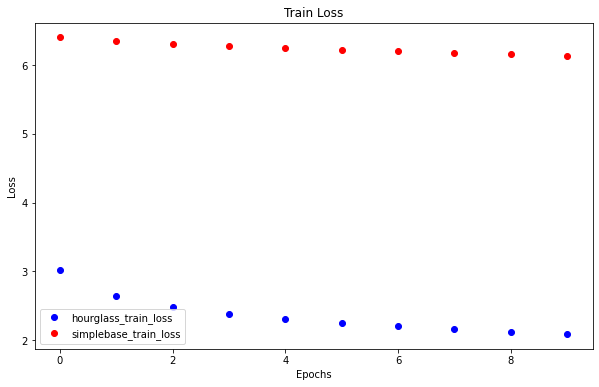

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(hourglass_train_loss, 'bo', label='hourglass_train_loss')
plt.plot(simplebase_train_loss, 'ro', label='simplebase_train_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train Loss")
plt.legend()
plt.show()

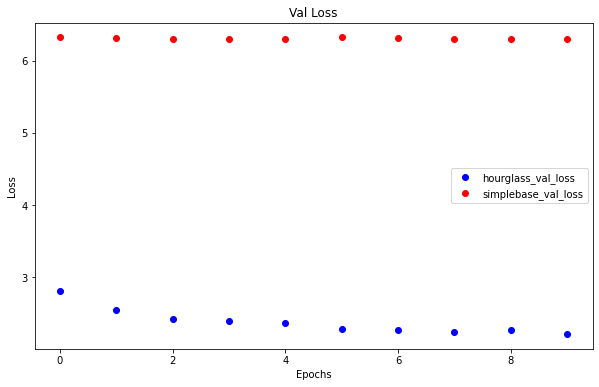

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(hourglass_val_loss, 'bo', label='hourglass_val_loss')
plt.plot(simplebase_val_loss, 'ro', label='simplebase_val_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Val Loss")
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model
model = load_model('mnist_mlp_model.h5')

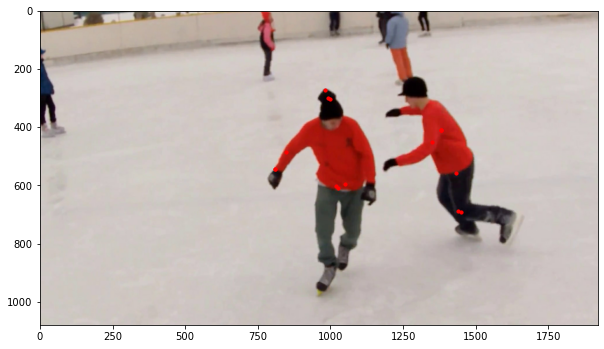

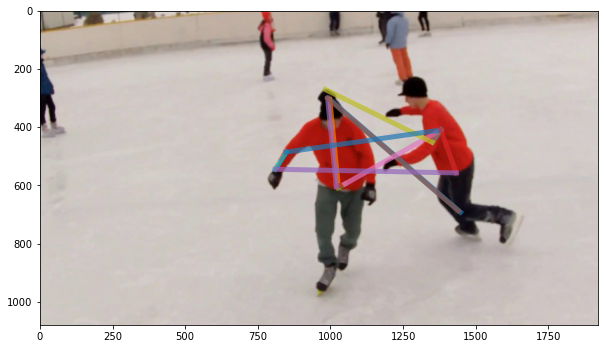

In [36]:
image, keypoints = predict('./test_image2.jpg')
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

In [ ]:
new_model = tf.keras.load

In [41]:
model.summary()

Model: "simple_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
sequential_3 (Sequential)    (None, 64, 64, 256)       10489600  
_________________________________________________________________
conv2d_247 (Conv2D)          (None, 64, 64, 16)        4112      
Total params: 34,081,424
Trainable params: 34,026,768
Non-trainable params: 54,656
_________________________________________________________________
